In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache


In [4]:
import visual_behavior.utilities as vbu
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.behavior

import visual_behavior.visualization.ophys.platform_paper_figures as ppf
import visual_behavior.visualization.ophys.summary_figures as sf
import visual_behavior.visualization.ophys.experiment_summary_figures as df

### get experiments and behavior sessions tables

In [5]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


In [6]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
# behavior_sessions = cache.get_behavior_session_table()

In [7]:
behavior_sessions = loading.get_platform_paper_behavior_session_table(include_4x2_data=False)

4787 behavior sessions in original behavior_sessions table
4787 behavior sessions after merging with project codes
4779 sessions after removing NaN session types
3667 sessions after removing VisualBehaviorMultiscope4areasx2d and Ai94
3667 sessions after adding session number, passive flag, and cell type columns
3667 sessions after adding experience_level column
3667 sessions after adding training_stage columns


In [8]:
behavior_sessions.project_code.unique()

array(['VisualBehaviorMultiscope', 'VisualBehaviorTask1B',
       'VisualBehavior'], dtype=object)

### add useful columns for filtering

In [9]:
# make fake ophys_container_id column so the below functions will work
behavior_sessions['ophys_container_id'] = behavior_sessions.mouse_id.values
# add last familiar and first novel columns
behavior_sessions = utilities.add_date_string(behavior_sessions)
behavior_sessions = utilities.add_n_relative_to_first_novel_column(behavior_sessions)
behavior_sessions = utilities.add_first_novel_column(behavior_sessions)
behavior_sessions = utilities.add_last_familiar_active_column(behavior_sessions)

original_behavior_sessions = behavior_sessions.copy()

### save directory for plots

In [10]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_1\behavior_metrics'


### load behavior metrics 

In [14]:
def get_save_folder(method, engaged_only, per_image):  
    folder = method
    if engaged_only: 
        folder = folder+'_engaged_only'
    if per_image:
        folder = folder+'_per_image' 
    return folder


def get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method='stimulus_based', engaged_only=True, per_image=False):
    behavior_stats = pd.DataFrame()
    problem_sessions = []
    for behavior_session_id in tqdm(behavior_session_ids):
        try:
            print('loading for', behavior_session_id)
            stats = vbu.get_cached_behavior_stats(behavior_session_id, engaged_only=engaged_only, method=method, per_image=per_image)
            behavior_stats = pd.concat([behavior_stats, stats])
        except:
            print('cant load stats for', behavior_session_id)
            problem_sessions.append(behavior_session_id)

    cache_dir = vbu.get_behavior_stats_cache_dir(method=method, engaged_only=engaged_only, per_image=per_image)
    filepath = os.path.join(cache_dir, 'all_sessions.h5')
    if not os.path.exists(filepath):
        behavior_stats.to_hdf(filepath, key='data')

    # merge stats with session metadata
    behavior_stats = behavior_stats.merge(behavior_sessions, on='behavior_session_id')

    # remove 4x2 sessions
    behavior_stats = behavior_stats[behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']
    
    return behavior_stats, problem_sessions

In [15]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


original_behavior_stats = behavior_stats.copy()

  0%|                                                                                 | 2/3667 [00:00<03:55, 15.55it/s]

loading for 742008131
loading for 742797917
loading for 743041166
loading for 743660302


  0%|▏                                                                                | 6/3667 [00:00<04:10, 14.63it/s]

loading for 744374168
loading for 745054849
loading for 745355000


  0%|▏                                                                                | 8/3667 [00:00<04:29, 13.57it/s]

loading for 745636848
loading for 746222622
loading for 746928360


  0%|▎                                                                               | 12/3667 [00:00<04:38, 13.12it/s]

loading for 750415261
loading for 750781358
loading for 752002559


  0%|▎                                                                               | 14/3667 [00:01<04:31, 13.46it/s]

loading for 753011296
loading for 753936007
loading for 754509820


  0%|▍                                                                               | 18/3667 [00:01<04:25, 13.75it/s]

loading for 754896244
loading for 755551879
loading for 756106020


  1%|▍                                                                               | 20/3667 [00:01<04:38, 13.12it/s]

loading for 756632727
loading for 757431083
loading for 758162988


  1%|▌                                                                               | 24/3667 [00:01<04:26, 13.66it/s]

loading for 758942142
loading for 759251920
loading for 759756829


  1%|▌                                                                               | 28/3667 [00:02<04:06, 14.73it/s]

loading for 760007428
loading for 760409951
loading for 760698062


  1%|▋                                                                               | 30/3667 [00:02<04:08, 14.62it/s]

loading for 761499069
loading for 761831761
loading for 762178061


  1%|▋                                                                               | 32/3667 [00:02<04:02, 15.00it/s]

loading for 762722108
loading for 763291103
loading for 763980798


  1%|▊                                                                               | 36/3667 [00:02<04:06, 14.74it/s]

loading for 764495320
loading for 764897570
loading for 765396393
loading for 766110635


  1%|▊                                                                               | 40/3667 [00:02<03:58, 15.19it/s]

loading for 766753111
loading for 767275980
loading for 768042187
loading for 768815421


  1%|▉                                                                               | 44/3667 [00:03<04:10, 14.44it/s]

loading for 769452637
loading for 769902997
loading for 770244427


  1%|█                                                                               | 46/3667 [00:03<04:11, 14.37it/s]

loading for 771245588
loading for 772125590
loading for 772658979


  1%|█                                                                               | 50/3667 [00:03<04:44, 12.72it/s]

loading for 773585522
loading for 774106776


  1%|█▏                                                                              | 52/3667 [00:03<05:09, 11.69it/s]

loading for 774373300
loading for 774422914


  1%|█▏                                                                              | 54/3667 [00:03<05:00, 12.01it/s]

loading for 774937388
loading for 775378326
loading for 775870895


  2%|█▏                                                                              | 56/3667 [00:04<04:55, 12.23it/s]

loading for 777082591
loading for 778166125
loading for 778980920


  2%|█▎                                                                              | 60/3667 [00:04<04:39, 12.90it/s]

loading for 779818630
loading for 780758836
loading for 782380778


  2%|█▎                                                                              | 62/3667 [00:04<04:40, 12.87it/s]

loading for 784156661
loading for 785426306
loading for 785944233


  2%|█▍                                                                              | 66/3667 [00:04<04:25, 13.56it/s]

loading for 786920476
loading for 788017709
loading for 791257562


  2%|█▍                                                                              | 68/3667 [00:04<04:16, 14.03it/s]

loading for 791749028
loading for 792499741
loading for 793129579


  2%|█▌                                                                              | 72/3667 [00:05<04:08, 14.48it/s]

loading for 796032489
loading for 760808911
loading for 761294708
loading for 761730617


  2%|█▋                                                                              | 76/3667 [00:05<04:00, 14.95it/s]

loading for 762067130
loading for 762418364
loading for 763012686
loading for 763661704


  2%|█▋                                                                              | 80/3667 [00:05<03:51, 15.46it/s]

loading for 764319580
loading for 764696952
loading for 765208332
loading for 765793356


  2%|█▊                                                                              | 84/3667 [00:06<04:00, 14.90it/s]

loading for 766532213
loading for 766931048
loading for 767730839


  2%|█▉                                                                              | 86/3667 [00:06<04:16, 13.98it/s]

loading for 768450504
loading for 769145833
loading for 769731277


  2%|█▉                                                                              | 91/3667 [00:06<03:38, 16.38it/s]

loading for 770215042
loading for 771040969
loading for 771902184
loading for 772475707
loading for 773391809


  3%|██▏                                                                             | 98/3667 [00:06<02:30, 23.75it/s]

loading for 774120511
loading for 774679623
loading for 775291372
loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859
loading for 780479408


  3%|██▎                                                                            | 107/3667 [00:06<01:57, 30.34it/s]

loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040
loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329


  3%|██▍                                                                            | 112/3667 [00:07<01:46, 33.26it/s]

loading for 791248943
loading for 791904071
loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990
loading for 796052844


  3%|██▌                                                                            | 120/3667 [00:07<01:44, 33.89it/s]

loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999
loading for 774208555
loading for 774767072
loading for 775344511


  4%|██▊                                                                            | 129/3667 [00:07<01:36, 36.84it/s]

loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423
loading for 780351711
loading for 781727422
loading for 783059206
loading for 783971649


  4%|██▉                                                                            | 139/3667 [00:07<01:31, 38.48it/s]

loading for 785376297
loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700
loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128
loading for 794673280
loading for 795431009


  4%|███▏                                                                           | 149/3667 [00:08<01:51, 31.67it/s]

loading for 796031509
loading for 797170547
loading for 776156839
loading for 777417642
loading for 778884020
loading for 779111633
loading for 780002890
loading for 780766304
loading for 783413166


  4%|███▍                                                                           | 159/3667 [00:08<01:35, 36.76it/s]

loading for 784173223
loading for 785539951
loading for 786305627
loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254
loading for 792661903
loading for 793323654


  5%|███▋                                                                           | 170/3667 [00:08<01:23, 41.94it/s]

loading for 794275479
loading for 794953909
loading for 795838927
loading for 796046197
loading for 796233602
loading for 796607829
loading for 798145975
loading for 798679618
loading for 799661667
loading for 800202171


  5%|███▉                                                                           | 180/3667 [00:08<01:19, 43.84it/s]

loading for 802406837
loading for 802922968
loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108
loading for 807198458
loading for 808107647
loading for 809321253


  5%|███▉                                                                           | 185/3667 [00:08<01:24, 40.99it/s]

loading for 791877093
loading for 792689261
loading for 793414389
loading for 794295959
loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316


  5%|████▏                                                                          | 195/3667 [00:09<01:28, 39.07it/s]

loading for 800299366
loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931
loading for 806792366


  6%|████▎                                                                          | 203/3667 [00:09<01:31, 37.91it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256


  6%|████▌                                                                          | 211/3667 [00:09<01:32, 37.23it/s]

loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295
loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950


  6%|████▋                                                                          | 219/3667 [00:09<01:37, 35.41it/s]

loading for 794977383
loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362
loading for 800919728
loading for 802364085
loading for 802988119


  6%|████▉                                                                          | 228/3667 [00:10<01:30, 37.82it/s]

loading for 803347004
loading for 805639780
loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167
loading for 809027309
loading for 809427293
loading for 811355443


  6%|████▉                                                                          | 232/3667 [00:10<01:31, 37.47it/s]

loading for 810584641
loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  7%|█████▏                                                                         | 241/3667 [00:10<01:33, 36.72it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380


  7%|█████▍                                                                         | 251/3667 [00:10<01:24, 40.45it/s]

loading for 822409353
loading for 823241007
loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541
loading for 826697158
loading for 827374757
loading for 828646658


  7%|█████▌                                                                         | 261/3667 [00:10<01:21, 41.80it/s]

loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988
loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024


  7%|█████▊                                                                         | 271/3667 [00:11<01:17, 43.76it/s]

loading for 807533658
loading for 808488955
loading for 809095689
loading for 809427297
loading for 809815041
loading for 810598880
loading for 811354008
loading for 811830102
loading for 812559803
loading for 813041953
loading for 813737110


  8%|██████▏                                                                        | 285/3667 [00:11<01:04, 52.64it/s]

loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256
loading for 817165094
loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655
loading for 822439453
loading for 823254723
loading for 824894721


  8%|██████▍                                                                        | 296/3667 [00:11<01:10, 47.63it/s]

loading for 807062523
loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660
loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983


  8%|██████▌                                                                        | 302/3667 [00:11<01:10, 47.77it/s]

loading for 814749891
loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377
loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346


  9%|██████▋                                                                        | 312/3667 [00:12<01:16, 43.76it/s]

loading for 822874578
loading for 823496226
loading for 824566587
loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593
loading for 829138837


  9%|██████▊                                                                        | 317/3667 [00:12<01:15, 44.26it/s]

loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683
loading for 833946929
loading for 834928595
loading for 835547527


  9%|███████                                                                        | 327/3667 [00:12<01:20, 41.54it/s]

loading for 835940015
loading for 837108110
loading for 837512169
loading for 823922942
loading for 824972176
loading for 825527066
loading for 826338809
loading for 826841473


  9%|███████▎                                                                       | 337/3667 [00:12<01:21, 40.80it/s]

loading for 827977069
loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963
loading for 832009551
loading for 832522789


  9%|███████▎                                                                       | 342/3667 [00:12<01:21, 40.58it/s]

loading for 833252272
loading for 834059775
loading for 834886139
loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869
loading for 838486964


 10%|███████▌                                                                       | 352/3667 [00:13<01:28, 37.48it/s]

loading for 839220840
loading for 839566028
loading for 839918083
loading for 840583412
loading for 841431760
loading for 841830077
loading for 842387217
loading for 842821314


 10%|███████▊                                                                       | 360/3667 [00:13<01:33, 35.31it/s]

loading for 843397714
loading for 844197868
loading for 844880686
loading for 845564445
loading for 846272622
loading for 847022155
loading for 847829598
loading for 848519645
loading for 849073265


 10%|███████▉                                                                       | 370/3667 [00:13<01:21, 40.41it/s]

loading for 849635376
loading for 850977753
loading for 851779746
loading for 852468381
loading for 853168204
loading for 853875502
loading for 854563857
loading for 855421865
loading for 855973498
loading for 856717282


 10%|████████▏                                                                      | 380/3667 [00:13<01:18, 41.73it/s]

loading for 857612105
loading for 859065627
loading for 859735311
loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911
loading for 864824449
loading for 865482857
loading for 866333758


 11%|████████▍                                                                      | 390/3667 [00:13<01:15, 43.50it/s]

loading for 867041502
loading for 867977775
loading for 868721114
loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118
loading for 875414332


 11%|████████▌                                                                      | 400/3667 [00:14<01:13, 44.60it/s]

loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127
loading for 882748184
loading for 884596128


 11%|████████▊                                                                      | 410/3667 [00:14<01:11, 45.42it/s]

loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012
loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950


 11%|█████████                                                                      | 420/3667 [00:14<01:12, 44.99it/s]

loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014
loading for 828838236
loading for 829282785
loading for 829877552
loading for 830620126
loading for 832019583


 12%|█████████▎                                                                     | 430/3667 [00:14<01:18, 41.31it/s]

loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885
loading for 836777468
loading for 837196627


 12%|█████████▎                                                                     | 435/3667 [00:15<01:21, 39.58it/s]

loading for 837647722
loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485
loading for 840594518
loading for 841429687
loading for 841842210


 12%|█████████▌                                                                     | 445/3667 [00:15<01:23, 38.65it/s]

loading for 842399625
loading for 842844413
loading for 843400443
loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338
loading for 847871771


 12%|█████████▊                                                                     | 453/3667 [00:15<01:24, 37.84it/s]

loading for 848599542
loading for 849136474
loading for 849648618
loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851
loading for 828646634


 13%|█████████▉                                                                     | 462/3667 [00:15<01:24, 37.96it/s]

loading for 829128279
loading for 829591790
loading for 830201482
loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071
loading for 833780803


 13%|██████████▏                                                                    | 471/3667 [00:15<01:23, 38.16it/s]

loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225
loading for 838236165
loading for 839014738


 13%|██████████▎                                                                    | 480/3667 [00:16<01:19, 40.03it/s]

loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100
loading for 843166865
loading for 844234790


 13%|██████████▌                                                                    | 490/3667 [00:16<01:14, 42.88it/s]

loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029
loading for 848575992
loading for 849098851
loading for 850976604
loading for 853266283
loading for 831129394
loading for 832021447


 14%|██████████▊                                                                    | 500/3667 [00:16<01:13, 43.03it/s]

loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296
loading for 836166694
loading for 836761653
loading for 837192567
loading for 837638916
loading for 838496126


 14%|██████████▉                                                                    | 510/3667 [00:16<01:14, 42.58it/s]

loading for 839234289
loading for 839566045
loading for 839939986
loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895


 14%|███████████                                                                    | 515/3667 [00:17<01:12, 43.51it/s]

loading for 843203333
loading for 844164376
loading for 844849972
loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804
loading for 853526948
loading for 834587823


 14%|███████████▎                                                                   | 525/3667 [00:17<01:12, 43.34it/s]

loading for 835451471
loading for 835867850
loading for 836522245
loading for 837083657
loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826


 14%|███████████▍                                                                   | 530/3667 [00:17<01:15, 41.69it/s]

loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868
loading for 842139310
loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277


 15%|███████████▋                                                                   | 541/3667 [00:17<01:14, 41.82it/s]

loading for 845409652
loading for 846051276
loading for 846791195
loading for 847613846
loading for 848272657
loading for 848938321
loading for 849525884
loading for 850817466


 15%|███████████▊                                                                   | 551/3667 [00:17<01:18, 39.81it/s]

loading for 851563931
loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407
loading for 855826937
loading for 857230827
loading for 837658854


 15%|███████████▉                                                                   | 555/3667 [00:18<01:19, 38.96it/s]

loading for 838515247
loading for 839219841
loading for 839565422
loading for 839912316
loading for 840581827
loading for 841426832
loading for 841827774
loading for 842385277


 15%|████████████▏                                                                  | 564/3667 [00:18<01:20, 38.51it/s]

loading for 842819933
loading for 843400453
loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328
loading for 847874940


 16%|████████████▎                                                                  | 574/3667 [00:18<01:19, 38.86it/s]

loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928
loading for 852451567
loading for 855200229
loading for 837654533


 16%|████████████▌                                                                  | 582/3667 [00:18<01:25, 36.27it/s]

loading for 838483140
loading for 839219845
loading for 839565426
loading for 839914270
loading for 840581823
loading for 841426857
loading for 841830096
loading for 842385266


 16%|████████████▋                                                                  | 591/3667 [00:18<01:20, 38.24it/s]

loading for 842819929
loading for 843401580
loading for 844199766
loading for 844891885
loading for 845572039
loading for 846016059
loading for 846750050
loading for 847660741


 16%|████████████▉                                                                  | 601/3667 [00:19<01:15, 40.54it/s]

loading for 848348215
loading for 848943191
loading for 849494762
loading for 850807174
loading for 851542477
loading for 852229360
loading for 853025613
loading for 855446545
loading for 855866701


 17%|█████████████                                                                  | 607/3667 [00:19<01:11, 42.62it/s]

loading for 856467236
loading for 857367017
loading for 858029487
loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649
loading for 840598877
loading for 841466830
loading for 841851097


 17%|█████████████▎                                                                 | 617/3667 [00:19<01:09, 44.11it/s]

loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895
loading for 844945060
loading for 845594684
loading for 846284880
loading for 847048490
loading for 847838131


 17%|█████████████▌                                                                 | 627/3667 [00:19<01:10, 43.11it/s]

loading for 848526511
loading for 848910243
loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248
loading for 853875514
loading for 854621677
loading for 855424348


 17%|█████████████▋                                                                 | 637/3667 [00:19<01:07, 44.65it/s]

loading for 857340041
loading for 857987666
loading for 858974731
loading for 859775117
loading for 863610582
loading for 868070216
loading for 868658294
loading for 869559097
loading for 850978904


 18%|█████████████▉                                                                 | 647/3667 [00:20<01:08, 43.99it/s]

loading for 851802107
loading for 852457995
loading for 853257103
loading for 853793068
loading for 854602288
loading for 855476794
loading for 856010720
loading for 856732195
loading for 857547928


 18%|██████████████                                                                 | 652/3667 [00:20<01:13, 41.07it/s]

loading for 858273959
loading for 859054070
loading for 859802280
loading for 860894659
loading for 861794694
loading for 862716894
loading for 863559318
loading for 864280264


 18%|██████████████▏                                                                | 661/3667 [00:20<01:18, 38.49it/s]

loading for 865544821
loading for 866336764
loading for 867098393
loading for 867945660
loading for 868819048
loading for 869621595
loading for 870960908


 18%|██████████████▍                                                                | 670/3667 [00:20<01:17, 38.60it/s]

loading for 872107505
loading for 873813922
loading for 874808131
loading for 876821717
loading for 854533487
loading for 855504136
loading for 856002607
loading for 856732191
loading for 857555456


 18%|██████████████▌                                                                | 678/3667 [00:21<01:19, 37.61it/s]

loading for 858240891
loading for 859032026
loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054
loading for 864137547


 19%|██████████████▊                                                                | 689/3667 [00:21<01:11, 41.37it/s]

loading for 864839176
loading for 865581941
loading for 866287088
loading for 866950070
loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378


 19%|██████████████▉                                                                | 695/3667 [00:21<01:08, 43.45it/s]

loading for 872646068
loading for 873517635
loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550
loading for 852507945
loading for 853260939


 19%|███████████████                                                                | 700/3667 [00:21<01:14, 40.03it/s]

loading for 853886146
loading for 855459012
loading for 855980937
loading for 856719615
loading for 857504898
loading for 858250763


 19%|███████████████▎                                                               | 709/3667 [00:21<01:20, 36.67it/s]

loading for 859049298
loading for 859784868
loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836
loading for 864260028
loading for 864813130


 20%|███████████████▍                                                               | 719/3667 [00:22<01:14, 39.79it/s]

loading for 865460179
loading for 866296478
loading for 866999677
loading for 867615541
loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394


 20%|███████████████▋                                                               | 729/3667 [00:22<01:11, 41.00it/s]

loading for 872626160
loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747
loading for 878120101
loading for 879037269
loading for 880046522


 20%|███████████████▊                                                               | 734/3667 [00:22<01:09, 42.32it/s]

loading for 880784794
loading for 882256117
loading for 854528256
loading for 855503335
loading for 856002613
loading for 856732213
loading for 857555461
loading for 858240896
loading for 859032044


 20%|████████████████                                                               | 744/3667 [00:22<01:06, 44.01it/s]

loading for 859791563
loading for 860752819
loading for 861794704
loading for 862701503
loading for 863559327
loading for 864125430
loading for 864839160
loading for 865580429
loading for 866287143


 21%|████████████████▏                                                              | 754/3667 [00:22<01:04, 44.87it/s]

loading for 867082086
loading for 868004770
loading for 868747797
loading for 872158938
loading for 873015934
loading for 873824951
loading for 874747892
loading for 875444395
loading for 876857698
loading for 878159171


 21%|████████████████▍                                                              | 764/3667 [00:23<01:03, 46.04it/s]

loading for 879037253
loading for 880201859
loading for 880776648
loading for 881413102
loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160
loading for 885644181
loading for 886440437


 21%|████████████████▋                                                              | 775/3667 [00:23<00:59, 48.62it/s]

loading for 887165432
loading for 888282547
loading for 858104885
loading for 858900546
loading for 859601488
loading for 860247669
loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979
loading for 864665192


 21%|████████████████▉                                                              | 785/3667 [00:23<01:07, 42.77it/s]

loading for 865114696
loading for 865887829
loading for 866906696
loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699


 22%|█████████████████                                                              | 790/3667 [00:23<01:08, 41.81it/s]

loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527
loading for 875020211
loading for 876448536
loading for 877855866
loading for 878615859


 22%|█████████████████▏                                                             | 799/3667 [00:23<01:18, 36.55it/s]

loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453
loading for 884598044


 22%|█████████████████▎                                                             | 804/3667 [00:24<01:13, 39.00it/s]

loading for 885404075
loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386
loading for 896561264


 22%|█████████████████▌                                                             | 813/3667 [00:24<01:12, 39.46it/s]

loading for 898432373
loading for 898874650
loading for 899390684
loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625
loading for 907053876
loading for 907900077
loading for 908533370


 22%|█████████████████▋                                                             | 823/3667 [00:24<01:15, 37.48it/s]

loading for 910207192
loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263
loading for 914705301
loading for 915418411


 23%|█████████████████▉                                                             | 832/3667 [00:24<01:14, 38.12it/s]

loading for 916403851
loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998
loading for 858098100
loading for 858891746


 23%|██████████████████                                                             | 837/3667 [00:24<01:10, 40.19it/s]

loading for 859601496
loading for 860247677
loading for 861715805
loading for 862326321
loading for 863361852
loading for 863966966
loading for 864656758
loading for 865114705
loading for 865883182


 23%|██████████████████▏                                                            | 847/3667 [00:25<01:07, 41.70it/s]

loading for 866912923
loading for 867553178
loading for 868521085
loading for 869223965
loading for 870473396
loading for 871723073
loading for 872607297
loading for 873440438
loading for 874324523


 23%|██████████████████▍                                                            | 857/3667 [00:25<01:08, 41.17it/s]

loading for 875020169
loading for 877447964
loading for 878282369
loading for 880231156
loading for 880780889
loading for 881427978
loading for 882434675
loading for 882827577
loading for 884888379


 24%|██████████████████▋                                                            | 868/3667 [00:25<01:02, 45.13it/s]

loading for 885739915
loading for 886446971
loading for 887236947
loading for 888301437
loading for 889559462
loading for 890374401
loading for 891792255
loading for 892663103
loading for 893600606


 24%|██████████████████▊                                                            | 874/3667 [00:25<01:03, 44.28it/s]

loading for 858098096
loading for 859064345
loading for 859735301
loading for 860650174
loading for 861785387
loading for 862752139
loading for 863571063
loading for 864137543
loading for 864820740


 24%|███████████████████                                                            | 884/3667 [00:25<01:02, 44.32it/s]

loading for 865463877
loading for 866319121
loading for 867036286
loading for 867961842
loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204
loading for 872979404
loading for 873733206


 24%|███████████████████▎                                                           | 894/3667 [00:26<01:01, 45.15it/s]

loading for 874654275
loading for 875385898
loading for 876737438
loading for 877558819
loading for 878233751
loading for 879003588
loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175
loading for 883857874


 25%|███████████████████▍                                                           | 904/3667 [00:26<01:02, 44.37it/s]

loading for 884800923
loading for 885589846
loading for 886437461
loading for 887183674
loading for 888263147
loading for 889436433
loading for 890459182
loading for 891759060
loading for 892589687
loading for 893433252


 25%|███████████████████▋                                                           | 914/3667 [00:26<01:07, 40.58it/s]

loading for 894215832
loading for 896543695
loading for 898493295
loading for 898889632
loading for 899400259
loading for 900228074
loading for 901102440
loading for 902021938
loading for 902822517


 25%|███████████████████▉                                                           | 924/3667 [00:26<01:05, 42.08it/s]

loading for 904630713
loading for 907035941
loading for 907995409
loading for 908564883
loading for 909363995
loading for 910249989
loading for 911361470
loading for 911947271
loading for 912570316
loading for 913710476


 25%|████████████████████                                                           | 934/3667 [00:27<01:07, 40.61it/s]

loading for 914230230
loading for 914715937
loading for 915448786
loading for 916450856
loading for 917331220
loading for 918202290
loading for 918900907
loading for 919634924
loading for 920541932


 26%|████████████████████▏                                                          | 939/3667 [00:27<01:06, 40.83it/s]

loading for 921601457
loading for 922572837
loading for 923474474
loading for 924575646
loading for 925033179
loading for 926393722
loading for 927449068
loading for 928400507


 26%|████████████████████▍                                                          | 949/3667 [00:27<01:07, 40.40it/s]

loading for 929341697
loading for 929818797
loading for 931566300
loading for 932611698
loading for 933504759
loading for 934610593
loading for 935811563
loading for 937416292


 26%|████████████████████▋                                                          | 959/3667 [00:27<01:04, 41.76it/s]

loading for 938377224
loading for 939538572
loading for 862786889
loading for 863627986
loading for 864248647
loading for 865463863
loading for 866103829
loading for 867056914
loading for 868008761


 26%|████████████████████▉                                                          | 969/3667 [00:28<01:02, 43.33it/s]

loading for 868709715
loading for 871033938
loading for 872127292
loading for 873051801
loading for 873781580
loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747


 27%|████████████████████▉                                                          | 974/3667 [00:28<01:01, 44.04it/s]

loading for 878282360
loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102
loading for 882388591
loading for 883704230
loading for 884677929
loading for 886239982


 27%|█████████████████████▏                                                         | 984/3667 [00:28<00:59, 44.88it/s]

loading for 886873295
loading for 889155682
loading for 890051221
loading for 891487953
loading for 892410834
loading for 893356870
loading for 894209378
loading for 894987969
loading for 896526348
loading for 898453640


 27%|█████████████████████▍                                                         | 994/3667 [00:28<00:58, 45.32it/s]

loading for 898889612
loading for 899452222
loading for 901380774
loading for 902270195
loading for 903070554
loading for 904011865
loading for 906695544
loading for 907356161
loading for 908908617


 27%|█████████████████████▎                                                        | 1004/3667 [00:28<01:00, 44.09it/s]

loading for 911021831
loading for 911522814
loading for 912242958
loading for 912918028
loading for 913898214
loading for 914405292
loading for 914868296
loading for 915690421
loading for 916623819
loading for 917581144


 28%|█████████████████████▌                                                        | 1014/3667 [00:28<00:57, 45.98it/s]

loading for 918454518
loading for 919073273
loading for 919973223
loading for 920836124
loading for 921879374
loading for 922942074
loading for 923786645
loading for 924729242
loading for 926769977
loading for 927745870


 28%|█████████████████████▊                                                        | 1024/3667 [00:29<00:57, 45.90it/s]

loading for 928717396
loading for 929524399
loading for 932078145
loading for 932975404
loading for 934075944
loading for 934900274
loading for 936033313
loading for 937825662


 28%|█████████████████████▉                                                        | 1034/3667 [00:29<01:00, 43.17it/s]

loading for 938991494
loading for 940243685
loading for 940796859
loading for 941946991
loading for 942448113
loading for 945277725
loading for 946172858
loading for 947503956


 28%|██████████████████████                                                        | 1039/3667 [00:29<01:02, 42.19it/s]

loading for 948341757
loading for 862479694
loading for 863414647
loading for 864000195
loading for 864729508
loading for 865288307
loading for 865953304
loading for 866971252


 29%|██████████████████████▎                                                       | 1049/3667 [00:29<01:05, 39.94it/s]

loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256
loading for 873530279


 29%|██████████████████████▍                                                       | 1054/3667 [00:29<01:02, 41.55it/s]

loading for 874295478
loading for 875020129
loading for 876521253
loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654
loading for 880647168
loading for 881253316


 29%|██████████████████████▋                                                       | 1064/3667 [00:30<01:01, 42.57it/s]

loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033
loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551
loading for 891504476


 29%|██████████████████████▊                                                       | 1074/3667 [00:30<00:59, 43.91it/s]

loading for 892413871
loading for 893359124
loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485


 30%|███████████████████████                                                       | 1085/3667 [00:30<00:57, 44.89it/s]

loading for 902028378
loading for 902822538
loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486
loading for 912159483


 30%|███████████████████████▏                                                      | 1090/3667 [00:30<00:57, 45.13it/s]

loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634
loading for 917595407
loading for 918474069
loading for 919104267
loading for 920015895


 30%|███████████████████████▍                                                      | 1101/3667 [00:31<00:57, 44.87it/s]

loading for 920839478
loading for 922012422
loading for 923834852
loading for 924759623
loading for 925603486
loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485


 30%|███████████████████████▋                                                      | 1111/3667 [00:31<00:56, 45.28it/s]

loading for 862730050
loading for 863657189
loading for 864236370
loading for 864809053
loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763
loading for 868704504
loading for 869615887


 31%|███████████████████████▊                                                      | 1122/3667 [00:31<00:55, 46.23it/s]

loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139
loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744
loading for 879003593


 31%|███████████████████████▉                                                      | 1127/3667 [00:31<00:55, 46.11it/s]

loading for 880088387
loading for 881416618
loading for 882373648
loading for 882785348
loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427
loading for 886931452


 31%|████████████████████████▏                                                     | 1137/3667 [00:31<00:55, 45.83it/s]

loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605
loading for 894466746
loading for 895241719
loading for 895877676
loading for 896969091


 31%|████████████████████████▍                                                     | 1147/3667 [00:32<00:59, 42.71it/s]

loading for 898658063
loading for 899685557
loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490
loading for 906641078
loading for 908092560


 32%|████████████████████████▌                                                     | 1157/3667 [00:32<01:00, 41.26it/s]

loading for 910381299
loading for 911016296
loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195
loading for 916614400


 32%|████████████████████████▋                                                     | 1162/3667 [00:32<01:01, 40.90it/s]

loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985
loading for 921873454
loading for 923757660
loading for 924739087


 32%|████████████████████████▉                                                     | 1171/3667 [00:32<01:04, 38.47it/s]

loading for 926621793
loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462
loading for 932960096
loading for 933939891
loading for 935038748


 32%|█████████████████████████                                                     | 1181/3667 [00:32<01:00, 40.78it/s]

loading for 936159430
loading for 937645038
loading for 938729036
loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533
loading for 945033994
loading for 947336783


 33%|█████████████████████████▎                                                    | 1192/3667 [00:33<00:57, 42.85it/s]

loading for 948225040
loading for 949348713
loading for 950188644
loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204
loading for 865131331


 33%|█████████████████████████▍                                                    | 1197/3667 [00:33<01:01, 40.40it/s]

loading for 865887821
loading for 866909432
loading for 867521015
loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185


 33%|█████████████████████████▋                                                    | 1208/3667 [00:33<00:57, 42.61it/s]

loading for 873449838
loading for 874333572
loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869
loading for 881210690
loading for 882291265


 33%|█████████████████████████▉                                                    | 1218/3667 [00:33<00:55, 44.06it/s]

loading for 882736270
loading for 883857883
loading for 884605735
loading for 885404024
loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687
loading for 894495169


 33%|██████████████████████████                                                    | 1223/3667 [00:33<00:57, 42.77it/s]

loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636
loading for 902211897
loading for 902995627
loading for 903977177


 34%|██████████████████████████▏                                                   | 1234/3667 [00:34<00:54, 44.76it/s]

loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306
loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 34%|██████████████████████████▍                                                   | 1244/3667 [00:34<00:55, 43.96it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442
loading for 877558833


 34%|██████████████████████████▋                                                   | 1254/3667 [00:34<00:59, 40.40it/s]

loading for 878245978
loading for 878993255
loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590
loading for 883756380


 34%|██████████████████████████▊                                                   | 1259/3667 [00:34<01:04, 37.51it/s]

loading for 884552901
loading for 885410929
loading for 886257016
loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129


 34%|██████████████████████████▊                                                   | 1263/3667 [00:34<01:04, 37.25it/s]

loading for 891446789
loading for 892387261
loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606


 35%|███████████████████████████                                                   | 1271/3667 [00:35<01:15, 31.65it/s]

loading for 866971269
loading for 867645566
loading for 868531777
loading for 869311972
loading for 870579061
loading for 871782397
loading for 872690218


 35%|███████████████████████████▏                                                  | 1279/3667 [00:35<01:10, 33.96it/s]

loading for 873537911
loading for 874416985
loading for 875020203
loading for 876651891
loading for 877487375
loading for 878179382
loading for 878771403


 35%|███████████████████████████▍                                                  | 1288/3667 [00:35<01:06, 35.76it/s]

loading for 879969002
loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813
loading for 883632956
loading for 884560064
loading for 885410934


 35%|███████████████████████████▍                                                  | 1292/3667 [00:35<01:05, 36.02it/s]

loading for 886250995
loading for 887006111
loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544
loading for 893488330


 35%|███████████████████████████▋                                                  | 1301/3667 [00:36<01:08, 34.50it/s]

loading for 894368064
loading for 870987812
loading for 872953842
loading for 873774125
loading for 874790261
loading for 875207834
loading for 876821726


 36%|███████████████████████████▉                                                  | 1311/3667 [00:36<01:00, 38.76it/s]

loading for 877603209
loading for 878245989
loading for 879003606
loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075
loading for 883986743
loading for 884776248


 36%|████████████████████████████                                                  | 1321/3667 [00:36<00:55, 42.13it/s]

loading for 885540237
loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960
loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304
loading for 893560763


 36%|████████████████████████████▏                                                 | 1327/3667 [00:36<00:53, 43.96it/s]

loading for 894481319
loading for 895248933
loading for 895896343
loading for 896995828
loading for 898667252
loading for 899700579
loading for 900231059
loading for 901363879
loading for 902260156


 36%|████████████████████████████▍                                                 | 1337/3667 [00:36<00:54, 42.86it/s]

loading for 902975505
loading for 904922810
loading for 906668549
loading for 908104455
loading for 910393217
loading for 911016285
loading for 911541950
loading for 912223787
loading for 912902619


 37%|████████████████████████████▋                                                 | 1347/3667 [00:37<00:51, 45.14it/s]

loading for 913850450
loading for 914339617
loading for 914831000
loading for 915609216
loading for 916617096
loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263
loading for 921979060


 37%|████████████████████████████▊                                                 | 1357/3667 [00:37<00:51, 44.57it/s]

loading for 923757653
loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491
loading for 929524423
loading for 930344469
loading for 932960104
loading for 933954934
loading for 935045761


 37%|█████████████████████████████                                                 | 1367/3667 [00:37<00:55, 41.26it/s]

loading for 936083473
loading for 937706038
loading for 938794488
loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530
loading for 944125005


 38%|█████████████████████████████▎                                                | 1376/3667 [00:37<01:00, 38.10it/s]

loading for 945075740
loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960


 38%|█████████████████████████████▎                                                | 1381/3667 [00:37<00:57, 39.48it/s]

loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966


 38%|█████████████████████████████▌                                                | 1391/3667 [00:38<00:54, 42.00it/s]

loading for 879074585
loading for 880174939
loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412
loading for 886446962
loading for 886953901


 38%|█████████████████████████████▊                                                | 1401/3667 [00:38<00:54, 41.73it/s]

loading for 888298590
loading for 889478291
loading for 890408635
loading for 891635663
loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003
loading for 895896368


 38%|██████████████████████████████                                                | 1411/3667 [00:38<00:51, 43.73it/s]

loading for 896995823
loading for 898682070
loading for 899742869
loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720
loading for 908165653
loading for 910448027
loading for 911061160


 39%|██████████████████████████████▏                                               | 1421/3667 [00:38<00:53, 42.25it/s]

loading for 911581364
loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413
loading for 916673577


 39%|██████████████████████████████▎                                               | 1426/3667 [00:38<00:56, 40.00it/s]

loading for 917600513
loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087
loading for 924740575


 39%|██████████████████████████████▌                                               | 1437/3667 [00:39<00:52, 42.82it/s]

loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554
loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243
loading for 934812249


 39%|██████████████████████████████▊                                               | 1447/3667 [00:39<00:49, 45.11it/s]

loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402
loading for 941425961
loading for 942350598
loading for 875155219
loading for 876829777
loading for 877607698


 40%|██████████████████████████████▉                                               | 1457/3667 [00:39<00:48, 45.49it/s]

loading for 878251933
loading for 879074574
loading for 880181164
loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037
loading for 884846935
loading for 885609778
loading for 886472241


 40%|███████████████████████████████▏                                              | 1467/3667 [00:39<00:49, 44.64it/s]

loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311
loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286
loading for 897002967


 40%|███████████████████████████████▍                                              | 1478/3667 [00:40<00:47, 46.33it/s]

loading for 898668828
loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148
loading for 902975514
loading for 904922795
loading for 906668545
loading for 908109320
loading for 910393226


 41%|███████████████████████████████▋                                              | 1488/3667 [00:40<00:47, 45.96it/s]

loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659
loading for 913854181
loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112


 41%|███████████████████████████████▊                                              | 1493/3667 [00:40<00:47, 46.10it/s]

loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990
loading for 921879360
loading for 923877874


 41%|███████████████████████████████▉                                              | 1503/3667 [00:40<00:53, 40.58it/s]

loading for 924757055
loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550
loading for 930335512
loading for 931488919
loading for 932596575


 41%|████████████████████████████████                                              | 1508/3667 [00:40<00:57, 37.58it/s]

loading for 933472975
loading for 935601725
loading for 937442661
loading for 938425882
loading for 939537734
loading for 940553228
loading for 941457567


 41%|████████████████████████████████▏                                             | 1516/3667 [00:41<00:58, 36.97it/s]

loading for 942329079
loading for 943479988
loading for 944823947
loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760
loading for 886424035


 42%|████████████████████████████████▍                                             | 1524/3667 [00:41<00:56, 38.18it/s]

loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468
loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950


 42%|████████████████████████████████▌                                             | 1532/3667 [00:41<00:57, 37.35it/s]

loading for 895248904
loading for 895947603
loading for 896945902
loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232


 42%|████████████████████████████████▊                                             | 1542/3667 [00:41<00:59, 35.53it/s]

loading for 904844395
loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286


 42%|█████████████████████████████████                                             | 1552/3667 [00:42<00:52, 40.27it/s]

loading for 892645353
loading for 893600610
loading for 894481279
loading for 895270564
loading for 896024686
loading for 896931325
loading for 898658079
loading for 899685565
loading for 900226853


 42%|█████████████████████████████████▏                                            | 1558/3667 [00:42<00:49, 42.69it/s]

loading for 901358520
loading for 902255179
loading for 902975500
loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196
loading for 910396133
loading for 911025799
loading for 911527254


 43%|█████████████████████████████████▎                                            | 1568/3667 [00:42<00:46, 45.55it/s]

loading for 912318850
loading for 913901536
loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254
loading for 918296132
loading for 921923865
loading for 922869624
loading for 896582130


 43%|█████████████████████████████████▌                                            | 1578/3667 [00:42<00:44, 46.52it/s]

loading for 898476716
loading for 898886781
loading for 899377948
loading for 900226240
loading for 901076133
loading for 902099849
loading for 902803430
loading for 904592832
loading for 907020008
loading for 907995393


 43%|█████████████████████████████████▊                                            | 1588/3667 [00:42<00:44, 47.02it/s]

loading for 908564916
loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735
loading for 913878014
loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326


 44%|█████████████████████████████████▉                                            | 1598/3667 [00:42<00:44, 46.96it/s]

loading for 919731225
loading for 920798071
loading for 922656861
loading for 923639002
loading for 924750401
loading for 925508961
loading for 926651381
loading for 927716204
loading for 928809619
loading for 929503445


 44%|██████████████████████████████████▏                                           | 1609/3667 [00:43<00:44, 46.61it/s]

loading for 930335519
loading for 892283069
loading for 893354175
loading for 894078803
loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915
loading for 898877946


 44%|██████████████████████████████████▍                                           | 1619/3667 [00:43<00:46, 44.24it/s]

loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389
loading for 902810506
loading for 903693439
loading for 907035950
loading for 907912571


 44%|██████████████████████████████████▌                                           | 1624/3667 [00:43<00:50, 40.64it/s]

loading for 908489409
loading for 909341448
loading for 910182303
loading for 910812913
loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684


 44%|██████████████████████████████████▋                                           | 1629/3667 [00:43<00:49, 41.07it/s]

loading for 914219174
loading for 914691372
loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812
loading for 918860187


 45%|██████████████████████████████████▊                                           | 1638/3667 [00:44<00:56, 36.18it/s]

loading for 919485101
loading for 921759097
loading for 921503547
loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 45%|███████████████████████████████████                                           | 1646/3667 [00:44<00:55, 36.37it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660
loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 45%|███████████████████████████████████▏                                          | 1655/3667 [00:44<00:52, 38.27it/s]

loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564
loading for 915675582
loading for 916667034
loading for 917588238


 45%|███████████████████████████████████▍                                          | 1664/3667 [00:44<00:49, 40.11it/s]

loading for 918488020
loading for 919082124
loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598
loading for 926607088
loading for 927629370


 46%|███████████████████████████████████▌                                          | 1674/3667 [00:44<00:47, 41.71it/s]

loading for 928633684
loading for 929519500
loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429
loading for 936083459
loading for 937706048
loading for 938767948


 46%|███████████████████████████████████▋                                          | 1679/3667 [00:45<00:48, 41.14it/s]

loading for 939977527
loading for 940755054
loading for 941734023
loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540
loading for 949182428


 46%|███████████████████████████████████▉                                          | 1689/3667 [00:45<00:45, 43.41it/s]

loading for 951453828
loading for 952657468
loading for 953952253
loading for 955962226
loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127
loading for 960834330
loading for 961246494
loading for 962346335


 46%|████████████████████████████████████▏                                         | 1700/3667 [00:45<00:43, 45.10it/s]

loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499
loading for 966765494
loading for 900251755
loading for 901064316
loading for 902014154
loading for 902875760
loading for 906441548


 47%|████████████████████████████████████▍                                         | 1711/3667 [00:45<00:42, 45.88it/s]

loading for 907164993
loading for 907977016
loading for 908558828
loading for 909513754
loading for 910298657
loading for 910859648
loading for 911479876
loading for 911960088
loading for 912570334
loading for 913684329


 47%|████████████████████████████████████▌                                         | 1721/3667 [00:45<00:45, 42.73it/s]

loading for 914221457
loading for 914691381
loading for 915343343
loading for 916403841
loading for 917261905
loading for 918098776
loading for 918828535
loading for 919444416


 47%|████████████████████████████████████▋                                         | 1726/3667 [00:46<00:46, 42.02it/s]

loading for 920487809
loading for 921423123
loading for 922494701
loading for 923399568
loading for 924515483
loading for 925085028
loading for 926401857
loading for 927430067


 47%|████████████████████████████████████▉                                         | 1736/3667 [00:46<00:48, 39.56it/s]

loading for 928571063
loading for 929467503
loading for 929888639
loading for 931955527
loading for 932884713
loading for 933830753
loading for 935018722


 47%|█████████████████████████████████████                                         | 1740/3667 [00:46<00:55, 34.74it/s]

loading for 936026370
loading for 937663417
loading for 938745166
loading for 939936627
loading for 901399302
loading for 902323283


 48%|█████████████████████████████████████▏                                        | 1749/3667 [00:46<00:52, 36.58it/s]

loading for 903101960
loading for 904950235
loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828
loading for 913001481


 48%|█████████████████████████████████████▍                                        | 1758/3667 [00:46<00:48, 39.12it/s]

loading for 913908289
loading for 914402478
loading for 914855672
loading for 915675595
loading for 916667039
loading for 917588247
loading for 918486608
loading for 919082134
loading for 919985026


 48%|█████████████████████████████████████▌                                        | 1766/3667 [00:47<00:50, 37.86it/s]

loading for 920888197
loading for 921959207
loading for 923845421
loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222


 48%|█████████████████████████████████████▋                                        | 1774/3667 [00:47<00:59, 31.67it/s]

loading for 929539392
loading for 930443737
loading for 933034558
loading for 934070063
loading for 935150167


 48%|█████████████████████████████████████▊                                        | 1778/3667 [00:47<01:03, 29.61it/s]

loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161
loading for 940757571
loading for 941726524


 49%|█████████████████████████████████████▉                                        | 1785/3667 [00:47<01:05, 28.82it/s]

loading for 942767539
loading for 944124976
loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743


 49%|██████████████████████████████████████                                        | 1789/3667 [00:47<01:00, 30.83it/s]

loading for 949402246
loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085
loading for 957435664
loading for 958532504


 49%|██████████████████████████████████████▎                                       | 1801/3667 [00:48<00:47, 39.63it/s]

loading for 959051998
loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838
loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308


 49%|██████████████████████████████████████▍                                       | 1809/3667 [00:48<00:48, 38.14it/s]

loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982
loading for 911346410
loading for 911927191
loading for 912570302


 50%|██████████████████████████████████████▋                                       | 1821/3667 [00:48<00:40, 45.11it/s]

loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425
loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810
loading for 920528725


 50%|██████████████████████████████████████▊                                       | 1826/3667 [00:48<00:43, 42.12it/s]

loading for 921566809
loading for 922540163
loading for 923445943
loading for 924544064
loading for 924985099
loading for 926434150
loading for 927423753


 50%|███████████████████████████████████████                                       | 1836/3667 [00:49<00:49, 36.97it/s]

loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539
loading for 934707744


 50%|███████████████████████████████████████▏                                      | 1844/3667 [00:49<00:49, 36.86it/s]

loading for 937457770
loading for 939536227
loading for 939765508
loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608
loading for 944698858


 50%|███████████████████████████████████████▎                                      | 1849/3667 [00:49<00:46, 39.32it/s]

loading for 945645033
loading for 947038510
loading for 947948249
loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573


 51%|███████████████████████████████████████▍                                      | 1857/3667 [00:49<00:52, 34.33it/s]

loading for 953991886
loading for 954603651
loading for 956171927
loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885
loading for 960501578


 51%|███████████████████████████████████████▋                                      | 1866/3667 [00:49<00:49, 36.03it/s]

loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505
loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901


 51%|███████████████████████████████████████▉                                      | 1875/3667 [00:50<00:49, 36.28it/s]

loading for 898876989
loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495
loading for 903693459
loading for 907035932
loading for 907899541


 51%|████████████████████████████████████████                                      | 1885/3667 [00:50<00:45, 38.77it/s]

loading for 908468655
loading for 909291218
loading for 910182310
loading for 910799740
loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146


 52%|████████████████████████████████████████▏                                     | 1889/3667 [00:50<00:46, 38.13it/s]

loading for 914265106
loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206
loading for 918202284
loading for 918900918
loading for 919442744


 52%|████████████████████████████████████████▍                                     | 1899/3667 [00:50<00:43, 40.69it/s]

loading for 921364147
loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863
loading for 926393711
loading for 927419411
loading for 928279918
loading for 929354243


 52%|████████████████████████████████████████▌                                     | 1909/3667 [00:51<00:40, 43.36it/s]

loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957
loading for 935129110
loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140


 52%|████████████████████████████████████████▊                                     | 1921/3667 [00:51<00:36, 47.70it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919
loading for 949337508
loading for 950157787
loading for 952746230
loading for 954120560
loading for 909257371
loading for 910242110


 53%|█████████████████████████████████████████                                     | 1932/3667 [00:51<00:36, 47.42it/s]

loading for 911352320
loading for 911933262
loading for 912570338
loading for 913694953
loading for 914221468
loading for 914708607
loading for 915429431
loading for 916437737
loading for 917317419


 53%|█████████████████████████████████████████▏                                    | 1937/3667 [00:51<00:36, 46.96it/s]

loading for 918172085
loading for 918885657
loading for 919586824
loading for 920528706
loading for 921574218
loading for 922540172
loading for 923445937
loading for 924544060
loading for 924985107


 53%|█████████████████████████████████████████▍                                    | 1947/3667 [00:51<00:39, 43.53it/s]

loading for 926434134
loading for 927423777
loading for 928263232
loading for 929309896
loading for 929767347
loading for 931526080
loading for 932547917
loading for 933456511


 53%|█████████████████████████████████████████▋                                    | 1957/3667 [00:52<00:38, 44.56it/s]

loading for 934725358
loading for 937356503
loading for 939538579
loading for 940566201
loading for 941836985
loading for 942598032
loading for 943948998
loading for 945063207
loading for 946207506


 54%|█████████████████████████████████████████▋                                    | 1962/3667 [00:52<00:39, 43.14it/s]

loading for 947306051
loading for 948238859
loading for 949362058
loading for 950164260
loading for 951689917
loading for 952888820
loading for 954166538


 54%|█████████████████████████████████████████▉                                    | 1972/3667 [00:52<00:44, 37.98it/s]

loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218
loading for 958434406
loading for 958994511
loading for 959893902


 54%|██████████████████████████████████████████                                    | 1976/3667 [00:52<00:44, 37.62it/s]

loading for 960697332
loading for 936116165
loading for 937854150
loading for 938889808
loading for 940154108
loading for 940779937


 54%|██████████████████████████████████████████                                    | 1980/3667 [00:52<00:50, 33.41it/s]

loading for 941896070
loading for 942849916
loading for 944216879
loading for 945204293
loading for 946281668
loading for 947385424


 54%|██████████████████████████████████████████▎                                   | 1989/3667 [00:53<00:49, 34.15it/s]

loading for 948148817
loading for 949182414
loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348
loading for 958888268


 55%|██████████████████████████████████████████▌                                   | 1999/3667 [00:53<00:42, 39.60it/s]

loading for 959675291
loading for 960488162
loading for 962191834
loading for 962984229
loading for 963694974
loading for 964894591
loading for 937363104
loading for 939772185
loading for 940635435
loading for 941700201


 55%|██████████████████████████████████████████▋                                   | 2009/3667 [00:53<00:38, 42.60it/s]

loading for 942412338
loading for 943559700
loading for 944845647
loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814
loading for 951565921
loading for 952752558


 55%|██████████████████████████████████████████▉                                   | 2020/3667 [00:53<00:35, 46.03it/s]

loading for 953978412
loading for 954603672
loading for 956010816
loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077
loading for 960697328
loading for 962191827
loading for 963114728
loading for 963923531


 55%|███████████████████████████████████████████▏                                  | 2030/3667 [00:53<00:35, 45.88it/s]

loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999
loading for 969310457
loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980


 56%|███████████████████████████████████████████▍                                  | 2042/3667 [00:54<00:33, 48.32it/s]

loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765
loading for 941776657
loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037


 56%|███████████████████████████████████████████▋                                  | 2052/3667 [00:54<00:34, 47.49it/s]

loading for 950183210
loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370
loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124


 56%|███████████████████████████████████████████▊                                  | 2058/3667 [00:54<00:32, 49.63it/s]

loading for 961226066
loading for 962154268
loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365
loading for 969423725


 56%|███████████████████████████████████████████▉                                  | 2068/3667 [00:54<00:38, 41.18it/s]

loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557
loading for 972527218
loading for 973798798
loading for 974328452


 57%|████████████████████████████████████████████                                  | 2073/3667 [00:54<00:40, 39.36it/s]

loading for 974899766
loading for 975455944
loading for 976199854
loading for 976952429
loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313


 57%|████████████████████████████████████████████▎                                 | 2083/3667 [00:55<00:41, 38.29it/s]

loading for 980154562
loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025
loading for 988137738
loading for 989139686
loading for 989523730


 57%|████████████████████████████████████████████▍                                 | 2091/3667 [00:55<00:42, 37.49it/s]

loading for 990319706
loading for 990619461
loading for 990871215
loading for 991763993
loading for 991997544
loading for 992251964
loading for 992417143
loading for 992816969


 57%|████████████████████████████████████████████▋                                 | 2099/3667 [00:55<00:42, 37.03it/s]

loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659
loading for 994743822
loading for 994894518
loading for 995142529


 58%|████████████████████████████████████████████▊                                 | 2109/3667 [00:55<00:39, 39.87it/s]

loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986
loading for 933049320
loading for 934082432
loading for 935199639
loading for 936163556
loading for 937854186
loading for 938889840


 58%|█████████████████████████████████████████████                                 | 2120/3667 [00:56<00:36, 42.66it/s]

loading for 940145401
loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063
loading for 947355907


 58%|█████████████████████████████████████████████▏                                | 2125/3667 [00:56<00:35, 43.53it/s]

loading for 948309156
loading for 949394856
loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305
loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158


 58%|█████████████████████████████████████████████▍                                | 2136/3667 [00:56<00:33, 45.13it/s]

loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926
loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910


 59%|█████████████████████████████████████████████▋                                | 2146/3667 [00:56<00:32, 46.31it/s]

loading for 967582099
loading for 968526430
loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977
loading for 972775265
loading for 973461310


 59%|█████████████████████████████████████████████▉                                | 2157/3667 [00:56<00:33, 45.76it/s]

loading for 973777176
loading for 974330793
loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176
loading for 978108456
loading for 978647080


 59%|██████████████████████████████████████████████                                | 2167/3667 [00:57<00:32, 45.57it/s]

loading for 979414755
loading for 980102697
loading for 981957849
loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076


 59%|██████████████████████████████████████████████▏                               | 2172/3667 [00:57<00:35, 42.57it/s]

loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986
loading for 951537035
loading for 952752540
loading for 954055841


 60%|██████████████████████████████████████████████▍                               | 2182/3667 [00:57<00:38, 39.07it/s]

loading for 957033598
loading for 958535615
loading for 959067523
loading for 959883227
loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994


 60%|██████████████████████████████████████████████▋                               | 2192/3667 [00:57<00:37, 39.24it/s]

loading for 965760531
loading for 966835517
loading for 967660435
loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377


 60%|██████████████████████████████████████████████▋                               | 2196/3667 [00:57<00:37, 38.94it/s]

loading for 955110055
loading for 956509652
loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932


 60%|██████████████████████████████████████████████▉                               | 2206/3667 [00:58<00:35, 40.80it/s]

loading for 963299398
loading for 964154152
loading for 965069208
loading for 966886347
loading for 967713029
loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052
loading for 971687725


 60%|███████████████████████████████████████████████▏                              | 2216/3667 [00:58<00:36, 39.75it/s]

loading for 972119106
loading for 972543146
loading for 973772504
loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524
loading for 977010114


 61%|███████████████████████████████████████████████▎                              | 2225/3667 [00:58<00:35, 40.67it/s]

loading for 977827851
loading for 978216155
loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749
loading for 985778420
loading for 988866696


 61%|███████████████████████████████████████████████▌                              | 2235/3667 [00:58<00:33, 42.82it/s]

loading for 989340717
loading for 990193421
loading for 990520288
loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673
loading for 943546129


 61%|███████████████████████████████████████████████▊                              | 2245/3667 [00:59<00:35, 40.27it/s]

loading for 944913801
loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124
loading for 951520315
loading for 952729858
loading for 954005976


 61%|███████████████████████████████████████████████▊                              | 2250/3667 [00:59<00:34, 41.43it/s]

loading for 957030816
loading for 958234751
loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565
loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508


 62%|████████████████████████████████████████████████                              | 2261/3667 [00:59<00:31, 44.85it/s]

loading for 965479110
loading for 966396577
loading for 967216790
loading for 968109978
loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671


 62%|████████████████████████████████████████████████▎                             | 2271/3667 [00:59<00:31, 44.82it/s]

loading for 972754358
loading for 973339148
loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535
loading for 976559011
loading for 977378894
loading for 978098623


 62%|████████████████████████████████████████████████▌                             | 2281/3667 [00:59<00:30, 45.29it/s]

loading for 979217919
loading for 979782710
loading for 981683576
loading for 982558306
loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904
loading for 988854432
loading for 989362600


 62%|████████████████████████████████████████████████▋                             | 2291/3667 [01:00<00:30, 45.51it/s]

loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286
loading for 955079055
loading for 956433359
loading for 957418694
loading for 958522022
loading for 959031158


 63%|████████████████████████████████████████████████▊                             | 2296/3667 [01:00<00:31, 43.68it/s]

loading for 959982753
loading for 960796988
loading for 961226056
loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641
loading for 965760509


 63%|█████████████████████████████████████████████████                             | 2306/3667 [01:00<00:34, 39.58it/s]

loading for 966814252
loading for 967603224
loading for 968536946
loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706


 63%|█████████████████████████████████████████████████▏                            | 2311/3667 [01:00<00:35, 38.27it/s]

loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112
loading for 974902041
loading for 975498864
loading for 976215999


 63%|█████████████████████████████████████████████████▎                            | 2320/3667 [01:00<00:37, 36.17it/s]

loading for 976558967
loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859
loading for 982741950


 64%|█████████████████████████████████████████████████▌                            | 2329/3667 [01:01<00:35, 37.88it/s]

loading for 984071678
loading for 986234827
loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889
loading for 960838900
loading for 961239902


 64%|█████████████████████████████████████████████████▋                            | 2338/3667 [01:01<00:34, 38.72it/s]

loading for 962230915
loading for 963207517
loading for 964148917
loading for 965061650
loading for 965760520
loading for 966814266
loading for 967428691
loading for 968198017


 64%|█████████████████████████████████████████████████▊                            | 2343/3667 [01:01<00:33, 39.14it/s]

loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813
loading for 973744975
loading for 974282914
loading for 974634733
loading for 965556136
loading for 966522771


 64%|██████████████████████████████████████████████████                            | 2355/3667 [01:01<00:29, 43.74it/s]

loading for 967216813
loading for 968124567
loading for 969033475
loading for 970703223
loading for 971496608
loading for 971885037
loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287


 65%|██████████████████████████████████████████████████▎                           | 2366/3667 [01:01<00:28, 45.40it/s]

loading for 974129649
loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267
loading for 978087229
loading for 978554436
loading for 979231641
loading for 981675150


 65%|██████████████████████████████████████████████████▍                           | 2371/3667 [01:02<00:28, 45.51it/s]

loading for 982534912
loading for 983295418
loading for 985723363
loading for 986634457
loading for 987422117
loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457
loading for 990857358


 65%|██████████████████████████████████████████████████▋                           | 2381/3667 [01:02<00:28, 45.62it/s]

loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035


 65%|██████████████████████████████████████████████████▊                           | 2391/3667 [01:02<00:28, 45.25it/s]

loading for 969120337
loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052


 65%|███████████████████████████████████████████████████                           | 2401/3667 [01:02<00:28, 45.18it/s]

loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658
loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380
loading for 986652189
loading for 987422139


 66%|███████████████████████████████████████████████████▎                          | 2411/3667 [01:02<00:30, 41.10it/s]

loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137
loading for 991717995
loading for 991995036
loading for 992251261


 66%|███████████████████████████████████████████████████▍                          | 2421/3667 [01:03<00:29, 41.60it/s]

loading for 992414875
loading for 992815106
loading for 993275724
loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784
loading for 971684789
loading for 972106742


 66%|███████████████████████████████████████████████████▌                          | 2426/3667 [01:03<00:28, 43.29it/s]

loading for 972540981
loading for 973796662
loading for 974307455
loading for 974882499
loading for 975445705
loading for 976193737
loading for 976937657


 66%|███████████████████████████████████████████████████▊                          | 2436/3667 [01:03<00:32, 37.98it/s]

loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924
loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828


 67%|███████████████████████████████████████████████████▉                          | 2441/3667 [01:03<00:31, 38.59it/s]

loading for 986941318
loading for 987963201
loading for 989118889
loading for 989493098
loading for 990290937
loading for 990596974
loading for 990818124
loading for 991737442


 67%|████████████████████████████████████████████████████                          | 2450/3667 [01:03<00:32, 37.37it/s]

loading for 991992564
loading for 992234604
loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972
loading for 994733817


 67%|████████████████████████████████████████████████████▎                         | 2459/3667 [01:04<00:30, 38.97it/s]

loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740
loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484
loading for 999757515
loading for 1000027383


 67%|████████████████████████████████████████████████████▌                         | 2469/3667 [01:04<00:28, 41.53it/s]

loading for 1000361701
loading for 1000581464
loading for 1000749574
loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326


 68%|████████████████████████████████████████████████████▊                         | 2482/3667 [01:04<00:25, 46.70it/s]

loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306
loading for 972509817
loading for 973792330
loading for 974325735
loading for 974897906
loading for 975497145
loading for 976141571


 68%|█████████████████████████████████████████████████████                         | 2492/3667 [01:04<00:24, 47.66it/s]

loading for 976998742
loading for 977813681
loading for 978214308
loading for 978725365
loading for 979435570
loading for 980128957
loading for 982739234
loading for 984049638
loading for 986176263
loading for 987024259


 68%|█████████████████████████████████████████████████████▏                        | 2503/3667 [01:05<00:24, 48.20it/s]

loading for 988137751
loading for 989139059
loading for 989522242
loading for 990319701
loading for 990619459
loading for 990871198
loading for 991762676
loading for 992008722
loading for 992258886
loading for 992431467


 69%|█████████████████████████████████████████████████████▍                        | 2513/3667 [01:05<00:24, 46.97it/s]

loading for 993278657
loading for 993553179
loading for 994011817
loading for 994746498
loading for 995184516
loading for 995380960
loading for 997367081
loading for 997538351
loading for 997960041
loading for 998351955


 69%|█████████████████████████████████████████████████████▋                        | 2523/3667 [01:05<00:24, 46.35it/s]

loading for 998699562
loading for 998999543
loading for 999215832
loading for 999741641
loading for 1000062519
loading for 1000406754
loading for 1000600602
loading for 1000749577
loading for 1001417592
loading for 1001803131


 69%|█████████████████████████████████████████████████████▊                        | 2528/3667 [01:05<00:27, 40.94it/s]

loading for 1002219417
loading for 1003005394
loading for 1003302686
loading for 1003630158
loading for 974888891
loading for 976173608
loading for 976919511


 69%|█████████████████████████████████████████████████████▉                        | 2533/3667 [01:05<00:27, 40.62it/s]

loading for 977820098
loading for 978207239
loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852


 69%|██████████████████████████████████████████████████████                        | 2543/3667 [01:06<00:28, 38.79it/s]

loading for 984049651
loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015
loading for 989519331
loading for 990316463
loading for 990619466


 70%|██████████████████████████████████████████████████████▎                       | 2552/3667 [01:06<00:29, 37.47it/s]

loading for 990871255
loading for 991763995
loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558
loading for 993245074
loading for 993537991
loading for 993691759


 70%|██████████████████████████████████████████████████████▍                       | 2562/3667 [01:06<00:27, 40.31it/s]

loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957
loading for 981740006
loading for 982598237
loading for 983472077


 70%|██████████████████████████████████████████████████████▌                       | 2567/3667 [01:06<00:26, 41.25it/s]

loading for 985852751
loading for 986800462
loading for 987668706
loading for 988931814
loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056


 70%|██████████████████████████████████████████████████████▊                       | 2576/3667 [01:06<00:28, 38.58it/s]

loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858
loading for 992724757
loading for 993242859
loading for 993541036
loading for 993706715
loading for 993957378


 71%|███████████████████████████████████████████████████████                       | 2586/3667 [01:07<00:25, 42.04it/s]

loading for 994174745
loading for 994705194
loading for 994880774
loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979


 71%|███████████████████████████████████████████████████████▏                      | 2597/3667 [01:07<00:23, 44.69it/s]

loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428
loading for 999057997
loading for 999315186
loading for 999868853
loading for 1000158417
loading for 1000450788


 71%|███████████████████████████████████████████████████████▎                      | 2602/3667 [01:07<00:23, 44.99it/s]

loading for 1000742262
loading for 1000782696
loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316
loading for 1003340085
loading for 1003678703
loading for 1004058414


 71%|███████████████████████████████████████████████████████▌                      | 2614/3667 [01:07<00:22, 46.56it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321
loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579
loading for 1001365018


 72%|███████████████████████████████████████████████████████▊                      | 2626/3667 [01:08<00:21, 48.59it/s]

loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222
loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295
loading for 1005215224
loading for 1005411542


 72%|████████████████████████████████████████████████████████                      | 2636/3667 [01:08<00:21, 47.59it/s]

loading for 1005623135
loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469
loading for 1007247990
loading for 1007744712
loading for 1008030870
loading for 1008535747
loading for 1008881178
loading for 1000808691


 72%|████████████████████████████████████████████████████████▎                     | 2647/3667 [01:08<00:22, 44.80it/s]

loading for 1001884140
loading for 1002274398
loading for 1002538652
loading for 1003055748
loading for 1003339102
loading for 1003689640
loading for 1004060798
loading for 1004369335
loading for 1004856955


 72%|████████████████████████████████████████████████████████▍                     | 2652/3667 [01:08<00:23, 43.70it/s]

loading for 1005043012
loading for 1005262287
loading for 1005478155
loading for 1005695663
loading for 1006226529
loading for 1006405139
loading for 1006705252
loading for 1006990770


 73%|████████████████████████████████████████████████████████▌                     | 2662/3667 [01:08<00:23, 42.01it/s]

loading for 1007843314
loading for 1008110076
loading for 1008616304
loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346
loading for 1010724655
loading for 1010972317


 73%|████████████████████████████████████████████████████████▊                     | 2672/3667 [01:09<00:24, 41.28it/s]

loading for 1011659817
loading for 1011921821
loading for 1012315207
loading for 1012670670
loading for 1012858926
loading for 1013012126
loading for 1013147133
loading for 1025577299
loading for 1026191301


 73%|█████████████████████████████████████████████████████████                     | 2682/3667 [01:09<00:24, 39.59it/s]

loading for 1026342864
loading for 1026532830
loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638
loading for 1027995983


 73%|█████████████████████████████████████████████████████████▏                    | 2687/3667 [01:09<00:24, 39.50it/s]

loading for 1028187834
loading for 1028677246
loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692


 74%|█████████████████████████████████████████████████████████▎                    | 2696/3667 [01:09<00:25, 38.37it/s]

loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144
loading for 1032086379
loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438


 74%|█████████████████████████████████████████████████████████▌                    | 2706/3667 [01:09<00:23, 40.65it/s]

loading for 1033746851
loading for 1034472449
loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295
loading for 1035985200
loading for 1036238644
loading for 1036434292


 74%|█████████████████████████████████████████████████████████▊                    | 2716/3667 [01:10<00:21, 43.94it/s]

loading for 1036645986
loading for 1036833803
loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169
loading for 1038309505
loading for 1038793248
loading for 1039062749
loading for 1039260737


 74%|█████████████████████████████████████████████████████████▉                    | 2726/3667 [01:10<00:20, 45.93it/s]

loading for 1039543061
loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914
loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318
loading for 1029222621
loading for 1029443469


 75%|██████████████████████████████████████████████████████████▏                   | 2736/3667 [01:10<00:21, 43.95it/s]

loading for 1030098979
loading for 1030299092
loading for 1030485754
loading for 1030651121
loading for 1030878532
loading for 1031507761
loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027


 75%|██████████████████████████████████████████████████████████▍                   | 2747/3667 [01:10<00:19, 46.07it/s]

loading for 1033088094
loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176
loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688


 75%|██████████████████████████████████████████████████████████▋                   | 2757/3667 [01:11<00:19, 46.05it/s]

loading for 1036234664
loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816
loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521
loading for 1039790959


 75%|██████████████████████████████████████████████████████████▊                   | 2767/3667 [01:11<00:19, 47.11it/s]

loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041
loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574
loading for 1042816429
loading for 1043126612


 76%|███████████████████████████████████████████████████████████                   | 2777/3667 [01:11<00:19, 45.08it/s]

loading for 1043774370
loading for 1044019452
loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134
loading for 1029204296
loading for 1029409311


 76%|███████████████████████████████████████████████████████████▏                  | 2782/3667 [01:11<00:22, 39.53it/s]

loading for 1030073495
loading for 1030264485
loading for 1030462119
loading for 1030638811
loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400


 76%|███████████████████████████████████████████████████████████▎                  | 2791/3667 [01:11<00:24, 36.45it/s]

loading for 1032054888
loading for 1032304790
loading for 1033051210
loading for 1033350246
loading for 1033557626
loading for 1033733133
loading for 1034469922


 76%|███████████████████████████████████████████████████████████▌                  | 2799/3667 [01:12<00:23, 36.68it/s]

loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288
loading for 1036630685
loading for 1036864690


 77%|███████████████████████████████████████████████████████████▋                  | 2809/3667 [01:12<00:20, 41.28it/s]

loading for 1037467156
loading for 1037729602
loading for 1037924494
loading for 1038110704
loading for 1038281635
loading for 1038770410
loading for 1039002881
loading for 1039252667
loading for 1039510315


 77%|███████████████████████████████████████████████████████████▉                  | 2819/3667 [01:12<00:20, 42.26it/s]

loading for 1039802102
loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848


 77%|████████████████████████████████████████████████████████████                  | 2824/3667 [01:12<00:20, 41.53it/s]

loading for 1042526799
loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483
loading for 1044944242
loading for 1045486063


 77%|████████████████████████████████████████████████████████████▎                 | 2834/3667 [01:12<00:19, 43.46it/s]

loading for 1045818730
loading for 1046099532
loading for 1046587936
loading for 1046881734
loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246
loading for 1048388846


 78%|████████████████████████████████████████████████████████████▍                 | 2844/3667 [01:13<00:18, 43.41it/s]

loading for 1049260803
loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953
loading for 1052162540
loading for 1030892197


 78%|████████████████████████████████████████████████████████████▋                 | 2854/3667 [01:13<00:18, 44.57it/s]

loading for 1031524497
loading for 1031700297
loading for 1031916699
loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617
loading for 1033612736
loading for 1033819818


 78%|████████████████████████████████████████████████████████████▉                 | 2864/3667 [01:13<00:17, 45.16it/s]

loading for 1034505377
loading for 1034732598
loading for 1034919712
loading for 1035130508
loading for 1035443096
loading for 1036058120
loading for 1036274842
loading for 1036462494
loading for 1036673983


 78%|█████████████████████████████████████████████████████████████                 | 2870/3667 [01:13<00:17, 46.07it/s]

loading for 1036931517
loading for 1037514102
loading for 1037760913
loading for 1037947233
loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871
loading for 1040459689


 79%|█████████████████████████████████████████████████████████████▎                | 2882/3667 [01:13<00:16, 48.80it/s]

loading for 1040855916
loading for 1041104150
loading for 1041295806
loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418
loading for 1043136542
loading for 1043763747


 79%|█████████████████████████████████████████████████████████████▌                | 2892/3667 [01:14<00:16, 47.27it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761
loading for 1045878841
loading for 1046205764
loading for 1046616557
loading for 1046909113
loading for 1047524276
loading for 1047754887


 79%|█████████████████████████████████████████████████████████████▌                | 2897/3667 [01:14<00:17, 43.22it/s]

loading for 1047980854
loading for 1048210543
loading for 1048418965
loading for 1049094566
loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394


 79%|█████████████████████████████████████████████████████████████▊                | 2907/3667 [01:14<00:18, 41.55it/s]

loading for 1050653678
loading for 1050956701
loading for 1051168473
loading for 1051371739
loading for 1051910181
loading for 1052129803
loading for 1052328261
loading for 1052517136


 79%|█████████████████████████████████████████████████████████████▉                | 2912/3667 [01:14<00:17, 42.72it/s]

loading for 1052731154
loading for 1053566913
loading for 1053736358
loading for 1053932830
loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015


 80%|██████████████████████████████████████████████████████████████▏               | 2922/3667 [01:14<00:18, 40.22it/s]

loading for 1031700810
loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354
loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837


 80%|██████████████████████████████████████████████████████████████▎               | 2932/3667 [01:15<00:18, 40.11it/s]

loading for 1034738116
loading for 1034921596
loading for 1035133694
loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892
loading for 1036940741


 80%|██████████████████████████████████████████████████████████████▌               | 2943/3667 [01:15<00:17, 41.74it/s]

loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279
loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595


 80%|██████████████████████████████████████████████████████████████▋               | 2948/3667 [01:15<00:17, 41.19it/s]

loading for 1040828451
loading for 1041292243
loading for 1042019870
loading for 1042294199
loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075


 81%|██████████████████████████████████████████████████████████████▉               | 2957/3667 [01:15<00:18, 38.64it/s]

loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1035486525
loading for 1036060386
loading for 1036290314
loading for 1036470570
loading for 1036687737


 81%|███████████████████████████████████████████████████████████████               | 2967/3667 [01:16<00:16, 41.22it/s]

loading for 1037518193
loading for 1037763303
loading for 1037965214
loading for 1038314217
loading for 1039097914
loading for 1039832954
loading for 1040862126
loading for 1041108300
loading for 1041300632
loading for 1041522707


 81%|███████████████████████████████████████████████████████████████▏              | 2973/3667 [01:16<00:15, 45.02it/s]

loading for 1042055409
loading for 1042352539
loading for 1042590919
loading for 1042849830
loading for 1043161916
loading for 1043774364
loading for 1044629195
loading for 1045015232
loading for 1045526823


 81%|███████████████████████████████████████████████████████████████▍              | 2983/3667 [01:16<00:15, 45.36it/s]

loading for 1045876530
loading for 1046217739
loading for 1046591048
loading for 1046902375
loading for 1047551355
loading for 1047776815
loading for 1048008822
loading for 1048220094
loading for 1048418455


 82%|███████████████████████████████████████████████████████████████▋              | 2993/3667 [01:16<00:15, 43.72it/s]

loading for 1049087724
loading for 1049285857
loading for 1049519525
loading for 1049769444
loading for 1050280064
loading for 1050641155
loading for 1051156371
loading for 1052162546
loading for 1052351763


 82%|███████████████████████████████████████████████████████████████▉              | 3003/3667 [01:16<00:15, 42.20it/s]

loading for 1052547134
loading for 1052821005
loading for 1053759571
loading for 1054088461
loading for 1054199973
loading for 1054761717
loading for 1055597186
loading for 1056084114


 82%|███████████████████████████████████████████████████████████████▉              | 3008/3667 [01:17<00:15, 41.56it/s]

loading for 1056253022
loading for 1039788538
loading for 1040381676
loading for 1040833472
loading for 1041072195
loading for 1041258867
loading for 1041473978
loading for 1041965245
loading for 1042268306


 82%|████████████████████████████████████████████████████████████████▏             | 3018/3667 [01:17<00:15, 42.09it/s]

loading for 1042520018
loading for 1042780532
loading for 1043073589
loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625


 83%|████████████████████████████████████████████████████████████████▍             | 3028/3667 [01:17<00:16, 39.03it/s]

loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125
loading for 1047754882
loading for 1047986643
loading for 1048203946


 83%|████████████████████████████████████████████████████████████████▍             | 3032/3667 [01:17<00:16, 39.01it/s]

loading for 1048405539
loading for 1049065405
loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298
loading for 1050635577
loading for 1041466724


 83%|████████████████████████████████████████████████████████████████▋             | 3042/3667 [01:17<00:15, 39.14it/s]

loading for 1041963811
loading for 1042268304
loading for 1042520015
loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124
loading for 1044363429


 83%|████████████████████████████████████████████████████████████████▉             | 3051/3667 [01:18<00:15, 39.08it/s]

loading for 1044561145
loading for 1044936904
loading for 1045553930
loading for 1045902866
loading for 1046246236
loading for 1046575811
loading for 1046924994
loading for 1047547642


 83%|█████████████████████████████████████████████████████████████████             | 3059/3667 [01:18<00:16, 36.69it/s]

loading for 1047774591
loading for 1047958394
loading for 1048169876
loading for 1048384480
loading for 1049281468
loading for 1049505160
loading for 1049762901
loading for 1050283956
loading for 1050651840


 84%|█████████████████████████████████████████████████████████████████▎            | 3069/3667 [01:18<00:14, 40.33it/s]

loading for 1050968476
loading for 1051138449
loading for 1043043380
loading for 1043681398
loading for 1043976126
loading for 1044363431
loading for 1044561147
loading for 1044936906
loading for 1045549794


 84%|█████████████████████████████████████████████████████████████████▍            | 3079/3667 [01:18<00:13, 43.20it/s]

loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791
loading for 1047768135
loading for 1047999319
loading for 1048222321
loading for 1048430637
loading for 1049116553


 84%|█████████████████████████████████████████████████████████████████▋            | 3089/3667 [01:18<00:12, 45.44it/s]

loading for 1049256685
loading for 1049482816
loading for 1049739446
loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605
loading for 1051910175
loading for 1052130442


 85%|█████████████████████████████████████████████████████████████████▉            | 3100/3667 [01:19<00:11, 47.80it/s]

loading for 1052327057
loading for 1051373259
loading for 1051942361
loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805
loading for 1053318500
loading for 1053565968
loading for 1053739983
loading for 1053929695


 85%|██████████████████████████████████████████████████████████████████▏           | 3111/3667 [01:19<00:11, 46.98it/s]

loading for 1054214064
loading for 1054771240
loading for 1055031004
loading for 1055252448
loading for 1055420551
loading for 1055621341
loading for 1056114504
loading for 1056518420
loading for 1056729239


 85%|██████████████████████████████████████████████████████████████████▍           | 3121/3667 [01:19<00:11, 47.99it/s]

loading for 1057019710
loading for 1057591696
loading for 1057862162
loading for 1058142363
loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695
loading for 1059703416
loading for 1059934211


 85%|██████████████████████████████████████████████████████████████████▌           | 3131/3667 [01:19<00:11, 48.33it/s]

loading for 1060130122
loading for 1060705596
loading for 1061029698
loading for 1061287637
loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120


 86%|██████████████████████████████████████████████████████████████████▋           | 3136/3667 [01:19<00:11, 45.88it/s]

loading for 1063355775
loading for 1064153243
loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253
loading for 1066064565
loading for 1066967257
loading for 1067611874


 86%|██████████████████████████████████████████████████████████████████▉           | 3146/3667 [01:20<00:12, 40.91it/s]

loading for 1067818154
loading for 1068092571
loading for 1069251048
loading for 1051376185
loading for 1051943281
loading for 1052146246
loading for 1052351773
loading for 1052545850


 86%|███████████████████████████████████████████████████████████████████           | 3151/3667 [01:20<00:13, 38.86it/s]

loading for 1052768231
loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070


 86%|███████████████████████████████████████████████████████████████████▏          | 3159/3667 [01:20<00:13, 36.79it/s]

loading for 1054983961
loading for 1055217779
loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262


 86%|███████████████████████████████████████████████████████████████████▍          | 3171/3667 [01:20<00:13, 37.21it/s]

loading for 1056990700
loading for 1057533246
loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465
loading for 1051376736


 87%|███████████████████████████████████████████████████████████████████▌          | 3175/3667 [01:21<00:13, 36.44it/s]

loading for 1051943807
loading for 1052146248
loading for 1052352702
loading for 1052546457
loading for 1052768225
loading for 1053319991
loading for 1053568410


 87%|███████████████████████████████████████████████████████████████████▋          | 3183/3667 [01:21<00:14, 34.48it/s]

loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866
loading for 1055031013
loading for 1055252442
loading for 1055420553
loading for 1055621337
loading for 1056114501


 87%|███████████████████████████████████████████████████████████████████▉          | 3195/3667 [01:21<00:11, 40.80it/s]

loading for 1056518422
loading for 1056744654
loading for 1057032894
loading for 1057609386
loading for 1057889615
loading for 1058431377
loading for 1058698216
loading for 1059234582


 87%|████████████████████████████████████████████████████████████████████          | 3200/3667 [01:21<00:11, 42.13it/s]

loading for 1059485222
loading for 1059661558
loading for 1059890582
loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328
loading for 1061720863
loading for 1054219168


 88%|████████████████████████████████████████████████████████████████████▎         | 3211/3667 [01:21<00:09, 46.53it/s]

loading for 1054770600
loading for 1055035079
loading for 1055257041
loading for 1055422453
loading for 1055623250
loading for 1056124749
loading for 1056291073
loading for 1056531857
loading for 1056752609
loading for 1057033514


 88%|████████████████████████████████████████████████████████████████████▌         | 3222/3667 [01:22<00:09, 48.81it/s]

loading for 1057605495
loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032
loading for 1059252691
loading for 1059690458
loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774


 88%|████████████████████████████████████████████████████████████████████▊         | 3233/3667 [01:22<00:08, 49.32it/s]

loading for 1061262319
loading for 1061490560
loading for 1061733197
loading for 1062317360
loading for 1062568430
loading for 1062768872
loading for 1063015242
loading for 1063283100
loading for 1063929368
loading for 1064164187
loading for 1064440249


 88%|█████████████████████████████████████████████████████████████████████         | 3244/3667 [01:22<00:08, 48.36it/s]

loading for 1064878713
loading for 1065462677
loading for 1065921914
loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323
loading for 1068728760


 89%|█████████████████████████████████████████████████████████████████████▏        | 3255/3667 [01:22<00:08, 49.72it/s]

loading for 1069017514
loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032
loading for 1070993997
loading for 1071337032
loading for 1071677838
loading for 1072340331


 89%|█████████████████████████████████████████████████████████████████████▍        | 3265/3667 [01:23<00:08, 46.31it/s]

loading for 1074483140
loading for 1074664348
loading for 1074949171
loading for 1075090262
loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984
loading for 1076693596


 89%|█████████████████████████████████████████████████████████████████████▌        | 3270/3667 [01:23<00:08, 44.32it/s]

loading for 1077495433
loading for 1077900668
loading for 1078584437
loading for 1056960243
loading for 1057529025
loading for 1057797299
loading for 1058064223
loading for 1058421310
loading for 1058686591


 89%|█████████████████████████████████████████████████████████████████████▊        | 3280/3667 [01:23<00:09, 42.05it/s]

loading for 1059220153
loading for 1059466571
loading for 1059640009
loading for 1059874140
loading for 1060059210
loading for 1060633240
loading for 1061217624
loading for 1061428662
loading for 1061644453


 90%|█████████████████████████████████████████████████████████████████████▉        | 3290/3667 [01:23<00:08, 43.80it/s]

loading for 1062268811
loading for 1062511447
loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389
loading for 1064352387
loading for 1064661651


 90%|██████████████████████████████████████████████████████████████████████▏       | 3301/3667 [01:23<00:08, 43.54it/s]

loading for 1064811795
loading for 1065410067
loading for 1065867388
loading for 1066062571
loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446


 90%|██████████████████████████████████████████████████████████████████████▎       | 3306/3667 [01:23<00:08, 42.46it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468
loading for 1057028912
loading for 1057630822
loading for 1057908449
loading for 1058181544


 90%|██████████████████████████████████████████████████████████████████████▌       | 3316/3667 [01:24<00:07, 44.05it/s]

loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205
loading for 1060125304
loading for 1060704502
loading for 1061032882
loading for 1061290108


 91%|██████████████████████████████████████████████████████████████████████▋       | 3326/3667 [01:24<00:07, 44.88it/s]

loading for 1061525063
loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132
loading for 1063355779
loading for 1063929366
loading for 1064164189
loading for 1064440245


 91%|██████████████████████████████████████████████████████████████████████▉       | 3337/3667 [01:24<00:06, 47.97it/s]

loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051
loading for 1067067462
loading for 1067377445
loading for 1067615220
loading for 1067821368
loading for 1068106327
loading for 1068728758


 91%|███████████████████████████████████████████████████████████████████████▏      | 3347/3667 [01:24<00:06, 46.85it/s]

loading for 1069005061
loading for 1069250397
loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995
loading for 1071334639
loading for 1072340337
loading for 1074472369


 92%|███████████████████████████████████████████████████████████████████████▍      | 3358/3667 [01:25<00:06, 48.19it/s]

loading for 1074664353
loading for 1074936417
loading for 1075109405
loading for 1075285114
loading for 1075856802
loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596


 92%|███████████████████████████████████████████████████████████████████████▌      | 3363/3667 [01:25<00:06, 47.48it/s]

loading for 1077877836
loading for 1078628356
loading for 1078805166
loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646
loading for 1062980757
loading for 1063239147
loading for 1063904547


 92%|███████████████████████████████████████████████████████████████████████▊      | 3374/3667 [01:25<00:06, 48.51it/s]

loading for 1064145429
loading for 1064377973
loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282
loading for 1066085795
loading for 1066952651
loading for 1067285273
loading for 1067549946


 92%|███████████████████████████████████████████████████████████████████████▉      | 3384/3667 [01:25<00:06, 47.10it/s]

loading for 1067757798
loading for 1067993656
loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423
loading for 1070311241
loading for 1070602632
loading for 1070955806
loading for 1071243279


 93%|████████████████████████████████████████████████████████████████████████▏     | 3394/3667 [01:25<00:06, 44.55it/s]

loading for 1072135017
loading for 1072329084
loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809
loading for 1075086741
loading for 1075266422
loading for 1075833159


 93%|████████████████████████████████████████████████████████████████████████▍     | 3404/3667 [01:26<00:05, 45.14it/s]

loading for 1076042640
loading for 1076257815
loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583
loading for 1077872602
loading for 1078042981
loading for 1078578847


 93%|████████████████████████████████████████████████████████████████████████▌     | 3409/3667 [01:26<00:05, 43.44it/s]

loading for 1078778449
loading for 1078997566
loading for 1079260469
loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098


 93%|████████████████████████████████████████████████████████████████████████▋     | 3419/3667 [01:26<00:06, 37.49it/s]

loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098
loading for 1063913503


 93%|████████████████████████████████████████████████████████████████████████▊     | 3423/3667 [01:26<00:06, 37.26it/s]

loading for 1064153241
loading for 1064408736
loading for 1064644660
loading for 1064843476
loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907


 94%|█████████████████████████████████████████████████████████████████████████     | 3432/3667 [01:26<00:05, 39.48it/s]

loading for 1067366183
loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528
loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3443/3667 [01:27<00:05, 42.23it/s]

loading for 1070653593
loading for 1070986864
loading for 1071321824
loading for 1071673155
loading for 1072161757
loading for 1072354280
loading for 1072576337
loading for 1074493985
loading for 1074702528


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3453/3667 [01:27<00:04, 43.93it/s]

loading for 1074948691
loading for 1075125494
loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109
loading for 1077905502


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3464/3667 [01:27<00:04, 45.37it/s]

loading for 1078088267
loading for 1078624488
loading for 1078807113
loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473
loading for 1081060171
loading for 1081479282


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3475/3667 [01:27<00:04, 47.00it/s]

loading for 1081773193
loading for 1082339563
loading for 1082762804
loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357
loading for 1065386013


 95%|██████████████████████████████████████████████████████████████████████████    | 3480/3667 [01:27<00:03, 47.00it/s]

loading for 1065876964
loading for 1066061586
loading for 1066949797
loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976
loading for 1069190513
loading for 1070623096


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3492/3667 [01:28<00:03, 48.88it/s]

loading for 1070957224
loading for 1071656324
loading for 1072142449
loading for 1072337754
loading for 1074470443
loading for 1074654032
loading for 1074895738
loading for 1075091904
loading for 1075271138
loading for 1075831089


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3504/3667 [01:28<00:03, 49.14it/s]

loading for 1076041191
loading for 1076243474
loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237
loading for 1078567940


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3509/3667 [01:28<00:03, 49.36it/s]

loading for 1078770132
loading for 1078999151
loading for 1079199943
loading for 1079449670
loading for 1080305797
loading for 1080660256
loading for 1081106448
loading for 1081475917
loading for 1081729515
loading for 1083188324


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3519/3667 [01:28<00:03, 46.22it/s]

loading for 1083463510
loading for 1084221839
loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579
loading for 1065876971
loading for 1066062573
loading for 1066950745


 96%|███████████████████████████████████████████████████████████████████████████   | 3529/3667 [01:28<00:03, 42.44it/s]

loading for 1067258787
loading for 1067527497
loading for 1067739018
loading for 1067991167
loading for 1068639970
loading for 1068941482
loading for 1069166626


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3534/3667 [01:29<00:03, 40.14it/s]

loading for 1069656433
loading for 1070594750
loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3544/3667 [01:29<00:03, 39.05it/s]

loading for 1074651253
loading for 1074898300
loading for 1075092386
loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747
loading for 1076627834


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3553/3667 [01:29<00:02, 38.56it/s]

loading for 1077496398
loading for 1077691607
loading for 1077874333
loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3563/3667 [01:29<00:02, 40.37it/s]

loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004
loading for 1081657729
loading for 1082276379
loading for 1082708006


 97%|████████████████████████████████████████████████████████████████████████████  | 3573/3667 [01:30<00:02, 41.80it/s]

loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148
loading for 1084919119
loading for 1085119686
loading for 1085687085
loading for 1085947730


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3579/3667 [01:30<00:01, 45.50it/s]

loading for 1086170874
loading for 1086389199
loading for 1087316574
loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041
loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3590/3667 [01:30<00:01, 46.09it/s]

loading for 1066084400
loading for 1066961705
loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811
loading for 1069168668
loading for 1069657522


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3601/3667 [01:30<00:01, 46.64it/s]

loading for 1070599166
loading for 1070937097
loading for 1071272663
loading for 1071650006
loading for 1072130981
loading for 1072332148
loading for 1072550203
loading for 1074471407
loading for 1074654036
loading for 1074927035


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3612/3667 [01:30<00:01, 48.03it/s]

loading for 1075099722
loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023
loading for 1076635241
loading for 1077498900
loading for 1077739803


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3617/3667 [01:30<00:01, 47.05it/s]

loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549
loading for 1065898414
loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729
loading for 1067759312


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3628/3667 [01:31<00:00, 49.04it/s]

loading for 1068002533
loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037
loading for 1070617639
loading for 1070957232
loading for 1071656320
loading for 1072142452
loading for 1072338224
loading for 1074477978


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3638/3667 [01:31<00:00, 47.32it/s]

loading for 1074671914
loading for 1074920492
loading for 1075105081
loading for 1075281972
loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216
loading for 1076641697
loading for 1077494908


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3648/3667 [01:31<00:00, 43.40it/s]

loading for 1077708070
loading for 1077886399
loading for 1078066247
loading for 1078579811
loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325


100%|█████████████████████████████████████████████████████████████████████████████▊| 3658/3667 [01:31<00:00, 41.31it/s]

loading for 1080554424
loading for 1081061907
loading for 1081393031
loading for 1081658758
loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [01:32<00:00, 39.82it/s]

loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230
loading for 1085106649
loading for 1085690095
loading for 1085981495
Wall time: 1min 32s


In [16]:
len(problem_sessions)

8

In [17]:
# # turn problem session list to a df
# tmp = pd.DataFrame(problem_sessions, columns=['behavior_session_id'])
# # load existing df of sessions
# save_dir = loading.get_platform_analysis_cache_dir()
# # problems_df = pd.read_csv(os.path.join(save_dir, 'problem_behavior_sessions.csv'))
# # # merge them and re-save
# # df = pd.concat([tmp, problems_df])
# df.to_csv(os.path.join(save_dir, 'problem_behavior_sessions.csv'))

In [18]:
# dataset = cache.get_behavior_session(818825644)

### plot behavior metrics across stages

In [19]:
metrics = behavior_stats.keys()
metrics = metrics[1:18]
metrics

Index(['response_latency_count', 'response_latency_mean',
       'response_latency_std', 'response_latency_min', 'response_latency_25%',
       'response_latency_50%', 'response_latency_75%', 'response_latency_max',
       'hit_rate', 'fa_rate', 'number_of_engaged_go_trials',
       'number_of_engaged_hits', 'number_of_engaged_catch_trials',
       'number_of_engaged_false_alarms', 'fraction_engaged',
       'dprime_trial_corrected', 'dprime_non_trial_corrected'],
      dtype='object')

In [20]:
order = np.sort(behavior_stats.training_stage.unique())
training_stages = np.hstack((order[-6:], order[:6]))
training_stages

array(['TRAINING_0', 'TRAINING_1', 'TRAINING_2', 'TRAINING_3',
       'TRAINING_4', 'TRAINING_5', 'OPHYS_0', 'OPHYS_1', 'OPHYS_2',
       'OPHYS_3', 'OPHYS_4', 'OPHYS_5'], dtype=object)

In [21]:
color_map = utils.get_session_type_color_map()

keys = []
for training_stage in training_stages:
    keys.append([key for key in list(color_map.keys())[:-6] if training_stage in key][0])
    
colors = [list(color_map[key]) for key in keys]

In [22]:
c = []
for i in range(len(colors)):
    c.append([int(color) for color in colors[i]])

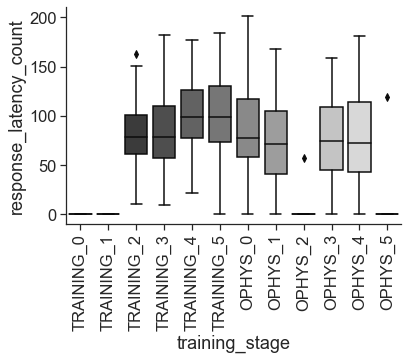

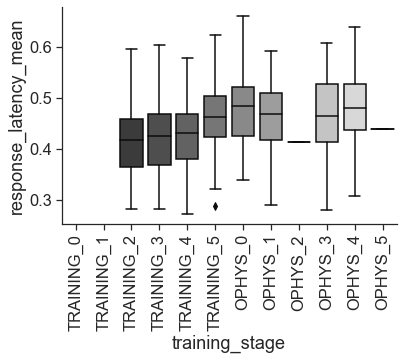

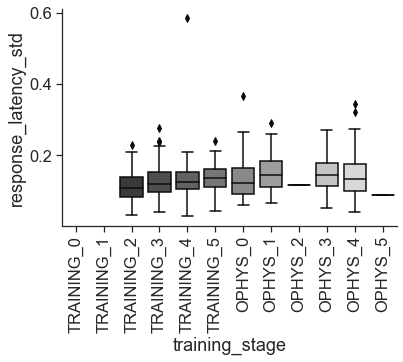

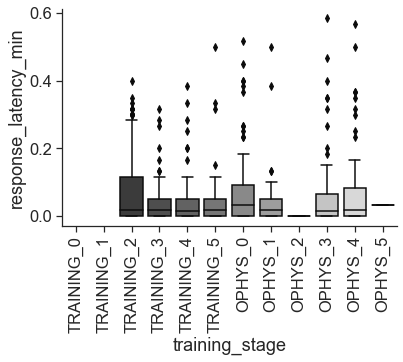

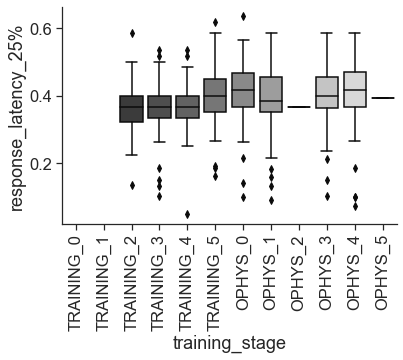

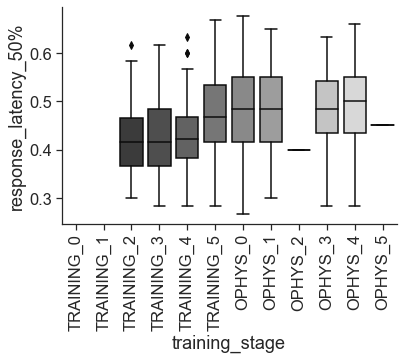

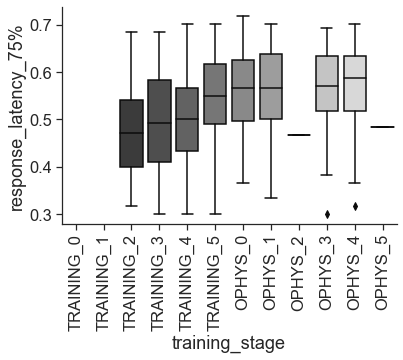

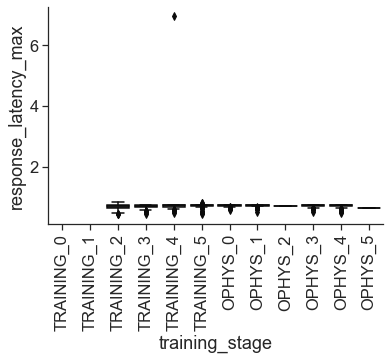

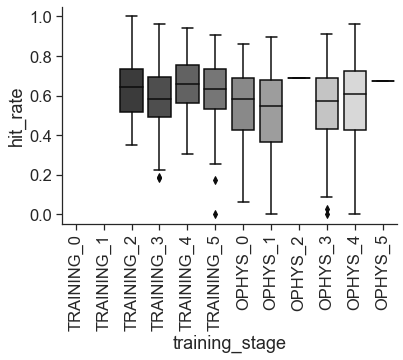

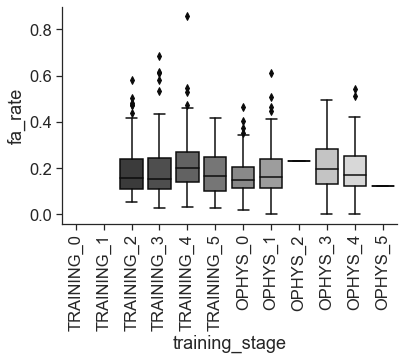

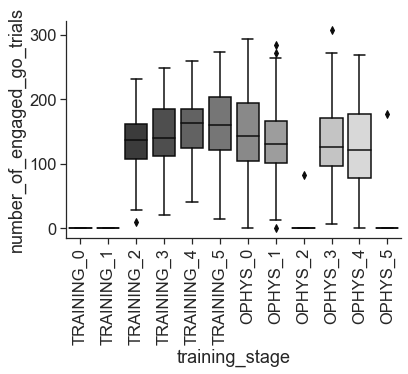

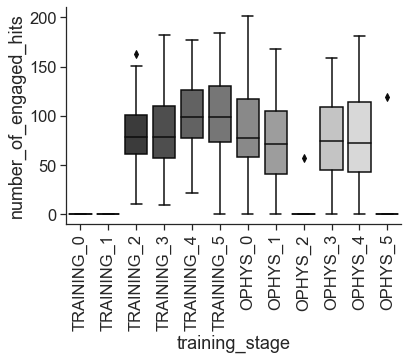

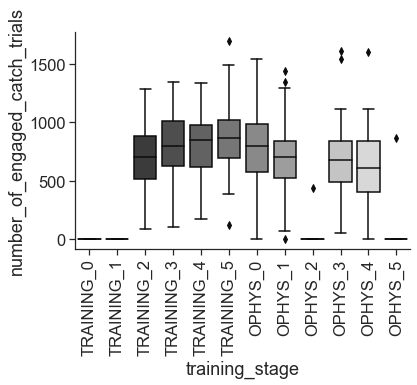

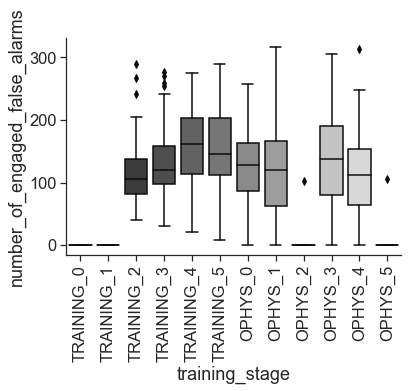

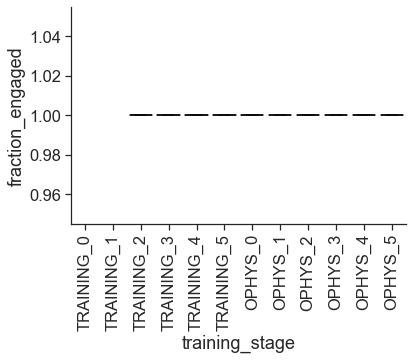

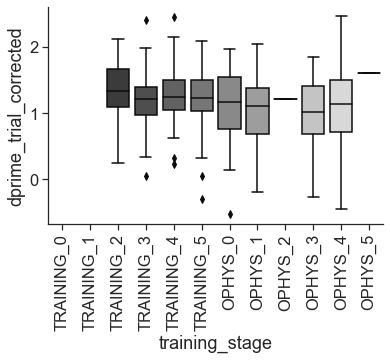

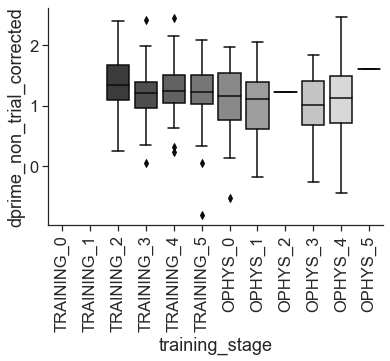

In [23]:
# metric = 'dprime_trial_corrected'

data = behavior_stats[behavior_stats.last_day_of_stage==True]

for metric in metrics: 
    figsize=(6,4)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.boxplot(data=data, x='training_stage', y=metric, order=training_stages, palette='gray', ax=ax)
    ax.set_xticklabels(training_stages, rotation=90);

    utils.save_figure(fig, figsize, save_dir, folder, metric+'boxplot_by_training_stage')

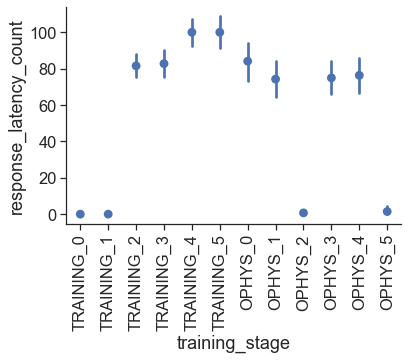

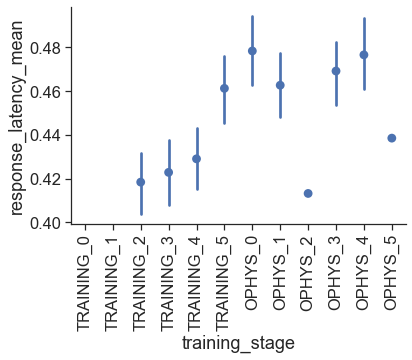

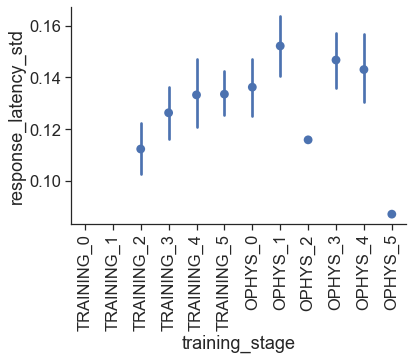

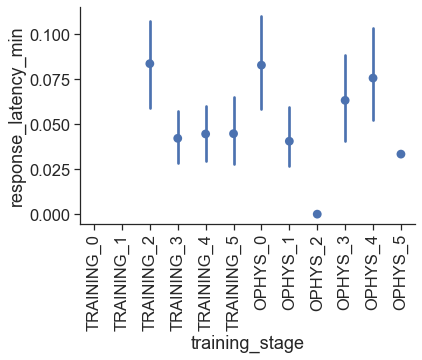

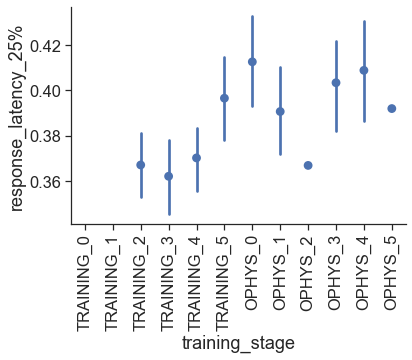

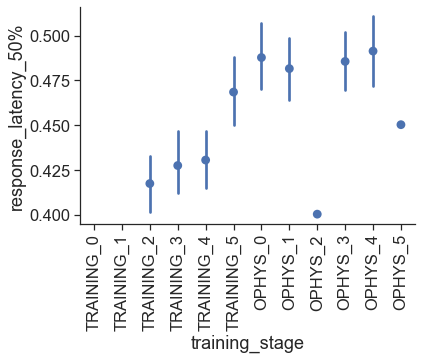

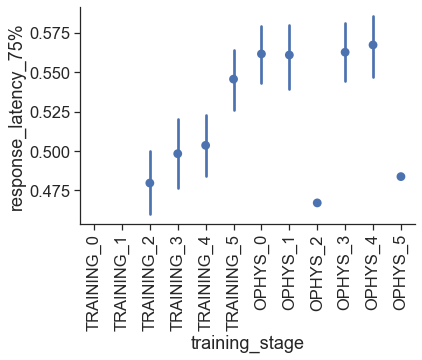

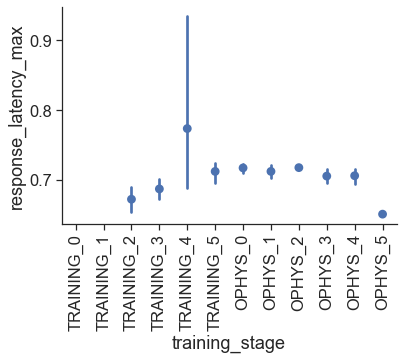

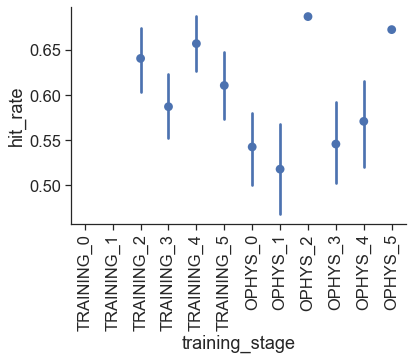

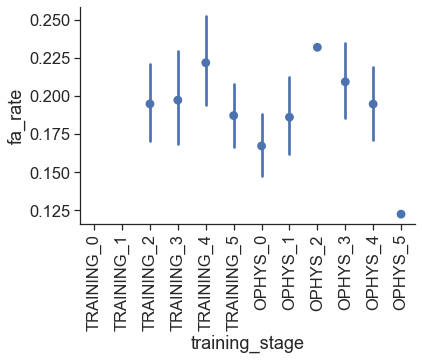

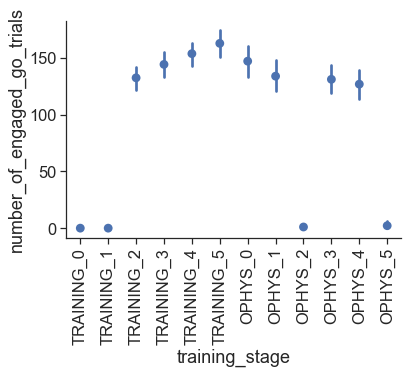

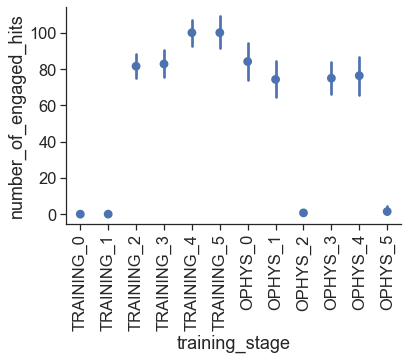

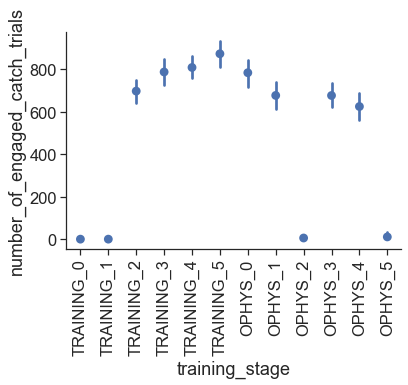

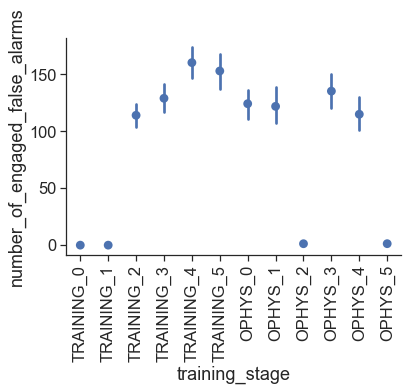

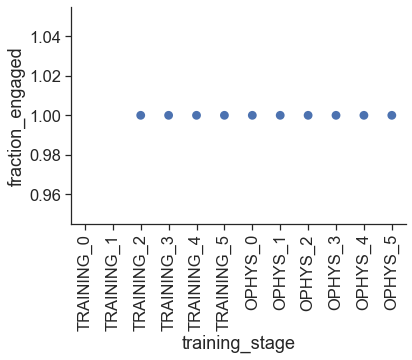

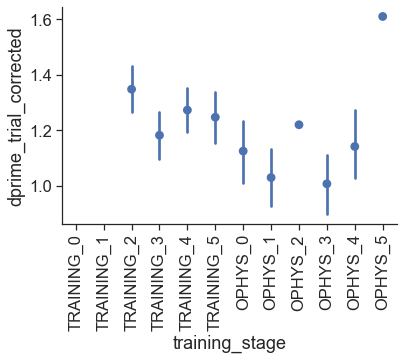

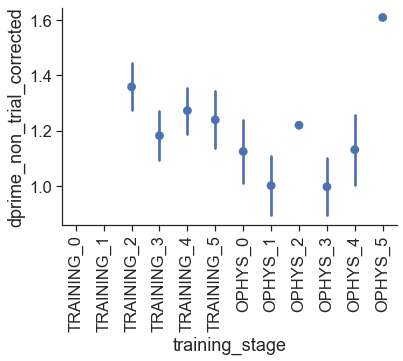

In [24]:
data = behavior_stats[behavior_stats.last_day_of_stage==True]

for metric in metrics:
    figsize=(6,4)
    fig, ax = plt.subplots(figsize=figsize)
    order = np.sort(data['training_stage'].unique())
    ax = sns.pointplot(data=data, x='training_stage', y=metric, order=training_stages, 
                       join=False, ax=ax)
    ax.set_xticklabels(training_stages, rotation=90);
    
    utils.save_figure(fig, figsize, save_dir, folder, metric+'_pointplot_by_training_stage')

### get behavior metrics for each image (instead of for all go/catch trials as above)

In [25]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = True

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


original_behavior_stats = behavior_stats.copy()

  0%|                                                                                         | 0/3667 [00:00<?, ?it/s]

loading for 742008131


  0%|                                                                                 | 3/3667 [00:00<08:01,  7.61it/s]

loading for 742797917
loading for 743041166
loading for 743660302
loading for 744374168


  0%|▏                                                                                | 9/3667 [00:00<03:45, 16.20it/s]

loading for 745054849
loading for 745355000
loading for 745636848
loading for 746222622
loading for 746928360


  0%|▎                                                                               | 12/3667 [00:00<03:16, 18.62it/s]

loading for 750415261
loading for 750781358
loading for 752002559
loading for 753011296
loading for 753936007


  0%|▍                                                                               | 18/3667 [00:01<03:08, 19.36it/s]

loading for 754509820
loading for 754896244
loading for 755551879
loading for 756106020


  1%|▍                                                                               | 21/3667 [00:01<03:02, 19.98it/s]

loading for 756632727
loading for 757431083
loading for 758162988
loading for 758942142
loading for 759251920


  1%|▌                                                                               | 27/3667 [00:01<03:01, 20.06it/s]

loading for 759756829
loading for 760007428
loading for 760409951
loading for 760698062
loading for 761499069


  1%|▋                                                                               | 33/3667 [00:01<02:39, 22.84it/s]

loading for 761831761
loading for 762178061
loading for 762722108
loading for 763291103
loading for 763980798
loading for 764495320


  1%|▊                                                                               | 39/3667 [00:02<02:29, 24.33it/s]

loading for 764897570
loading for 765396393
loading for 766110635
loading for 766753111
loading for 767275980


  1%|▉                                                                               | 42/3667 [00:02<02:29, 24.24it/s]

loading for 768042187
loading for 768815421
loading for 769452637
loading for 769902997
loading for 770244427


  1%|█                                                                               | 48/3667 [00:02<02:30, 24.12it/s]

loading for 771245588
loading for 772125590
loading for 772658979
loading for 773585522
loading for 774106776


  1%|█▏                                                                              | 54/3667 [00:02<02:30, 24.07it/s]

loading for 774373300
loading for 774422914
loading for 774937388
loading for 775378326


  2%|█▏                                                                              | 57/3667 [00:02<02:30, 24.02it/s]

loading for 775870895
loading for 777082591
loading for 778166125
loading for 778980920
loading for 779818630


  2%|█▎                                                                              | 63/3667 [00:03<02:28, 24.29it/s]

loading for 780758836
loading for 782380778
loading for 784156661
loading for 785426306
loading for 785944233
loading for 786920476


  2%|█▍                                                                              | 66/3667 [00:03<02:23, 25.16it/s]

loading for 788017709
loading for 791257562
loading for 791749028
loading for 792499741


  2%|█▌                                                                              | 72/3667 [00:03<02:42, 22.18it/s]

loading for 793129579
loading for 796032489
loading for 760808911
loading for 761294708
loading for 761730617


  2%|█▋                                                                              | 75/3667 [00:03<02:43, 21.91it/s]

loading for 762067130
loading for 762418364
loading for 763012686
loading for 763661704


  2%|█▊                                                                              | 81/3667 [00:03<02:49, 21.12it/s]

loading for 764319580
loading for 764696952
loading for 765208332
loading for 765793356


  2%|█▊                                                                              | 84/3667 [00:04<03:02, 19.63it/s]

loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504


  2%|█▉                                                                              | 89/3667 [00:04<03:13, 18.52it/s]

loading for 769145833
loading for 769731277
loading for 770215042
loading for 771040969


  3%|██                                                                              | 92/3667 [00:04<03:04, 19.33it/s]

loading for 771902184
loading for 772475707
loading for 773391809
loading for 774120511
loading for 774679623


  3%|██▏                                                                             | 98/3667 [00:04<02:45, 21.55it/s]

loading for 775291372
loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859


  3%|██▏                                                                            | 101/3667 [00:04<02:46, 21.48it/s]

loading for 780479408
loading for 781938213
loading for 783217873
loading for 783959068


  3%|██▎                                                                            | 107/3667 [00:05<02:40, 22.24it/s]

loading for 785382040
loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329
loading for 791248943


  3%|██▍                                                                            | 114/3667 [00:05<02:22, 24.96it/s]

loading for 791904071
loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990
loading for 796052844


  3%|██▌                                                                            | 120/3667 [00:05<02:17, 25.82it/s]

loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999
loading for 774208555


  3%|██▋                                                                            | 126/3667 [00:05<02:19, 25.44it/s]

loading for 774767072
loading for 775344511
loading for 775925580
loading for 777061425
loading for 778119826


  4%|██▊                                                                            | 129/3667 [00:06<02:19, 25.30it/s]

loading for 778959204
loading for 779580423
loading for 780351711
loading for 781727422
loading for 783059206


  4%|██▊                                                                            | 132/3667 [00:06<02:24, 24.46it/s]

loading for 783971649
loading for 785376297
loading for 785868918
loading for 786841415


  4%|██▉                                                                            | 138/3667 [00:06<02:42, 21.68it/s]

loading for 788864720
loading for 789946754
loading for 791278700
loading for 791769447
loading for 792477679


  4%|███                                                                            | 144/3667 [00:06<02:37, 22.42it/s]

loading for 793153175
loading for 794071128
loading for 794673280
loading for 795431009
loading for 796031509


  4%|███▏                                                                           | 147/3667 [00:06<02:37, 22.36it/s]

loading for 797170547
loading for 776156839
loading for 777417642
loading for 778884020
loading for 779111633


  4%|███▎                                                                           | 153/3667 [00:07<02:43, 21.52it/s]

loading for 780002890
loading for 780766304
loading for 783413166
loading for 784173223
loading for 785539951


  4%|███▍                                                                           | 159/3667 [00:07<02:38, 22.18it/s]

loading for 786305627
loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254


  4%|███▍                                                                           | 162/3667 [00:07<02:38, 22.18it/s]

loading for 792661903
loading for 793323654
loading for 794275479
loading for 794953909
loading for 795838927


  5%|███▋                                                                           | 169/3667 [00:07<02:19, 25.14it/s]

loading for 796046197
loading for 796233602
loading for 796607829
loading for 798145975
loading for 798679618
loading for 799661667
loading for 800202171


  5%|███▊                                                                           | 175/3667 [00:08<02:13, 26.21it/s]

loading for 802406837
loading for 802922968
loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108


  5%|███▉                                                                           | 182/3667 [00:08<02:05, 27.78it/s]

loading for 807198458
loading for 808107647
loading for 809321253
loading for 791877093
loading for 792689261
loading for 793414389
loading for 794295959


  5%|████                                                                           | 188/3667 [00:08<02:13, 26.12it/s]

loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316
loading for 800299366


  5%|████▏                                                                          | 194/3667 [00:08<02:44, 21.13it/s]

loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649


  5%|████▏                                                                          | 197/3667 [00:08<02:44, 21.11it/s]

loading for 805535249
loading for 806109931
loading for 806792366
loading for 807356557
loading for 808324301


  6%|████▎                                                                          | 203/3667 [00:09<02:30, 23.03it/s]

loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256


  6%|████▍                                                                          | 206/3667 [00:09<02:32, 22.67it/s]

loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295


  6%|████▌                                                                          | 212/3667 [00:09<02:47, 20.59it/s]

loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383


  6%|████▋                                                                          | 215/3667 [00:09<02:45, 20.89it/s]

loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362


  6%|████▋                                                                          | 220/3667 [00:10<03:22, 17.04it/s]

loading for 800919728
loading for 802364085
loading for 802988119
loading for 803347004


  6%|████▊                                                                          | 225/3667 [00:10<03:06, 18.49it/s]

loading for 805639780
loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167


  6%|████▉                                                                          | 231/3667 [00:10<02:49, 20.22it/s]

loading for 809027309
loading for 809427293
loading for 811355443
loading for 810584641


  6%|█████                                                                          | 234/3667 [00:10<02:41, 21.29it/s]

loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618


  7%|█████▏                                                                         | 240/3667 [00:11<02:35, 22.05it/s]

loading for 814546737
loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147


  7%|█████▎                                                                         | 245/3667 [00:11<03:33, 16.05it/s]

loading for 819990491
loading for 821803380
loading for 822409353


  7%|█████▎                                                                         | 248/3667 [00:11<03:15, 17.51it/s]

loading for 823241007
loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541


  7%|█████▍                                                                         | 253/3667 [00:11<03:08, 18.10it/s]

loading for 826697158
loading for 827374757
loading for 828646658
loading for 829138845


  7%|█████▌                                                                         | 260/3667 [00:12<02:27, 23.05it/s]

loading for 829578829
loading for 830255592
loading for 830832988
loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832


  7%|█████▋                                                                         | 266/3667 [00:12<02:16, 24.88it/s]

loading for 836399024
loading for 807533658
loading for 808488955
loading for 809095689
loading for 809427297


  7%|█████▊                                                                         | 269/3667 [00:12<02:22, 23.80it/s]

loading for 809815041
loading for 810598880
loading for 811354008
loading for 811830102
loading for 812559803


  8%|█████▉                                                                         | 277/3667 [00:12<01:58, 28.67it/s]

loading for 813041953
loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256
loading for 817165094
loading for 818007489


  8%|██████                                                                         | 282/3667 [00:12<01:42, 33.15it/s]

cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655


  8%|██████▏                                                                        | 286/3667 [00:13<03:01, 18.58it/s]

loading for 822439453
loading for 823254723
loading for 824894721
loading for 807062523


  8%|██████▏                                                                        | 289/3667 [00:13<03:04, 18.30it/s]

loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660


  8%|██████▎                                                                        | 295/3667 [00:13<02:49, 19.89it/s]

loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983
loading for 814749891


  8%|██████▍                                                                        | 301/3667 [00:14<02:39, 21.16it/s]

loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377
loading for 819497998


  8%|██████▌                                                                        | 304/3667 [00:14<02:38, 21.20it/s]

loading for 820740400
loading for 821593979
loading for 822159346
loading for 822874578
loading for 823496226


  8%|██████▌                                                                        | 307/3667 [00:14<02:33, 21.96it/s]

loading for 824566587


  9%|██████▋                                                                        | 313/3667 [00:14<03:11, 17.50it/s]

loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593


  9%|██████▊                                                                        | 317/3667 [00:14<02:40, 20.92it/s]

loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  9%|██████▉                                                                        | 324/3667 [00:15<02:29, 22.35it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110
loading for 837512169


  9%|███████                                                                        | 330/3667 [00:15<02:19, 23.89it/s]

loading for 823922942
loading for 824972176
loading for 825527066
loading for 826338809
loading for 826841473


  9%|███████▏                                                                       | 333/3667 [00:15<02:15, 24.55it/s]

loading for 827977069
loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963


  9%|███████▎                                                                       | 339/3667 [00:15<02:17, 24.28it/s]

loading for 832009551
loading for 832522789
loading for 833252272
loading for 834059775
loading for 834886139


  9%|███████▍                                                                       | 345/3667 [00:16<02:14, 24.61it/s]

loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869


  9%|███████▍                                                                       | 348/3667 [00:16<02:20, 23.67it/s]

loading for 838486964
loading for 839220840
loading for 839566028
loading for 839918083
loading for 840583412


 10%|███████▋                                                                       | 354/3667 [00:16<02:18, 23.85it/s]

loading for 841431760
loading for 841830077
loading for 842387217
loading for 842821314
loading for 843397714


 10%|███████▊                                                                       | 360/3667 [00:16<02:20, 23.56it/s]

loading for 844197868
loading for 844880686
loading for 845564445
loading for 846272622
loading for 847022155


 10%|███████▊                                                                       | 365/3667 [00:17<03:24, 16.17it/s]

loading for 847829598
loading for 848519645
loading for 849073265
loading for 849635376


 10%|███████▉                                                                       | 368/3667 [00:17<02:57, 18.61it/s]

loading for 850977753
loading for 851779746
loading for 852468381
loading for 853168204
loading for 853875502
loading for 854563857


 10%|████████                                                                       | 375/3667 [00:17<02:25, 22.55it/s]

loading for 855421865
loading for 855973498
loading for 856717282
loading for 857612105
loading for 859065627
loading for 859735311


 10%|████████▏                                                                      | 382/3667 [00:17<02:09, 25.41it/s]

loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911
loading for 864824449
loading for 865482857
loading for 866333758


 10%|████████▎                                                                      | 385/3667 [00:18<03:26, 15.89it/s]

loading for 867041502
loading for 867977775
loading for 868721114
loading for 869639141


 11%|████████▍                                                                      | 391/3667 [00:18<03:08, 17.42it/s]

loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118


 11%|████████▌                                                                      | 397/3667 [00:18<02:42, 20.12it/s]

loading for 875414332
loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068


 11%|████████▌                                                                      | 400/3667 [00:18<02:35, 21.03it/s]

loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127
loading for 882748184


 11%|████████▋                                                                      | 406/3667 [00:19<02:12, 24.55it/s]

loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012
loading for 890157940


 11%|████████▉                                                                      | 412/3667 [00:19<02:18, 23.55it/s]

loading for 820799656
loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950


 11%|█████████                                                                      | 418/3667 [00:19<02:18, 23.53it/s]

loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014


 11%|█████████                                                                      | 421/3667 [00:19<02:18, 23.46it/s]

loading for 828838236
loading for 829282785
loading for 829877552
loading for 830620126
loading for 832019583


 12%|█████████▏                                                                     | 428/3667 [00:19<02:14, 24.10it/s]

loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885


 12%|█████████▎                                                                     | 432/3667 [00:20<02:07, 25.43it/s]

loading for 836777468
loading for 837196627
loading for 837647722
loading for 838496122


 12%|█████████▍                                                                     | 438/3667 [00:20<02:59, 17.99it/s]

loading for 839233516
loading for 839566049
loading for 839931485
loading for 840594518


 12%|█████████▌                                                                     | 441/3667 [00:20<02:44, 19.67it/s]

loading for 841429687
loading for 841842210
loading for 842399625
loading for 842844413
loading for 843400443
loading for 844253929


 12%|█████████▋                                                                     | 447/3667 [00:20<02:21, 22.80it/s]

loading for 845585105
loading for 846316916
loading for 847036338
loading for 847871771
loading for 848599542
loading for 849136474


 12%|█████████▊                                                                     | 453/3667 [00:21<02:05, 25.56it/s]

loading for 849648618
loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851


 13%|█████████▉                                                                     | 459/3667 [00:21<02:17, 23.32it/s]

loading for 828646634
loading for 829128279
loading for 829591790
loading for 830201482
loading for 830867799


 13%|██████████                                                                     | 465/3667 [00:21<02:12, 24.09it/s]

loading for 831834820
loading for 832325815
loading for 832990071
loading for 833780803
loading for 834573980


 13%|██████████                                                                     | 468/3667 [00:21<02:15, 23.61it/s]

loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666


 13%|██████████▏                                                                    | 474/3667 [00:22<02:31, 21.14it/s]

loading for 837443225
loading for 838236165
loading for 839014738
loading for 839479248
loading for 839854553


 13%|██████████▎                                                                    | 480/3667 [00:22<02:18, 23.09it/s]

loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100


 13%|██████████▍                                                                    | 483/3667 [00:22<02:15, 23.52it/s]

loading for 843166865
loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485


 13%|██████████▌                                                                    | 489/3667 [00:22<02:03, 25.79it/s]

loading for 847867029
loading for 848575992
loading for 849098851
loading for 850976604
loading for 853266283
loading for 831129394
loading for 832021447


 13%|██████████▋                                                                    | 495/3667 [00:22<01:57, 26.94it/s]

loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296
loading for 836166694


 14%|██████████▊                                                                    | 501/3667 [00:23<01:56, 27.20it/s]

loading for 836761653
loading for 837192567
loading for 837638916
loading for 838496126
loading for 839234289
loading for 839566045


 14%|██████████▉                                                                    | 507/3667 [00:23<01:55, 27.32it/s]

loading for 839939986
loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895


 14%|███████████                                                                    | 513/3667 [00:23<02:00, 26.25it/s]

loading for 843203333
loading for 844164376
loading for 844849972
loading for 845441512
loading for 846194950


 14%|███████████▏                                                                   | 519/3667 [00:23<01:57, 26.83it/s]

loading for 846929750
loading for 848503804
loading for 853526948
loading for 834587823
loading for 835451471
loading for 835867850


 14%|███████████▎                                                                   | 525/3667 [00:24<02:13, 23.46it/s]

loading for 836522245
loading for 837083657
loading for 837449223
loading for 838203784


 14%|███████████▎                                                                   | 528/3667 [00:24<02:22, 22.00it/s]

loading for 838998362
loading for 839468826
loading for 839837380
loading for 840330501
loading for 841191836


 15%|███████████▌                                                                   | 534/3667 [00:24<02:15, 23.16it/s]

loading for 841730868
loading for 842139310
loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277


 15%|███████████▌                                                                   | 538/3667 [00:24<02:06, 24.82it/s]

loading for 845409652
loading for 846051276
loading for 846791195
loading for 847613846
loading for 848272657


 15%|███████████▋                                                                   | 544/3667 [00:24<02:21, 22.02it/s]

loading for 848938321
loading for 849525884
loading for 850817466
loading for 851563931


 15%|███████████▊                                                                   | 547/3667 [00:25<02:27, 21.11it/s]

loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407


 15%|███████████▉                                                                   | 553/3667 [00:25<02:23, 21.66it/s]

loading for 855826937
loading for 857230827
loading for 837658854
loading for 838515247
loading for 839219841


 15%|███████████▉                                                                   | 556/3667 [00:25<02:24, 21.55it/s]

loading for 839565422
loading for 839912316
loading for 840581827
loading for 841426832
loading for 841827774


 15%|████████████                                                                   | 562/3667 [00:25<02:21, 21.89it/s]

loading for 842385277
loading for 842819933
loading for 843400453
loading for 844199758
loading for 844908261


 15%|████████████▏                                                                  | 568/3667 [00:25<02:17, 22.56it/s]

loading for 845572044
loading for 846331423
loading for 847036328
loading for 847874940
loading for 848613406


 16%|████████████▎                                                                  | 571/3667 [00:26<02:19, 22.12it/s]

loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928


 16%|████████████▍                                                                  | 577/3667 [00:26<02:23, 21.47it/s]

loading for 852451567
loading for 855200229
loading for 837654533
loading for 838483140
loading for 839219845
loading for 839565426


 16%|████████████▌                                                                  | 583/3667 [00:26<02:11, 23.45it/s]

loading for 839914270
loading for 840581823
loading for 841426857
loading for 841830096
loading for 842385266


 16%|████████████▌                                                                  | 586/3667 [00:26<02:05, 24.50it/s]

loading for 842819929
loading for 843401580
loading for 844199766
loading for 844891885
loading for 845572039


 16%|████████████▊                                                                  | 592/3667 [00:27<02:06, 24.25it/s]

loading for 846016059
loading for 846750050
loading for 847660741
loading for 848348215
loading for 848943191


 16%|████████████▉                                                                  | 598/3667 [00:27<02:03, 24.79it/s]

loading for 849494762
loading for 850807174
loading for 851542477
loading for 852229360
loading for 853025613


 16%|█████████████                                                                  | 604/3667 [00:27<02:02, 25.07it/s]

loading for 855446545
loading for 855866701
loading for 856467236
loading for 857367017
loading for 858029487


 17%|█████████████                                                                  | 607/3667 [00:27<01:58, 25.72it/s]

loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649
loading for 840598877
loading for 841466830


 17%|█████████████▏                                                                 | 613/3667 [00:27<01:59, 25.56it/s]

loading for 841851097
loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895


 17%|█████████████▎                                                                 | 619/3667 [00:28<01:55, 26.42it/s]

loading for 844945060
loading for 845594684
loading for 846284880
loading for 847048490
loading for 847838131
loading for 848526511


 17%|█████████████▍                                                                 | 625/3667 [00:28<01:52, 26.92it/s]

loading for 848910243
loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248
loading for 853875514


 17%|█████████████▌                                                                 | 631/3667 [00:28<01:55, 26.40it/s]

loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666
loading for 858974731
loading for 859775117


 17%|█████████████▋                                                                 | 638/3667 [00:28<01:50, 27.38it/s]

loading for 863610582
loading for 868070216
loading for 868658294
loading for 869559097
loading for 850978904
loading for 851802107


 18%|█████████████▊                                                                 | 644/3667 [00:28<01:54, 26.31it/s]

loading for 852457995
loading for 853257103
loading for 853793068
loading for 854602288
loading for 855476794
loading for 856010720


 18%|██████████████                                                                 | 650/3667 [00:29<01:52, 26.86it/s]

loading for 856732195
loading for 857547928
loading for 858273959
loading for 859054070
loading for 859802280
loading for 860894659


 18%|██████████████▏                                                                | 656/3667 [00:29<01:54, 26.22it/s]

loading for 861794694
loading for 862716894
loading for 863559318
loading for 864280264
loading for 865544821
loading for 866336764


 18%|██████████████▎                                                                | 662/3667 [00:29<01:54, 26.14it/s]

loading for 867098393
loading for 867945660
loading for 868819048
loading for 869621595
loading for 870960908


 18%|██████████████▍                                                                | 668/3667 [00:29<01:56, 25.69it/s]

loading for 872107505
loading for 873813922
loading for 874808131
loading for 876821717
loading for 854533487


 18%|██████████████▍                                                                | 671/3667 [00:30<02:05, 23.83it/s]

loading for 855504136
loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891
loading for 859032026


 18%|██████████████▌                                                                | 677/3667 [00:30<03:04, 16.18it/s]

loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054


 19%|██████████████▋                                                                | 683/3667 [00:30<02:35, 19.20it/s]

loading for 864137547
loading for 864839176
loading for 865581941
loading for 866287088
loading for 866950070


 19%|██████████████▊                                                                | 686/3667 [00:31<03:26, 14.42it/s]

loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378


 19%|██████████████▉                                                                | 692/3667 [00:31<02:52, 17.26it/s]

loading for 872646068
loading for 873517635
loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139


 19%|███████████████                                                                | 697/3667 [00:31<03:14, 15.28it/s]

loading for 850970486
loading for 851843550
loading for 852507945
loading for 853260939
loading for 853886146
loading for 855459012


 19%|███████████████▏                                                               | 706/3667 [00:32<02:14, 22.05it/s]

loading for 855980937
loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 19%|███████████████▎                                                               | 709/3667 [00:32<02:08, 23.10it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836
loading for 864260028
loading for 864813130


 19%|███████████████▍                                                               | 715/3667 [00:32<02:06, 23.41it/s]

loading for 865460179
loading for 866296478
loading for 866999677
loading for 867615541
loading for 868555361


 20%|███████████████▍                                                               | 718/3667 [00:32<02:19, 21.18it/s]

loading for 869334643
loading for 870592115
loading for 871808394
loading for 872626160


 20%|███████████████▌                                                               | 724/3667 [00:33<02:18, 21.22it/s]

loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747


 20%|███████████████▋                                                               | 730/3667 [00:33<02:05, 23.46it/s]

loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794
loading for 882256117
loading for 854528256


 20%|███████████████▊                                                               | 736/3667 [00:33<02:00, 24.33it/s]

loading for 855503335
loading for 856002613
loading for 856732213
loading for 857555461
loading for 858240896


 20%|███████████████▉                                                               | 739/3667 [00:33<02:14, 21.79it/s]

loading for 859032044
loading for 859791563
loading for 860752819
loading for 861794704
loading for 862701503


 20%|████████████████                                                               | 746/3667 [00:33<01:56, 25.14it/s]

loading for 863559327
loading for 864125430
loading for 864839160
loading for 865580429
loading for 866287143
loading for 867082086


 21%|████████████████▏                                                              | 752/3667 [00:34<01:51, 26.22it/s]

loading for 868004770
loading for 868747797
loading for 872158938
loading for 873015934
loading for 873824951
loading for 874747892
loading for 875444395


 21%|████████████████▎                                                              | 758/3667 [00:34<02:32, 19.06it/s]

loading for 876857698
loading for 878159171
loading for 879037253
loading for 880201859
loading for 880776648
loading for 881413102


 21%|████████████████▍                                                              | 764/3667 [00:34<02:15, 21.43it/s]

loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160
loading for 885644181


 21%|████████████████▌                                                              | 771/3667 [00:35<01:55, 25.16it/s]

loading for 886440437
loading for 887165432
loading for 888282547
loading for 858104885
loading for 858900546
loading for 859601488
loading for 860247669


 21%|████████████████▋                                                              | 777/3667 [00:35<01:50, 26.22it/s]

loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979
loading for 864665192
loading for 865114696


 21%|████████████████▊                                                              | 780/3667 [00:35<01:53, 25.53it/s]

loading for 865887829
loading for 866906696


 21%|████████████████▊                                                              | 783/3667 [00:35<03:05, 15.56it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699
loading for 871723063


 22%|████████████████▉                                                              | 789/3667 [00:36<02:36, 18.37it/s]

loading for 872607293
loading for 873440431
loading for 874324527
loading for 875020211
loading for 876448536


 22%|█████████████████▏                                                             | 795/3667 [00:36<02:22, 20.20it/s]

loading for 877855866
loading for 878615859
loading for 879846629
loading for 880581639


 22%|█████████████████▏                                                             | 798/3667 [00:36<02:19, 20.51it/s]

loading for 881204796
loading for 882289836
loading for 883851453
loading for 884598044
loading for 885404075


 22%|█████████████████▎                                                             | 801/3667 [00:36<02:26, 19.51it/s]

loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730
loading for 894103623


 22%|█████████████████▍                                                             | 809/3667 [00:36<01:59, 23.86it/s]

loading for 895022326
loading for 895562386
loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684


 22%|█████████████████▌                                                             | 815/3667 [00:37<01:55, 24.76it/s]

loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625
loading for 907053876
loading for 907900077


 22%|█████████████████▋                                                             | 822/3667 [00:37<01:48, 26.31it/s]

loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263
loading for 914705301


 23%|█████████████████▊                                                             | 828/3667 [00:37<02:32, 18.58it/s]

loading for 915418411
loading for 916403851
loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998


 23%|█████████████████▉                                                             | 835/3667 [00:38<02:05, 22.57it/s]

loading for 858098100
loading for 858891746
loading for 859601496
loading for 860247677
loading for 861715805


 23%|██████████████████                                                             | 838/3667 [00:38<02:07, 22.20it/s]

loading for 862326321
loading for 863361852
loading for 863966966
loading for 864656758
loading for 865114705


 23%|██████████████████▏                                                            | 844/3667 [00:38<01:58, 23.90it/s]

loading for 865883182
loading for 866912923
loading for 867553178
loading for 868521085
loading for 869223965
loading for 870473396


 23%|██████████████████▎                                                            | 850/3667 [00:38<01:56, 24.25it/s]

loading for 871723073
loading for 872607297
loading for 873440438
loading for 874324523
loading for 875020169
loading for 877447964


 23%|██████████████████▍                                                            | 856/3667 [00:38<01:51, 25.30it/s]

loading for 878282369
loading for 880231156
loading for 880780889
loading for 881427978
loading for 882434675
loading for 882827577


 24%|██████████████████▌                                                            | 862/3667 [00:39<01:46, 26.34it/s]

loading for 884888379
loading for 885739915
loading for 886446971
loading for 887236947
loading for 888301437
loading for 889559462


 24%|██████████████████▋                                                            | 868/3667 [00:39<01:55, 24.13it/s]

loading for 890374401
loading for 891792255
loading for 892663103
loading for 893600606
loading for 858098096


 24%|██████████████████▊                                                            | 872/3667 [00:39<01:45, 26.53it/s]

loading for 859064345
loading for 859735301
loading for 860650174
loading for 861785387
loading for 862752139
loading for 863571063


 24%|██████████████████▉                                                            | 878/3667 [00:39<01:47, 25.92it/s]

loading for 864137543
loading for 864820740
loading for 865463877
loading for 866319121
loading for 867036286


 24%|███████████████████                                                            | 884/3667 [00:39<01:44, 26.65it/s]

loading for 867961842
loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204
loading for 872979404


 24%|███████████████████▏                                                           | 891/3667 [00:40<01:43, 26.77it/s]

loading for 873733206
loading for 874654275
loading for 875385898
loading for 876737438
loading for 877558819


 24%|███████████████████▎                                                           | 894/3667 [00:40<01:40, 27.46it/s]

loading for 878233751
loading for 879003588
loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175


 25%|███████████████████▍                                                           | 900/3667 [00:40<01:44, 26.36it/s]

loading for 883857874
loading for 884800923
loading for 885589846
loading for 886437461
loading for 887183674
loading for 888263147


 25%|███████████████████▌                                                           | 907/3667 [00:40<01:40, 27.47it/s]

loading for 889436433
loading for 890459182
loading for 891759060
loading for 892589687
loading for 893433252
loading for 894215832


 25%|███████████████████▋                                                           | 913/3667 [00:41<01:43, 26.74it/s]

loading for 896543695
loading for 898493295
loading for 898889632
loading for 899400259
loading for 900228074


 25%|███████████████████▋                                                           | 916/3667 [00:41<01:40, 27.44it/s]

loading for 901102440
loading for 902021938
loading for 902822517
loading for 904630713
loading for 907035941


 25%|███████████████████▊                                                           | 922/3667 [00:41<01:48, 25.29it/s]

loading for 907995409
loading for 908564883
loading for 909363995
loading for 910249989
loading for 911361470
loading for 911947271


 25%|███████████████████▉                                                           | 928/3667 [00:41<01:45, 26.08it/s]

loading for 912570316
loading for 913710476
loading for 914230230
loading for 914715937
loading for 915448786


 25%|████████████████████                                                           | 934/3667 [00:41<01:47, 25.38it/s]

loading for 916450856
loading for 917331220
loading for 918202290
loading for 918900907
loading for 919634924
loading for 920541932


 26%|████████████████████▎                                                          | 940/3667 [00:42<01:56, 23.38it/s]

loading for 921601457
loading for 922572837
loading for 923474474
loading for 924575646


 26%|████████████████████▎                                                          | 943/3667 [00:42<01:50, 24.63it/s]

loading for 925033179
loading for 926393722
loading for 927449068
loading for 928400507
loading for 929341697
loading for 929818797


 26%|████████████████████▍                                                          | 949/3667 [00:42<01:44, 26.09it/s]

loading for 931566300
loading for 932611698
loading for 933504759
loading for 934610593
loading for 935811563
loading for 937416292


 26%|████████████████████▌                                                          | 957/3667 [00:42<01:30, 30.05it/s]

loading for 938377224
loading for 939538572
loading for 862786889
loading for 863627986
loading for 864248647
loading for 865463863
loading for 866103829


 26%|████████████████████▋                                                          | 961/3667 [00:42<01:35, 28.44it/s]

loading for 867056914
loading for 868008761
loading for 868709715
loading for 871033938
loading for 872127292
loading for 873051801


 26%|████████████████████▊                                                          | 968/3667 [00:43<01:40, 26.83it/s]

loading for 873781580
loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747


 27%|████████████████████▉                                                          | 974/3667 [00:43<02:17, 19.62it/s]

loading for 878282360
loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102
loading for 882388591


 27%|█████████████████████                                                          | 980/3667 [00:43<02:00, 22.28it/s]

loading for 883704230
loading for 884677929
loading for 886239982
loading for 886873295
loading for 889155682
loading for 890051221


 27%|█████████████████████▏                                                         | 986/3667 [00:44<01:50, 24.23it/s]

loading for 891487953
loading for 892410834
loading for 893356870
loading for 894209378
loading for 894987969
loading for 896526348


 27%|█████████████████████▎                                                         | 989/3667 [00:44<01:48, 24.77it/s]

loading for 898453640
loading for 898889612
loading for 899452222
loading for 901380774


 27%|█████████████████████▍                                                         | 995/3667 [00:44<01:55, 23.15it/s]

loading for 902270195
loading for 903070554
loading for 904011865
loading for 906695544
loading for 907356161


 27%|█████████████████████▎                                                        | 1001/3667 [00:44<01:57, 22.73it/s]

loading for 908908617
loading for 911021831
loading for 911522814
loading for 912242958
loading for 912918028


 27%|█████████████████████▎                                                        | 1004/3667 [00:44<02:11, 20.19it/s]

loading for 913898214
loading for 914405292
loading for 914868296
loading for 915690421
loading for 916623819


 28%|█████████████████████▍                                                        | 1010/3667 [00:45<02:07, 20.76it/s]

loading for 917581144
loading for 918454518
loading for 919073273
loading for 919973223
loading for 920836124


 28%|█████████████████████▌                                                        | 1016/3667 [00:45<02:00, 22.07it/s]

loading for 921879374
loading for 922942074
loading for 923786645
loading for 924729242
loading for 926769977


 28%|█████████████████████▋                                                        | 1019/3667 [00:45<01:56, 22.80it/s]

loading for 927745870
loading for 928717396
loading for 929524399
loading for 932078145
loading for 932975404


 28%|█████████████████████▊                                                        | 1025/3667 [00:45<01:46, 24.79it/s]

loading for 934075944
loading for 934900274
loading for 936033313
loading for 937825662
loading for 938991494
loading for 940243685


 28%|█████████████████████▉                                                        | 1032/3667 [00:46<01:37, 27.13it/s]

loading for 940796859
loading for 941946991
loading for 942448113
loading for 945277725
loading for 946172858
loading for 947503956


 28%|██████████████████████                                                        | 1040/3667 [00:46<01:28, 29.68it/s]

loading for 948341757
loading for 862479694
loading for 863414647
loading for 864000195
loading for 864729508
loading for 865288307


 28%|██████████████████████▏                                                       | 1043/3667 [00:46<01:30, 29.03it/s]

loading for 865953304
loading for 866971252
loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103


 29%|██████████████████████▎                                                       | 1049/3667 [00:46<01:36, 27.13it/s]

loading for 871782387
loading for 872720256
loading for 873530279
loading for 874295478
loading for 875020129
loading for 876521253


 29%|██████████████████████▍                                                       | 1056/3667 [00:46<01:34, 27.53it/s]

loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654
loading for 880647168
loading for 881253316


 29%|██████████████████████▌                                                       | 1062/3667 [00:47<01:37, 26.70it/s]

loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033
loading for 885418521


 29%|██████████████████████▋                                                       | 1068/3667 [00:47<01:38, 26.31it/s]

loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551
loading for 891504476


 29%|██████████████████████▊                                                       | 1071/3667 [00:47<01:38, 26.48it/s]

loading for 892413871
loading for 893359124
loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372


 29%|██████████████████████▉                                                       | 1077/3667 [00:47<01:44, 24.78it/s]

loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538
loading for 904625819


 30%|███████████████████████                                                       | 1083/3667 [00:47<01:40, 25.74it/s]

loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486
loading for 912159483


 30%|███████████████████████▏                                                      | 1089/3667 [00:48<01:38, 26.12it/s]

loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634
loading for 917595407


 30%|███████████████████████▎                                                      | 1096/3667 [00:48<01:31, 28.19it/s]

loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852
loading for 924759623


 30%|███████████████████████▍                                                      | 1100/3667 [00:48<01:28, 29.13it/s]

loading for 925603486
loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050


 30%|███████████████████████▌                                                      | 1107/3667 [00:48<02:01, 21.06it/s]

loading for 863657189
loading for 864236370
loading for 864809053
loading for 865443418


 30%|███████████████████████▋                                                      | 1113/3667 [00:49<02:46, 15.35it/s]

loading for 866300303
loading for 867045079
loading for 867977763
loading for 868704504
loading for 869615887


 30%|███████████████████████▋                                                      | 1116/3667 [00:49<02:25, 17.57it/s]

loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139
loading for 875402170
loading for 876701397


 31%|███████████████████████▊                                                      | 1122/3667 [00:49<01:58, 21.41it/s]

loading for 877524045
loading for 878137744
loading for 879003593
loading for 880088387
loading for 881416618
loading for 882373648


 31%|███████████████████████▉                                                      | 1128/3667 [00:50<01:49, 23.20it/s]

loading for 882785348
loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427


 31%|████████████████████████                                                      | 1134/3667 [00:50<01:42, 24.59it/s]

loading for 886931452
loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402


 31%|████████████████████████▏                                                     | 1140/3667 [00:50<01:41, 24.95it/s]

loading for 893540605
loading for 894466746
loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063


 31%|████████████████████████▍                                                     | 1147/3667 [00:50<01:38, 25.61it/s]

loading for 899685557
loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312


 31%|████████████████████████▍                                                     | 1150/3667 [00:50<01:43, 24.27it/s]

loading for 904899490
loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296


 32%|████████████████████████▌                                                     | 1157/3667 [00:51<01:40, 24.91it/s]

loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195


 32%|████████████████████████▋                                                     | 1161/3667 [00:51<01:36, 26.01it/s]

loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985


 32%|████████████████████████▊                                                     | 1168/3667 [00:51<01:30, 27.60it/s]

loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793
loading for 927652117
loading for 928654503


 32%|████████████████████████▉                                                     | 1174/3667 [00:51<01:30, 27.52it/s]

loading for 929522558
loading for 930344462
loading for 932960096
loading for 933939891
loading for 935038748
loading for 936159430


 32%|█████████████████████████                                                     | 1178/3667 [00:51<01:26, 28.94it/s]

loading for 937645038
loading for 938729036
loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533


 32%|█████████████████████████▏                                                    | 1186/3667 [00:52<01:23, 29.74it/s]

loading for 945033994
loading for 947336783
loading for 948225040
loading for 949348713
loading for 950188644
loading for 862245493
loading for 863368489


 33%|█████████████████████████▍                                                    | 1194/3667 [00:52<01:23, 29.75it/s]

loading for 863966974
loading for 864665204
loading for 865131331
loading for 865887821
loading for 866909432


 33%|█████████████████████████▍                                                    | 1197/3667 [00:52<01:28, 28.06it/s]

loading for 867521015
loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185


 33%|█████████████████████████▌                                                    | 1200/3667 [00:52<01:30, 27.24it/s]

loading for 873449838
loading for 874333572


 33%|█████████████████████████▋                                                    | 1206/3667 [00:53<02:13, 18.48it/s]

loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867


 33%|█████████████████████████▋                                                    | 1209/3667 [00:53<02:05, 19.63it/s]

loading for 879854787
loading for 880590869
loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883


 33%|█████████████████████████▊                                                    | 1215/3667 [00:53<01:46, 22.94it/s]

loading for 884605735
loading for 885404024
loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687


 33%|█████████████████████████▉                                                    | 1221/3667 [00:53<01:37, 25.12it/s]

loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096
loading for 898938920


 33%|██████████████████████████                                                    | 1228/3667 [00:54<01:27, 27.99it/s]

loading for 900227468
loading for 901316636
loading for 902211897
loading for 902995627
loading for 903977177
loading for 904922800
loading for 906658064


 34%|██████████████████████████▎                                                   | 1235/3667 [00:54<01:24, 28.95it/s]

loading for 907327499
loading for 908122381
loading for 912640306
loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 34%|██████████████████████████▍                                                   | 1242/3667 [00:54<01:23, 29.15it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280


 34%|██████████████████████████▌                                                   | 1249/3667 [00:54<01:22, 29.21it/s]

loading for 875385921
loading for 876737442
loading for 877558833
loading for 878245978
loading for 878993255
loading for 880191880


 34%|██████████████████████████▋                                                   | 1253/3667 [00:54<01:23, 28.93it/s]

loading for 880775454
loading for 881425509
loading for 882401590
loading for 883756380
loading for 884552901
loading for 885410929


 34%|██████████████████████████▊                                                   | 1260/3667 [00:55<01:24, 28.43it/s]

loading for 886257016
loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789


 35%|██████████████████████████▉                                                   | 1267/3667 [00:55<01:25, 28.23it/s]

loading for 892387261
loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606


 35%|███████████████████████████                                                   | 1270/3667 [00:55<01:25, 28.03it/s]

loading for 866971269
loading for 867645566
loading for 868531777
loading for 869311972
loading for 870579061
loading for 871782397


 35%|███████████████████████████▏                                                  | 1276/3667 [00:55<01:26, 27.72it/s]

loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203
loading for 876651891
loading for 877487375


 35%|███████████████████████████▎                                                  | 1282/3667 [00:55<01:26, 27.59it/s]

loading for 878179382
loading for 878771403
loading for 879969002
loading for 880644824
loading for 881251187
loading for 882219267


 35%|███████████████████████████▍                                                  | 1288/3667 [00:56<01:32, 25.64it/s]

loading for 882677813
loading for 883632956
loading for 884560064
loading for 885410934
loading for 886250995


 35%|███████████████████████████▌                                                  | 1294/3667 [00:56<01:31, 25.79it/s]

loading for 887006111
loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544


 35%|███████████████████████████▋                                                  | 1300/3667 [00:56<01:31, 25.99it/s]

loading for 893488330
loading for 894368064
loading for 870987812
loading for 872953842
loading for 873774125
loading for 874790261


 36%|███████████████████████████▊                                                  | 1307/3667 [00:56<01:25, 27.51it/s]

loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989
loading for 879003606
loading for 880088400


 36%|███████████████████████████▉                                                  | 1311/3667 [00:56<01:21, 28.92it/s]

loading for 881416637
loading for 882373653
loading for 882781075
loading for 883986743
loading for 884776248
loading for 885540237


 36%|████████████████████████████                                                  | 1317/3667 [00:57<01:23, 28.21it/s]

loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960
loading for 890408602
loading for 891635659


 36%|████████████████████████████▏                                                 | 1324/3667 [00:57<01:21, 28.83it/s]

loading for 891635667
loading for 892510304
loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343
loading for 896995828


 36%|████████████████████████████▎                                                 | 1333/3667 [00:57<01:21, 28.77it/s]

loading for 898667252
loading for 899700579
loading for 900231059
loading for 901363879
loading for 902260156
loading for 902975505


 36%|████████████████████████████▍                                                 | 1336/3667 [00:57<01:22, 28.38it/s]

loading for 904922810
loading for 906668549
loading for 908104455
loading for 910393217
loading for 911016285
loading for 911541950


 37%|████████████████████████████▌                                                 | 1342/3667 [00:58<01:32, 25.01it/s]

loading for 912223787
loading for 912902619
loading for 913850450
loading for 914339617
loading for 914831000


 37%|████████████████████████████▋                                                 | 1348/3667 [00:58<01:31, 25.39it/s]

loading for 915609216
loading for 916617096
loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263


 37%|████████████████████████████▊                                                 | 1354/3667 [00:58<01:29, 25.99it/s]

loading for 921979060
loading for 923757653
loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491


 37%|████████████████████████████▉                                                 | 1360/3667 [00:58<01:30, 25.49it/s]

loading for 929524423
loading for 930344469
loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473


 37%|█████████████████████████████                                                 | 1366/3667 [00:59<01:29, 25.79it/s]

loading for 937706038
loading for 938794488
loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530


 37%|█████████████████████████████▏                                                | 1372/3667 [00:59<01:30, 25.25it/s]

loading for 944125005
loading for 945075740
loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319


 38%|█████████████████████████████▎                                                | 1378/3667 [00:59<01:24, 27.00it/s]

loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263
loading for 959681045


 38%|█████████████████████████████▍                                                | 1385/3667 [00:59<01:20, 28.24it/s]

loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585
loading for 880174939
loading for 881450253


 38%|█████████████████████████████▌                                                | 1391/3667 [00:59<01:20, 28.38it/s]

loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412
loading for 886446962


 38%|█████████████████████████████▋                                                | 1398/3667 [01:00<01:17, 29.11it/s]

loading for 886953901
loading for 888298590
loading for 889478291
loading for 890408635
loading for 891635663
loading for 892525019


 38%|█████████████████████████████▉                                                | 1405/3667 [01:00<01:18, 28.89it/s]

loading for 893560739
loading for 894481291
loading for 895262003
loading for 895896368
loading for 896995823
loading for 898682070


 38%|██████████████████████████████                                                | 1411/3667 [01:00<01:19, 28.47it/s]

loading for 899742869
loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720


 39%|██████████████████████████████                                                | 1414/3667 [01:00<01:19, 28.19it/s]

loading for 908165653
loading for 910448027
loading for 911061160
loading for 911581364
loading for 912318840


 39%|██████████████████████████████▏                                               | 1420/3667 [01:00<01:23, 27.04it/s]

loading for 913014398
loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413
loading for 916673577


 39%|██████████████████████████████▎                                               | 1426/3667 [01:01<01:27, 25.69it/s]

loading for 917600513
loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973
loading for 921873450


 39%|██████████████████████████████▍                                               | 1432/3667 [01:01<01:26, 25.78it/s]

loading for 923750087
loading for 924740575
loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554


 39%|██████████████████████████████▌                                               | 1438/3667 [01:01<01:23, 26.58it/s]

loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243
loading for 934812249


 39%|██████████████████████████████▋                                               | 1444/3667 [01:01<01:27, 25.48it/s]

loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402


 40%|██████████████████████████████▊                                               | 1450/3667 [01:02<01:23, 26.43it/s]

loading for 941425961
loading for 942350598
loading for 875155219
loading for 876829777
loading for 877607698
loading for 878251933


 40%|██████████████████████████████▉                                               | 1454/3667 [01:02<01:18, 28.21it/s]

loading for 879074574
loading for 880181164
loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037


 40%|███████████████████████████████                                               | 1460/3667 [01:02<01:18, 28.03it/s]

loading for 884846935
loading for 885609778
loading for 886472241
loading for 887175302
loading for 888346887
loading for 889536668


 40%|███████████████████████████████▏                                              | 1466/3667 [01:02<01:19, 27.80it/s]

loading for 890555457
loading for 891724311
loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286


 40%|███████████████████████████████▎                                              | 1473/3667 [01:02<01:20, 27.17it/s]

loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148


 40%|███████████████████████████████▍                                              | 1477/3667 [01:03<01:19, 27.53it/s]

loading for 902975514
loading for 904922795
loading for 906668545


 40%|███████████████████████████████▌                                              | 1483/3667 [01:03<01:33, 23.35it/s]

loading for 908109320
loading for 910393226
loading for 911019327
loading for 911543418
loading for 912223793


 41%|███████████████████████████████▌                                              | 1486/3667 [01:03<01:30, 24.08it/s]

loading for 912223799
loading for 912902659
loading for 913854181
loading for 914339627
loading for 914831033


 41%|███████████████████████████████▋                                              | 1492/3667 [01:03<01:36, 22.45it/s]

loading for 915609229
loading for 916617112
loading for 917506393
loading for 918454529


 41%|███████████████████████████████▊                                              | 1495/3667 [01:03<01:31, 23.72it/s]

loading for 919025470
loading for 919902020
loading for 920813990
loading for 921879360
loading for 923877874
loading for 924757055


 41%|███████████████████████████████▉                                              | 1501/3667 [01:04<01:40, 21.47it/s]

loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550


 41%|████████████████████████████████                                              | 1507/3667 [01:04<01:29, 24.14it/s]

loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975
loading for 935601725


 41%|████████████████████████████████▏                                             | 1511/3667 [01:04<01:24, 25.54it/s]

loading for 937442661
loading for 938425882
loading for 939537734
loading for 940553228
loading for 941457567
loading for 942329079


 41%|████████████████████████████████▎                                             | 1518/3667 [01:04<01:18, 27.43it/s]

loading for 943479988
loading for 944823947
loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760


 42%|████████████████████████████████▍                                             | 1525/3667 [01:05<01:14, 28.86it/s]

loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468
loading for 891752782


 42%|████████████████████████████████▌                                             | 1528/3667 [01:05<01:19, 27.05it/s]

loading for 892597881
loading for 893551176
loading for 894489950
loading for 895248904
loading for 895947603
loading for 896945902


 42%|████████████████████████████████▋                                             | 1534/3667 [01:05<01:19, 26.78it/s]

loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232


 42%|████████████████████████████████▊                                             | 1540/3667 [01:05<01:20, 26.33it/s]

loading for 904844395
loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286


 42%|████████████████████████████████▉                                             | 1547/3667 [01:05<01:16, 27.58it/s]

loading for 892645353
loading for 893600610
loading for 894481279
loading for 895270564
loading for 896024686
loading for 896931325


 42%|█████████████████████████████████                                             | 1553/3667 [01:06<01:24, 25.00it/s]

loading for 898658079
loading for 899685565
loading for 900226853
loading for 901358520


 42%|█████████████████████████████████                                             | 1557/3667 [01:06<01:17, 27.07it/s]

loading for 902255179
loading for 902975500
loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196


 43%|█████████████████████████████████▏                                            | 1563/3667 [01:06<01:17, 27.11it/s]

loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536
loading for 914353445


 43%|█████████████████████████████████▎                                            | 1569/3667 [01:06<01:18, 26.58it/s]

loading for 914852087
loading for 915667469
loading for 917618254
loading for 918296132
loading for 921923865
loading for 922869624


 43%|█████████████████████████████████▌                                            | 1575/3667 [01:07<01:21, 25.53it/s]

loading for 896582130
loading for 898476716
loading for 898886781
loading for 899377948
loading for 900226240
loading for 901076133


 43%|█████████████████████████████████▋                                            | 1581/3667 [01:07<01:24, 24.74it/s]

loading for 902099849
loading for 902803430
loading for 904592832
loading for 907020008
loading for 907995393


 43%|█████████████████████████████████▋                                            | 1584/3667 [01:07<01:25, 24.50it/s]

loading for 908564916
loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735


 43%|█████████████████████████████████▊                                            | 1590/3667 [01:07<01:24, 24.56it/s]

loading for 913878014
loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326
loading for 919731225


 44%|█████████████████████████████████▉                                            | 1596/3667 [01:07<01:33, 22.20it/s]

loading for 920798071
loading for 922656861
loading for 923639002
loading for 924750401
loading for 925508961


 44%|██████████████████████████████████                                            | 1602/3667 [01:08<01:22, 25.16it/s]

loading for 926651381
loading for 927716204
loading for 928809619
loading for 929503445
loading for 930335519
loading for 892283069


 44%|██████████████████████████████████▏                                           | 1608/3667 [01:08<01:18, 26.25it/s]

loading for 893354175
loading for 894078803
loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915


 44%|██████████████████████████████████▎                                           | 1615/3667 [01:08<01:13, 27.89it/s]

loading for 898877946
loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389
loading for 902810506


 44%|██████████████████████████████████▍                                           | 1621/3667 [01:08<01:12, 28.34it/s]

loading for 903693439
loading for 907035950
loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303
loading for 910812913


 44%|██████████████████████████████████▌                                           | 1627/3667 [01:09<01:11, 28.37it/s]

loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684
loading for 914219174
loading for 914691372


 45%|██████████████████████████████████▋                                           | 1633/3667 [01:09<01:13, 27.78it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812
loading for 918860187
loading for 919485101
loading for 921759097


 45%|██████████████████████████████████▊                                           | 1639/3667 [01:09<01:14, 27.39it/s]

loading for 921503547
loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 45%|██████████████████████████████████▉                                           | 1645/3667 [01:09<01:19, 25.51it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660
loading for 910443509


 45%|███████████████████████████████████                                           | 1651/3667 [01:09<01:18, 25.81it/s]

loading for 911056351
loading for 911571923
loading for 912307836
loading for 913008445
loading for 913908317
loading for 914402498


 45%|███████████████████████████████████▏                                          | 1657/3667 [01:10<01:13, 27.33it/s]

loading for 914857564
loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020
loading for 919082124


 45%|███████████████████████████████████▎                                          | 1663/3667 [01:10<01:15, 26.63it/s]

loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598
loading for 926607088


 46%|███████████████████████████████████▌                                          | 1669/3667 [01:10<01:12, 27.46it/s]

loading for 927629370
loading for 928633684
loading for 929519500
loading for 930319167
loading for 932960088
loading for 933954915


 46%|███████████████████████████████████▋                                          | 1675/3667 [01:10<01:09, 28.69it/s]

loading for 935053429
loading for 936083459
loading for 937706048
loading for 938767948
loading for 939977527
loading for 940755054


 46%|███████████████████████████████████▋                                          | 1678/3667 [01:10<01:11, 27.95it/s]

loading for 941734023
loading for 942767544
loading for 944153204
loading for 945075756


 46%|███████████████████████████████████▊                                          | 1684/3667 [01:11<01:48, 18.34it/s]

loading for 947082734
loading for 948003540
loading for 949182428
loading for 951453828
loading for 952657468


 46%|███████████████████████████████████▉                                          | 1691/3667 [01:11<01:27, 22.71it/s]

loading for 953952253
loading for 955962226
loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127


 46%|████████████████████████████████████                                          | 1695/3667 [01:11<01:18, 25.22it/s]

loading for 960834330
loading for 961246494
loading for 962346335
loading for 963237068
loading for 964109496
loading for 965034185


 46%|████████████████████████████████████▏                                         | 1702/3667 [01:11<01:13, 26.88it/s]

loading for 965727499
loading for 966765494
loading for 900251755
loading for 901064316
loading for 902014154
loading for 902875760
loading for 906441548


 47%|████████████████████████████████████▎                                         | 1708/3667 [01:12<01:45, 18.61it/s]

loading for 907164993
loading for 907977016
loading for 908558828
loading for 909513754
loading for 910298657


 47%|████████████████████████████████████▍                                         | 1714/3667 [01:12<01:27, 22.36it/s]

loading for 910859648
loading for 911479876
loading for 911960088
loading for 912570334
loading for 913684329
loading for 914221457


 47%|████████████████████████████████████▌                                         | 1720/3667 [01:12<01:20, 24.19it/s]

loading for 914691381
loading for 915343343
loading for 916403841
loading for 917261905
loading for 918098776
loading for 918828535


 47%|████████████████████████████████████▋                                         | 1726/3667 [01:13<01:15, 25.72it/s]

loading for 919444416
loading for 920487809
loading for 921423123
loading for 922494701
loading for 923399568
loading for 924515483


 47%|████████████████████████████████████▊                                         | 1732/3667 [01:13<01:14, 25.81it/s]

loading for 925085028
loading for 926401857
loading for 927430067
loading for 928571063
loading for 929467503
loading for 929888639


 47%|████████████████████████████████████▉                                         | 1738/3667 [01:13<01:13, 26.22it/s]

loading for 931955527
loading for 932884713
loading for 933830753
loading for 935018722
loading for 936026370
loading for 937663417


 48%|█████████████████████████████████████                                         | 1744/3667 [01:13<01:08, 27.99it/s]

loading for 938745166
loading for 939936627
loading for 901399302
loading for 902323283
loading for 903101960
loading for 904950235


 48%|█████████████████████████████████████▏                                        | 1751/3667 [01:14<01:07, 28.20it/s]

loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828


 48%|█████████████████████████████████████▎                                        | 1755/3667 [01:14<01:09, 27.45it/s]

loading for 913001481
loading for 913908289
loading for 914402478
loading for 914855672
loading for 915675595
loading for 916667039


 48%|█████████████████████████████████████▍                                        | 1762/3667 [01:14<01:06, 28.69it/s]

loading for 917588247
loading for 918486608
loading for 919082134
loading for 919985026
loading for 920888197
loading for 921959207


 48%|█████████████████████████████████████▌                                        | 1768/3667 [01:14<01:07, 28.08it/s]

loading for 923845421
loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222
loading for 929539392


 48%|█████████████████████████████████████▋                                        | 1774/3667 [01:14<01:06, 28.37it/s]

loading for 930443737
loading for 933034558
loading for 934070063
loading for 935150167
loading for 936169485
loading for 937790035
loading for 938884899


 49%|█████████████████████████████████████▊                                        | 1780/3667 [01:15<01:05, 28.61it/s]

loading for 939970161
loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976
loading for 944971315


 49%|█████████████████████████████████████▉                                        | 1786/3667 [01:15<01:18, 23.97it/s]

loading for 946284988
loading for 947372441
loading for 948320743
loading for 949402246
loading for 950265118


 49%|██████████████████████████████████████                                        | 1792/3667 [01:15<01:20, 23.35it/s]

loading for 951696355
loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085


 49%|██████████████████████████████████████▏                                       | 1795/3667 [01:15<01:20, 23.15it/s]

loading for 957435664
loading for 958532504
loading for 959051998
loading for 959982762
loading for 960796984


 49%|██████████████████████████████████████▎                                       | 1801/3667 [01:16<01:27, 21.41it/s]

loading for 961226077
loading for 962206556
loading for 963153838
loading for 963940678
loading for 964999392


 49%|██████████████████████████████████████▎                                       | 1804/3667 [01:16<01:30, 20.56it/s]

loading for 966735404
loading for 967449308
loading for 968334595
loading for 969339750


 49%|██████████████████████████████████████▌                                       | 1810/3667 [01:16<01:30, 20.57it/s]

loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982
loading for 911346410


 49%|██████████████████████████████████████▌                                       | 1813/3667 [01:16<01:24, 22.03it/s]

loading for 911927191
loading for 912570302
loading for 913694939
loading for 914219152


 50%|██████████████████████████████████████▋                                       | 1819/3667 [01:17<01:46, 17.33it/s]

loading for 914708602
loading for 915429425
loading for 916437733
loading for 917317439
loading for 918172109


 50%|██████████████████████████████████████▊                                       | 1825/3667 [01:17<02:06, 14.54it/s]

loading for 918881230
loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163


 50%|██████████████████████████████████████▉                                       | 1831/3667 [01:17<01:35, 19.13it/s]

loading for 923445943
loading for 924544064
loading for 924985099
loading for 926434150
loading for 927423753


 50%|███████████████████████████████████████                                       | 1834/3667 [01:17<01:27, 21.04it/s]

loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539


 50%|███████████████████████████████████████▏                                      | 1840/3667 [01:18<01:16, 24.00it/s]

loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508
loading for 940553221
loading for 941597243


 50%|███████████████████████████████████████▎                                      | 1846/3667 [01:18<01:10, 25.76it/s]

loading for 942197044
loading for 943358608
loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249


 51%|███████████████████████████████████████▍                                      | 1852/3667 [01:18<01:11, 25.53it/s]

loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573
loading for 953991886


 51%|███████████████████████████████████████▌                                      | 1858/3667 [01:18<01:14, 24.18it/s]

loading for 954603651
loading for 956171927
loading for 957030810
loading for 958254373
loading for 958884908


 51%|███████████████████████████████████████▌                                      | 1861/3667 [01:18<01:14, 24.12it/s]

loading for 959640885
loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731


 51%|███████████████████████████████████████▊                                      | 1870/3667 [01:19<01:10, 25.51it/s]

loading for 963663505
loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901
loading for 898876989


 51%|███████████████████████████████████████▊                                      | 1873/3667 [01:19<01:12, 24.84it/s]

loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495


 51%|███████████████████████████████████████▉                                      | 1879/3667 [01:19<01:08, 26.10it/s]

loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218
loading for 910182310


 51%|████████████████████████████████████████                                      | 1883/3667 [01:19<01:06, 26.90it/s]

loading for 910799740
loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146
loading for 914265106


 52%|████████████████████████████████████████▏                                     | 1890/3667 [01:20<01:03, 28.18it/s]

loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206
loading for 918202284
loading for 918900918


 52%|████████████████████████████████████████▎                                     | 1898/3667 [01:20<01:00, 29.39it/s]

loading for 919442744
loading for 921364147
loading for 922449488
loading for 923364302
loading for 924492214


 52%|████████████████████████████████████████▍                                     | 1904/3667 [01:20<01:01, 28.53it/s]

loading for 925016863
loading for 926393711
loading for 927419411
loading for 928279918
loading for 929354243
loading for 929836732


 52%|████████████████████████████████████████▌                                     | 1907/3667 [01:20<01:02, 28.12it/s]

loading for 932160990
loading for 932991298
loading for 934075957
loading for 935129110
loading for 936153744
loading for 937783930


 52%|████████████████████████████████████████▋                                     | 1914/3667 [01:20<00:59, 29.32it/s]

loading for 938789129
loading for 940017421
loading for 941891140
loading for 942562699
loading for 944950609
loading for 947311015


 52%|████████████████████████████████████████▊                                     | 1920/3667 [01:21<01:01, 28.39it/s]

loading for 948206919
loading for 949337508
loading for 950157787
loading for 952746230
loading for 954120560
loading for 909257371


 53%|████████████████████████████████████████▉                                     | 1926/3667 [01:21<01:02, 27.91it/s]

loading for 910242110
loading for 911352320
loading for 911933262
loading for 912570338
loading for 913694953
loading for 914221468


 53%|█████████████████████████████████████████                                     | 1932/3667 [01:21<01:04, 26.84it/s]

loading for 914708607
loading for 915429431
loading for 916437737
loading for 917317419
loading for 918172085
loading for 918885657


 53%|█████████████████████████████████████████▏                                    | 1939/3667 [01:21<01:03, 27.43it/s]

loading for 919586824
loading for 920528706
loading for 921574218
loading for 922540172
loading for 923445937


 53%|█████████████████████████████████████████▎                                    | 1942/3667 [01:21<01:02, 27.41it/s]

loading for 924544060
loading for 924985107
loading for 926434134
loading for 927423777
loading for 928263232
loading for 929309896


 53%|█████████████████████████████████████████▍                                    | 1949/3667 [01:22<01:01, 28.11it/s]

loading for 929767347
loading for 931526080
loading for 932547917
loading for 933456511
loading for 934725358
loading for 937356503
loading for 939538579


 53%|█████████████████████████████████████████▌                                    | 1955/3667 [01:22<01:05, 25.96it/s]

loading for 940566201
loading for 941836985
loading for 942598032
loading for 943948998
loading for 945063207
loading for 946207506


 54%|█████████████████████████████████████████▊                                    | 1963/3667 [01:22<01:02, 27.33it/s]

loading for 947306051
loading for 948238859
loading for 949362058
loading for 950164260
loading for 951689917


 54%|█████████████████████████████████████████▊                                    | 1966/3667 [01:22<01:02, 27.33it/s]

loading for 952888820
loading for 954166538
loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218


 54%|█████████████████████████████████████████▉                                    | 1973/3667 [01:23<00:59, 28.53it/s]

loading for 958434406
loading for 958994511
loading for 959893902
loading for 960697332
loading for 936116165
loading for 937854150


 54%|██████████████████████████████████████████                                    | 1979/3667 [01:23<01:00, 28.06it/s]

loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916
loading for 944216879


 54%|██████████████████████████████████████████▏                                   | 1985/3667 [01:23<01:00, 27.74it/s]

loading for 945204293
loading for 946281668
loading for 947385424
loading for 948148817
loading for 949182414
loading for 949987080


 54%|██████████████████████████████████████████▎                                   | 1992/3667 [01:23<00:58, 28.65it/s]

loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348
loading for 958888268
loading for 959675291
loading for 960488162


 55%|██████████████████████████████████████████▌                                   | 1999/3667 [01:23<00:59, 28.23it/s]

loading for 962191834
loading for 962984229
loading for 963694974
loading for 964894591
loading for 937363104


 55%|██████████████████████████████████████████▌                                   | 2002/3667 [01:24<01:01, 26.93it/s]

loading for 939772185
loading for 940635435
loading for 941700201
loading for 942412338
loading for 943559700
loading for 944845647


 55%|██████████████████████████████████████████▋                                   | 2008/3667 [01:24<01:01, 27.18it/s]

loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814
loading for 951565921


 55%|██████████████████████████████████████████▊                                   | 2014/3667 [01:24<01:02, 26.54it/s]

loading for 952752558
loading for 953978412
loading for 954603672
loading for 956010816
loading for 957071478
loading for 958456204


 55%|██████████████████████████████████████████▉                                   | 2020/3667 [01:24<01:05, 25.19it/s]

loading for 958982193
loading for 959836077
loading for 960697328
loading for 962191827
loading for 963114728


 55%|███████████████████████████████████████████                                   | 2026/3667 [01:25<01:10, 23.19it/s]

loading for 963923531
loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999


 55%|███████████████████████████████████████████▏                                  | 2032/3667 [01:25<01:06, 24.51it/s]

loading for 969310457
loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630


 55%|███████████████████████████████████████████▎                                  | 2035/3667 [01:25<01:04, 25.31it/s]

loading for 935222980
loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765


 56%|███████████████████████████████████████████▍                                  | 2041/3667 [01:25<01:01, 26.36it/s]

loading for 941776657
loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037


 56%|███████████████████████████████████████████▌                                  | 2050/3667 [01:25<00:57, 27.90it/s]

loading for 950183210
loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370


 56%|███████████████████████████████████████████▋                                  | 2054/3667 [01:26<00:57, 28.10it/s]

loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 56%|███████████████████████████████████████████▊                                  | 2058/3667 [01:26<00:57, 28.21it/s]

loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365


 56%|███████████████████████████████████████████▉                                  | 2066/3667 [01:26<00:54, 29.39it/s]

loading for 969423725
loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557
loading for 972527218
loading for 973798798


 57%|████████████████████████████████████████████                                  | 2072/3667 [01:26<00:56, 28.44it/s]

loading for 974328452
loading for 974899766
loading for 975455944
loading for 976199854
loading for 976952429


 57%|████████████████████████████████████████████▏                                 | 2078/3667 [01:26<01:04, 24.80it/s]

loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313
loading for 980154562


 57%|████████████████████████████████████████████▎                                 | 2081/3667 [01:27<01:14, 21.40it/s]

loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025


 57%|████████████████████████████████████████████▍                                 | 2087/3667 [01:27<01:09, 22.86it/s]

loading for 988137738
loading for 989139686
loading for 989523730
loading for 990319706
loading for 990619461
loading for 990871215


 57%|████████████████████████████████████████████▌                                 | 2094/3667 [01:27<01:01, 25.50it/s]

loading for 991763993
loading for 991997544
loading for 992251964
loading for 992417143
loading for 992816969
loading for 993276262


 57%|████████████████████████████████████████████▋                                 | 2100/3667 [01:27<00:59, 26.41it/s]

loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659
loading for 994743822
loading for 994894518


 57%|████████████████████████████████████████████▊                                 | 2107/3667 [01:28<00:56, 27.75it/s]

loading for 995142529
loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986
loading for 933049320


 58%|████████████████████████████████████████████▉                                 | 2111/3667 [01:28<00:56, 27.54it/s]

loading for 934082432
loading for 935199639
loading for 936163556
loading for 937854186
loading for 938889840
loading for 940145401


 58%|█████████████████████████████████████████████                                 | 2118/3667 [01:28<00:54, 28.51it/s]

loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063


 58%|█████████████████████████████████████████████▏                                | 2124/3667 [01:28<00:55, 28.01it/s]

loading for 947355907
loading for 948309156
loading for 949394856
loading for 950250646
loading for 951687714


 58%|█████████████████████████████████████████████▎                                | 2128/3667 [01:28<00:53, 28.90it/s]

loading for 952923305
loading for 954192305
loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158
loading for 959031142


 58%|█████████████████████████████████████████████▍                                | 2134/3667 [01:29<00:53, 28.43it/s]

loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926
loading for 963204454
loading for 964140825


 58%|█████████████████████████████████████████████▍                                | 2137/3667 [01:29<00:54, 28.12it/s]

loading for 965056379
loading for 966794910
loading for 967582099
loading for 968526430


 58%|█████████████████████████████████████████████▌                                | 2144/3667 [01:29<01:23, 18.16it/s]

loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273
loading for 972058696


 59%|█████████████████████████████████████████████▋                                | 2150/3667 [01:29<01:11, 21.28it/s]

loading for 972540977
loading for 972775265
loading for 973461310
loading for 973777176
loading for 974330793
loading for 974785645


 59%|█████████████████████████████████████████████▉                                | 2157/3667 [01:30<01:02, 24.19it/s]

loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176


 59%|█████████████████████████████████████████████▉                                | 2160/3667 [01:30<01:00, 25.02it/s]

loading for 978108456
loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849
loading for 982722856


 59%|██████████████████████████████████████████████                                | 2167/3667 [01:30<00:55, 27.13it/s]

loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076
loading for 942394668


 59%|██████████████████████████████████████████████▏                               | 2174/3667 [01:30<00:52, 28.30it/s]

loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986
loading for 951537035


 59%|██████████████████████████████████████████████▎                               | 2177/3667 [01:30<00:53, 28.05it/s]

loading for 952752540
loading for 954055841
loading for 957033598
loading for 958535615
loading for 959067523
loading for 959883227


 60%|██████████████████████████████████████████████▍                               | 2185/3667 [01:31<00:50, 29.32it/s]

loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994
loading for 965760531
loading for 966835517
loading for 967660435


 60%|██████████████████████████████████████████████▋                               | 2193/3667 [01:31<00:49, 29.58it/s]

loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377
loading for 955110055
loading for 956509652


 60%|██████████████████████████████████████████████▊                               | 2199/3667 [01:31<00:51, 28.67it/s]

loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932


 60%|██████████████████████████████████████████████▊                               | 2203/3667 [01:31<00:51, 28.58it/s]

loading for 963299398
loading for 964154152
loading for 965069208
loading for 966886347
loading for 967713029
loading for 968577157
loading for 969506150


 60%|███████████████████████████████████████████████                               | 2210/3667 [01:32<00:50, 29.03it/s]

loading for 970087706
loading for 970969052
loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504


 60%|███████████████████████████████████████████████▏                              | 2217/3667 [01:32<00:49, 29.52it/s]

loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524
loading for 977010114
loading for 977827851
loading for 978216155


 61%|███████████████████████████████████████████████▎                              | 2223/3667 [01:32<01:14, 19.42it/s]

loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467


 61%|███████████████████████████████████████████████▍                              | 2229/3667 [01:32<01:04, 22.26it/s]

loading for 983310749
loading for 985778420
loading for 988866696
loading for 989340717
loading for 990193421
loading for 990520288


 61%|███████████████████████████████████████████████▌                              | 2236/3667 [01:33<00:57, 24.95it/s]

loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673


 61%|███████████████████████████████████████████████▋                              | 2239/3667 [01:33<00:55, 25.60it/s]

loading for 943546129
loading for 944913801
loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124


 61%|███████████████████████████████████████████████▊                              | 2246/3667 [01:33<00:52, 26.88it/s]

loading for 951520315
loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751


 61%|███████████████████████████████████████████████▊                              | 2249/3667 [01:33<01:31, 15.58it/s]

loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565
loading for 961769492


 61%|███████████████████████████████████████████████▉                              | 2255/3667 [01:34<01:12, 19.34it/s]

loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110
loading for 966396577
loading for 967216790


 62%|████████████████████████████████████████████████                              | 2261/3667 [01:34<01:01, 22.68it/s]

loading for 968109978
loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671


 62%|████████████████████████████████████████████████▏                             | 2267/3667 [01:34<00:57, 24.18it/s]

loading for 972754358
loading for 973339148
loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535


 62%|████████████████████████████████████████████████▎                             | 2274/3667 [01:34<00:51, 27.20it/s]

loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576


 62%|████████████████████████████████████████████████▍                             | 2280/3667 [01:35<00:54, 25.26it/s]

loading for 982558306
loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904


 62%|████████████████████████████████████████████████▌                             | 2283/3667 [01:35<00:54, 25.59it/s]

loading for 988854432
loading for 989362600
loading for 990207794
loading for 951719940
loading for 952933661


 62%|████████████████████████████████████████████████▋                             | 2289/3667 [01:35<00:53, 25.95it/s]

loading for 954192286
loading for 955079055
loading for 956433359
loading for 957418694
loading for 958522022


 63%|████████████████████████████████████████████████▊                             | 2295/3667 [01:35<00:57, 24.00it/s]

loading for 959031158
loading for 959982753
loading for 960796988
loading for 961226056
loading for 962248458


 63%|████████████████████████████████████████████████▉                             | 2298/3667 [01:35<00:58, 23.39it/s]

loading for 963215897
loading for 964147630
loading for 965061641
loading for 965760509
loading for 966814252


 63%|█████████████████████████████████████████████████                             | 2304/3667 [01:36<00:59, 23.09it/s]

loading for 967603224
loading for 968536946
loading for 969441715
loading for 970078265
loading for 970895165


 63%|█████████████████████████████████████████████████▏                            | 2310/3667 [01:36<00:55, 24.43it/s]

loading for 971678657
loading for 972058706
loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112


 63%|█████████████████████████████████████████████████▎                            | 2316/3667 [01:36<00:55, 24.21it/s]

loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967
loading for 977870164


 63%|█████████████████████████████████████████████████▍                            | 2322/3667 [01:36<00:54, 24.86it/s]

loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859
loading for 982741950


 63%|█████████████████████████████████████████████████▍                            | 2326/3667 [01:37<00:49, 27.03it/s]

loading for 984071678
loading for 986234827
loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889


 64%|█████████████████████████████████████████████████▌                            | 2332/3667 [01:37<00:51, 26.12it/s]

loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517
loading for 964148917
loading for 965061650
loading for 965760520


 64%|█████████████████████████████████████████████████▋                            | 2338/3667 [01:37<01:13, 18.19it/s]

loading for 966814266
loading for 967428691
loading for 968198017
loading for 969423696
loading for 971671333
loading for 972018960


 64%|█████████████████████████████████████████████████▊                            | 2344/3667 [01:37<01:04, 20.50it/s]

loading for 973440813
loading for 973744975
loading for 974282914
loading for 974634733
loading for 965556136


 64%|█████████████████████████████████████████████████▉                            | 2350/3667 [01:38<01:02, 21.14it/s]

loading for 966522771
loading for 967216813
loading for 968124567
loading for 969033475


 64%|██████████████████████████████████████████████████                            | 2353/3667 [01:38<01:00, 21.90it/s]

loading for 970703223
loading for 971496608
loading for 971885037
loading for 972429296
loading for 972676509


 64%|██████████████████████████████████████████████████▏                           | 2359/3667 [01:38<01:00, 21.61it/s]

loading for 973339909
loading for 973683287
loading for 974129649
loading for 975171107


 64%|██████████████████████████████████████████████████▏                           | 2362/3667 [01:38<00:58, 22.29it/s]

loading for 976006543
loading for 976517773
loading for 977412267
loading for 978087229
loading for 978554436


 65%|██████████████████████████████████████████████████▎                           | 2368/3667 [01:39<00:57, 22.56it/s]

loading for 979231641
loading for 981675150
loading for 982534912
loading for 983295418
loading for 985723363


 65%|██████████████████████████████████████████████████▍                           | 2374/3667 [01:39<00:53, 24.19it/s]

loading for 986634457
loading for 987422117
loading for 988843132
loading for 989329823
loading for 990193413


 65%|██████████████████████████████████████████████████▌                           | 2378/3667 [01:39<00:50, 25.63it/s]

loading for 990564457
loading for 990857358
loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658


 65%|██████████████████████████████████████████████████▊                           | 2386/3667 [01:39<00:44, 28.64it/s]

loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035
loading for 969120337


 65%|██████████████████████████████████████████████████▊                           | 2389/3667 [01:39<00:44, 28.44it/s]

loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204


 65%|██████████████████████████████████████████████████▉                           | 2395/3667 [01:40<00:45, 27.94it/s]

loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052
loading for 977378930
loading for 978080433


 65%|███████████████████████████████████████████████████                           | 2401/3667 [01:40<00:45, 27.68it/s]

loading for 978554413
loading for 979231658
loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380


 66%|███████████████████████████████████████████████████▏                          | 2408/3667 [01:40<00:45, 27.97it/s]

loading for 986652189
loading for 987422139
loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455


 66%|███████████████████████████████████████████████████▎                          | 2415/3667 [01:40<00:43, 28.70it/s]

loading for 990861137
loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106


 66%|███████████████████████████████████████████████████▍                          | 2418/3667 [01:40<00:44, 28.28it/s]

loading for 993275724
loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784


 66%|███████████████████████████████████████████████████▌                          | 2424/3667 [01:41<00:50, 24.39it/s]

loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455


 66%|███████████████████████████████████████████████████▋                          | 2430/3667 [01:41<00:51, 24.20it/s]

loading for 974882499
loading for 975445705
loading for 976193737
loading for 976937657
loading for 977726929


 66%|███████████████████████████████████████████████████▊                          | 2436/3667 [01:41<00:48, 25.20it/s]

loading for 978205063
loading for 978678310
loading for 979387924
loading for 980005956
loading for 982728089


 67%|███████████████████████████████████████████████████▉                          | 2439/3667 [01:41<00:49, 24.67it/s]

loading for 983927983
loading for 986082828
loading for 986941318
loading for 987963201
loading for 989118889


 67%|████████████████████████████████████████████████████                          | 2445/3667 [01:42<00:54, 22.28it/s]

loading for 989493098
loading for 990290937
loading for 990596974
loading for 990818124


 67%|████████████████████████████████████████████████████                          | 2448/3667 [01:42<00:51, 23.61it/s]

loading for 991737442
loading for 991992564
loading for 992234604
loading for 992418213
loading for 993268933
loading for 993534369


 67%|████████████████████████████████████████████████████▏                         | 2454/3667 [01:42<00:47, 25.41it/s]

loading for 993992972
loading for 994733817
loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740


 67%|████████████████████████████████████████████████████▎                         | 2461/3667 [01:42<00:44, 26.91it/s]

loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484
loading for 999757515


 67%|████████████████████████████████████████████████████▍                         | 2467/3667 [01:42<00:44, 26.89it/s]

loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574
loading for 1001356858


 68%|████████████████████████████████████████████████████▋                         | 2476/3667 [01:43<00:33, 35.11it/s]

loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963


 68%|████████████████████████████████████████████████████▊                         | 2480/3667 [01:43<00:56, 21.18it/s]

loading for 1004777128
loading for 1005028306
loading for 972509817
loading for 973792330
loading for 974325735
loading for 974897906


 68%|████████████████████████████████████████████████████▉                         | 2486/3667 [01:43<00:51, 23.13it/s]

loading for 975497145
loading for 976141571
loading for 976998742
loading for 977813681
loading for 978214308
loading for 978725365


 68%|█████████████████████████████████████████████████████                         | 2492/3667 [01:43<00:48, 24.10it/s]

loading for 979435570
loading for 980128957
loading for 982739234
loading for 984049638
loading for 986176263
loading for 987024259


 68%|█████████████████████████████████████████████████████                         | 2495/3667 [01:43<00:46, 24.97it/s]

loading for 988137751
loading for 989139059


 68%|█████████████████████████████████████████████████████▏                        | 2498/3667 [01:44<01:15, 15.48it/s]

loading for 989522242
loading for 990319701
loading for 990619459
loading for 990871198


 68%|█████████████████████████████████████████████████████▎                        | 2504/3667 [01:44<00:59, 19.39it/s]

loading for 991762676
loading for 992008722
loading for 992258886
loading for 992431467
loading for 993278657
loading for 993553179


 68%|█████████████████████████████████████████████████████▍                        | 2510/3667 [01:44<00:52, 22.10it/s]

loading for 994011817
loading for 994746498
loading for 995184516
loading for 995380960
loading for 997367081


 69%|█████████████████████████████████████████████████████▌                        | 2517/3667 [01:45<00:47, 24.45it/s]

loading for 997538351
loading for 997960041
loading for 998351955
loading for 998699562
loading for 998999543


 69%|█████████████████████████████████████████████████████▌                        | 2520/3667 [01:45<00:47, 24.32it/s]

loading for 999215832
loading for 999741641
loading for 1000062519
loading for 1000406754
loading for 1000600602


 69%|█████████████████████████████████████████████████████▊                        | 2527/3667 [01:45<00:43, 26.22it/s]

loading for 1000749577
loading for 1001417592
loading for 1001803131
loading for 1002219417
loading for 1003005394
loading for 1003302686
loading for 1003630158


 69%|█████████████████████████████████████████████████████▊                        | 2531/3667 [01:45<00:40, 27.90it/s]

loading for 974888891
loading for 976173608
loading for 976919511
loading for 977820098


 69%|█████████████████████████████████████████████████████▉                        | 2537/3667 [01:46<00:58, 19.20it/s]

loading for 978207239
loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852


 69%|██████████████████████████████████████████████████████                        | 2543/3667 [01:46<00:49, 22.49it/s]

loading for 984049651
loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015
loading for 989519331


 70%|██████████████████████████████████████████████████████▏                       | 2549/3667 [01:46<00:46, 24.20it/s]

loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995
loading for 991953732


 70%|██████████████████████████████████████████████████████▎                       | 2552/3667 [01:46<00:46, 24.01it/s]

loading for 992192623
loading for 992390280
loading for 992729558
loading for 993245074
loading for 993537991


 70%|██████████████████████████████████████████████████████▍                       | 2558/3667 [01:46<00:43, 25.61it/s]

loading for 993691759
loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957


 70%|██████████████████████████████████████████████████████▌                       | 2564/3667 [01:47<00:43, 25.07it/s]

loading for 981740006
loading for 982598237
loading for 983472077
loading for 985852751
loading for 986800462
loading for 987668706


 70%|██████████████████████████████████████████████████████▋                       | 2570/3667 [01:47<00:42, 26.08it/s]

loading for 988931814
loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056
loading for 991670595


 70%|██████████████████████████████████████████████████████▊                       | 2576/3667 [01:47<00:44, 24.38it/s]

loading for 991939819
loading for 992194363
loading for 992390858
loading for 992724757


 70%|██████████████████████████████████████████████████████▊                       | 2579/3667 [01:47<00:44, 24.27it/s]

loading for 993242859
loading for 993541036
loading for 993706715
loading for 993957378
loading for 994174745
loading for 994705194


 71%|███████████████████████████████████████████████████████                       | 2588/3667 [01:48<00:39, 27.26it/s]

loading for 994880774
loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761
loading for 995381490


 71%|███████████████████████████████████████████████████████                       | 2591/3667 [01:48<00:39, 27.33it/s]

loading for 996002979
loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428


 71%|███████████████████████████████████████████████████████▏                      | 2597/3667 [01:48<00:39, 27.38it/s]

loading for 999057997
loading for 999315186
loading for 999868853
loading for 1000158417
loading for 1000450788
loading for 1000742262


 71%|███████████████████████████████████████████████████████▍                      | 2604/3667 [01:48<00:38, 27.79it/s]

loading for 1000782696
loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316
loading for 1003340085


 71%|███████████████████████████████████████████████████████▌                      | 2611/3667 [01:48<00:37, 28.53it/s]

loading for 1003678703
loading for 1004058414
loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321


 71%|███████████████████████████████████████████████████████▌                      | 2614/3667 [01:48<00:37, 28.24it/s]

loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579
loading for 1001365018


 71%|███████████████████████████████████████████████████████▊                      | 2621/3667 [01:49<00:37, 27.73it/s]

loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222


 72%|███████████████████████████████████████████████████████▉                      | 2627/3667 [01:49<00:44, 23.38it/s]

loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295


 72%|███████████████████████████████████████████████████████▉                      | 2630/3667 [01:49<00:42, 24.44it/s]

loading for 1005215224
loading for 1005411542
loading for 1005623135
loading for 1006125454
loading for 1006369501


 72%|████████████████████████████████████████████████████████                      | 2636/3667 [01:49<00:43, 23.60it/s]

loading for 1006644327
loading for 1006931469
loading for 1007247990
loading for 1007744712
loading for 1008030870


 72%|████████████████████████████████████████████████████████▏                     | 2642/3667 [01:50<00:40, 25.39it/s]

loading for 1008535747
loading for 1008881178
loading for 1000808691
loading for 1001884140
loading for 1002274398
loading for 1002538652


 72%|████████████████████████████████████████████████████████▎                     | 2645/3667 [01:50<00:45, 22.35it/s]

loading for 1003055748
loading for 1003339102
loading for 1003689640
loading for 1004060798
loading for 1004369335


 72%|████████████████████████████████████████████████████████▍                     | 2651/3667 [01:50<00:46, 22.04it/s]

loading for 1004856955
loading for 1005043012
loading for 1005262287
loading for 1005478155
loading for 1005695663


 72%|████████████████████████████████████████████████████████▌                     | 2657/3667 [01:50<00:42, 23.59it/s]

loading for 1006226529
loading for 1006405139
loading for 1006705252
loading for 1006990770
loading for 1007843314
loading for 1008110076


 73%|████████████████████████████████████████████████████████▋                     | 2663/3667 [01:50<00:39, 25.42it/s]

loading for 1008616304
loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346
loading for 1010724655


 73%|████████████████████████████████████████████████████████▊                     | 2670/3667 [01:51<00:35, 27.90it/s]

loading for 1010972317
loading for 1011659817
loading for 1011921821
loading for 1012315207
loading for 1012670670
loading for 1012858926
loading for 1013012126
loading for 1013147133


 73%|████████████████████████████████████████████████████████▉                     | 2676/3667 [01:51<00:55, 17.78it/s]

loading for 1025577299
loading for 1026191301
loading for 1026342864
loading for 1026532830


 73%|████████████████████████████████████████████████████████▉                     | 2679/3667 [01:52<01:12, 13.67it/s]

loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638


 73%|█████████████████████████████████████████████████████████                     | 2684/3667 [01:52<00:59, 16.54it/s]

loading for 1027995983
loading for 1028187834
loading for 1028677246
loading for 1029020917
loading for 1029213399


 73%|█████████████████████████████████████████████████████████▏                    | 2689/3667 [01:52<00:53, 18.16it/s]

loading for 1029429345
loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692


 73%|█████████████████████████████████████████████████████████▎                    | 2695/3667 [01:52<00:47, 20.40it/s]

loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144
loading for 1032086379


 74%|█████████████████████████████████████████████████████████▍                    | 2698/3667 [01:52<00:46, 20.66it/s]

loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438
loading for 1033746851


 74%|█████████████████████████████████████████████████████████▌                    | 2704/3667 [01:53<00:44, 21.75it/s]

loading for 1034472449
loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295


 74%|█████████████████████████████████████████████████████████▋                    | 2710/3667 [01:53<00:42, 22.78it/s]

loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986
loading for 1036833803


 74%|█████████████████████████████████████████████████████████▋                    | 2713/3667 [01:53<00:39, 23.99it/s]

loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169
loading for 1038309505


 74%|█████████████████████████████████████████████████████████▊                    | 2719/3667 [01:53<00:38, 24.94it/s]

loading for 1038793248
loading for 1039062749
loading for 1039260737
loading for 1039543061
loading for 1026695652
loading for 1027200336


 74%|█████████████████████████████████████████████████████████▉                    | 2725/3667 [01:54<00:36, 26.14it/s]

loading for 1027470614
loading for 1027794914
loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318


 75%|██████████████████████████████████████████████████████████                    | 2732/3667 [01:54<00:34, 27.20it/s]

loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092
loading for 1030485754
loading for 1030651121


 75%|██████████████████████████████████████████████████████████▏                   | 2738/3667 [01:54<00:34, 27.29it/s]

loading for 1030878532
loading for 1031507761
loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027


 75%|██████████████████████████████████████████████████████████▍                   | 2745/3667 [01:54<00:32, 28.30it/s]

loading for 1033088094
loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176
loading for 1034654492


 75%|██████████████████████████████████████████████████████████▌                   | 2751/3667 [01:54<00:33, 27.39it/s]

loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688
loading for 1036234664


 75%|██████████████████████████████████████████████████████████▌                   | 2754/3667 [01:55<00:34, 26.29it/s]

loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816


 75%|██████████████████████████████████████████████████████████▋                   | 2760/3667 [01:55<00:36, 24.97it/s]

loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521
loading for 1039790959


 75%|██████████████████████████████████████████████████████████▊                   | 2766/3667 [01:55<00:34, 26.03it/s]

loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041
loading for 1041490593


 76%|██████████████████████████████████████████████████████████▉                   | 2769/3667 [01:55<00:35, 25.38it/s]

loading for 1041977344
loading for 1042312802
loading for 1042577574
loading for 1042816429
loading for 1043126612
loading for 1043774370


 76%|███████████████████████████████████████████████████████████                   | 2775/3667 [01:55<00:36, 24.66it/s]

loading for 1044019452
loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134
loading for 1029204296


 76%|███████████████████████████████████████████████████████████▏                  | 2781/3667 [01:56<00:38, 23.17it/s]

loading for 1029409311
loading for 1030073495
loading for 1030264485
loading for 1030462119
loading for 1030638811


 76%|███████████████████████████████████████████████████████████▎                  | 2787/3667 [01:56<00:35, 24.50it/s]

loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400
loading for 1032054888
loading for 1032304790


 76%|███████████████████████████████████████████████████████████▎                  | 2790/3667 [01:56<00:35, 25.02it/s]

loading for 1033051210
loading for 1033350246


 76%|███████████████████████████████████████████████████████████▍                  | 2793/3667 [01:56<00:54, 16.16it/s]

loading for 1033557626
loading for 1033733133
loading for 1034469922
loading for 1034667066
loading for 1034888291


 76%|███████████████████████████████████████████████████████████▌                  | 2799/3667 [01:57<00:44, 19.39it/s]

loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288
loading for 1036630685
loading for 1036864690


 77%|███████████████████████████████████████████████████████████▋                  | 2806/3667 [01:57<00:36, 23.45it/s]

loading for 1037467156
loading for 1037729602
loading for 1037924494
loading for 1038110704
loading for 1038281635
loading for 1038770410


 77%|███████████████████████████████████████████████████████████▊                  | 2812/3667 [01:57<00:34, 25.00it/s]

loading for 1039002881
loading for 1039252667
loading for 1039510315
loading for 1039802102
loading for 1040391435
loading for 1040835642
loading for 1041074432


 77%|████████████████████████████████████████████████████████████                  | 2821/3667 [01:57<00:31, 26.92it/s]

loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848
loading for 1042526799
loading for 1042779297


 77%|████████████████████████████████████████████████████████████                  | 2824/3667 [01:58<00:32, 25.82it/s]

loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483


 77%|████████████████████████████████████████████████████████████▏                 | 2830/3667 [01:58<00:33, 25.16it/s]

loading for 1044944242
loading for 1045486063
loading for 1045818730
loading for 1046099532
loading for 1046587936
loading for 1046881734


 77%|████████████████████████████████████████████████████████████▎                 | 2836/3667 [01:58<00:32, 25.94it/s]

loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246
loading for 1048388846
loading for 1049260803


 78%|████████████████████████████████████████████████████████████▍                 | 2842/3667 [01:58<00:30, 26.80it/s]

loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953


 78%|████████████████████████████████████████████████████████████▌                 | 2848/3667 [01:59<00:45, 18.12it/s]

loading for 1052162540
loading for 1030892197
loading for 1031524497
loading for 1031700297


 78%|████████████████████████████████████████████████████████████▋                 | 2851/3667 [01:59<00:40, 20.17it/s]

loading for 1031916699
loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617
loading for 1033612736


 78%|████████████████████████████████████████████████████████████▊                 | 2857/3667 [01:59<00:34, 23.32it/s]

loading for 1033819818
loading for 1034505377
loading for 1034732598
loading for 1034919712
loading for 1035130508
loading for 1035443096


 78%|████████████████████████████████████████████████████████████▉                 | 2863/3667 [01:59<00:31, 25.26it/s]

loading for 1036058120
loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517
loading for 1037514102


 78%|█████████████████████████████████████████████████████████████                 | 2869/3667 [01:59<00:30, 26.31it/s]

loading for 1037760913
loading for 1037947233
loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643


 78%|█████████████████████████████████████████████████████████████▏                | 2875/3667 [02:00<00:29, 26.87it/s]

loading for 1039828871
loading for 1040459689
loading for 1040855916
loading for 1041104150
loading for 1041295806
loading for 1041508470


 79%|█████████████████████████████████████████████████████████████▎                | 2882/3667 [02:00<00:28, 27.51it/s]

loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418
loading for 1043136542
loading for 1043763747


 79%|█████████████████████████████████████████████████████████████▍                | 2888/3667 [02:00<00:29, 26.73it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761
loading for 1045878841
loading for 1046205764
loading for 1046616557


 79%|█████████████████████████████████████████████████████████████▌                | 2894/3667 [02:00<00:30, 25.08it/s]

loading for 1046909113
loading for 1047524276
loading for 1047754887
loading for 1047980854
loading for 1048210543


 79%|█████████████████████████████████████████████████████████████▋                | 2900/3667 [02:01<00:29, 26.29it/s]

loading for 1048418965
loading for 1049094566
loading for 1049286456
loading for 1049517378
loading for 1049762295


 79%|█████████████████████████████████████████████████████████████▋                | 2903/3667 [02:01<00:29, 25.65it/s]

loading for 1050288394
loading for 1050653678
loading for 1050956701
loading for 1051168473
loading for 1051371739
loading for 1051910181


 79%|█████████████████████████████████████████████████████████████▉                | 2909/3667 [02:01<00:41, 18.08it/s]

loading for 1052129803
loading for 1052328261
loading for 1052517136
loading for 1052731154
loading for 1053566913


 79%|██████████████████████████████████████████████████████████████                | 2915/3667 [02:01<00:34, 21.62it/s]

loading for 1053736358
loading for 1053932830
loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015


 80%|██████████████████████████████████████████████████████████████▏               | 2921/3667 [02:02<00:32, 22.78it/s]

loading for 1031700810
loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354
loading for 1033404608


 80%|██████████████████████████████████████████████████████████████▎               | 2927/3667 [02:02<00:30, 24.61it/s]

loading for 1033615971
loading for 1033824032
loading for 1034507837
loading for 1034738116
loading for 1034921596
loading for 1035133694


 80%|██████████████████████████████████████████████████████████████▍               | 2933/3667 [02:02<00:28, 26.06it/s]

loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892
loading for 1036940741


 80%|██████████████████████████████████████████████████████████████▌               | 2939/3667 [02:02<00:27, 26.08it/s]

loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279
loading for 1038796475
loading for 1039288837


 80%|██████████████████████████████████████████████████████████████▋               | 2945/3667 [02:03<00:38, 18.98it/s]

loading for 1039796583
loading for 1040373595
loading for 1040828451
loading for 1041292243
loading for 1042019870
loading for 1042294199


 80%|██████████████████████████████████████████████████████████████▊               | 2951/3667 [02:03<00:32, 21.93it/s]

loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075
loading for 1044011835


 81%|██████████████████████████████████████████████████████████████▊               | 2954/3667 [02:03<00:31, 22.56it/s]

loading for 1044396778
loading for 1044602299
loading for 1035486525
loading for 1036060386
loading for 1036290314


 81%|██████████████████████████████████████████████████████████████▉               | 2960/3667 [02:03<00:31, 22.73it/s]

loading for 1036470570
loading for 1036687737
loading for 1037518193
loading for 1037763303
loading for 1037965214


 81%|███████████████████████████████████████████████████████████████               | 2966/3667 [02:04<00:29, 23.76it/s]

loading for 1038314217
loading for 1039097914
loading for 1039832954
loading for 1040862126
loading for 1041108300


 81%|███████████████████████████████████████████████████████████████▏              | 2972/3667 [02:04<00:28, 24.81it/s]

loading for 1041300632
loading for 1041522707
loading for 1042055409
loading for 1042352539
loading for 1042590919


 81%|███████████████████████████████████████████████████████████████▎              | 2975/3667 [02:04<00:28, 24.57it/s]

loading for 1042849830
loading for 1043161916
loading for 1043774364
loading for 1044629195
loading for 1045015232


 81%|███████████████████████████████████████████████████████████████▍              | 2981/3667 [02:04<00:27, 25.10it/s]

loading for 1045526823
loading for 1045876530
loading for 1046217739
loading for 1046591048
loading for 1046902375


 81%|███████████████████████████████████████████████████████████████▌              | 2987/3667 [02:05<00:26, 25.51it/s]

loading for 1047551355
loading for 1047776815
loading for 1048008822
loading for 1048220094
loading for 1048418455


 82%|███████████████████████████████████████████████████████████████▌              | 2990/3667 [02:05<00:25, 26.04it/s]

loading for 1049087724
loading for 1049285857
loading for 1049519525
loading for 1049769444
loading for 1050280064
loading for 1050641155


 82%|███████████████████████████████████████████████████████████████▋              | 2997/3667 [02:05<00:23, 28.23it/s]

loading for 1051156371
loading for 1052162546
loading for 1052351763
loading for 1052547134
loading for 1052821005
loading for 1053759571


 82%|███████████████████████████████████████████████████████████████▉              | 3003/3667 [02:05<00:24, 27.10it/s]

loading for 1054088461
loading for 1054199973
loading for 1054761717
loading for 1055597186
loading for 1056084114
loading for 1056253022


 82%|████████████████████████████████████████████████████████████████              | 3010/3667 [02:05<00:23, 27.53it/s]

loading for 1039788538
loading for 1040381676
loading for 1040833472
loading for 1041072195
loading for 1041258867


 82%|████████████████████████████████████████████████████████████████              | 3013/3667 [02:05<00:23, 27.70it/s]

loading for 1041473978
loading for 1041965245
loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589


 82%|████████████████████████████████████████████████████████████████▏             | 3019/3667 [02:06<00:23, 27.44it/s]

loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625
loading for 1045542474


 82%|████████████████████████████████████████████████████████████████▎             | 3025/3667 [02:06<00:23, 27.41it/s]

loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125
loading for 1047754882


 83%|████████████████████████████████████████████████████████████████▍             | 3031/3667 [02:06<00:26, 23.69it/s]

loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405
loading for 1049263847
loading for 1049478766


 83%|████████████████████████████████████████████████████████████████▌             | 3037/3667 [02:06<00:25, 24.44it/s]

loading for 1049741376
loading for 1050263298
loading for 1050635577
loading for 1041466724
loading for 1041963811
loading for 1042268304


 83%|████████████████████████████████████████████████████████████████▋             | 3043/3667 [02:07<00:25, 24.58it/s]

loading for 1042520015
loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124


 83%|████████████████████████████████████████████████████████████████▊             | 3049/3667 [02:07<00:24, 25.39it/s]

loading for 1044363429
loading for 1044561145
loading for 1044936904
loading for 1045553930
loading for 1045902866


 83%|████████████████████████████████████████████████████████████████▉             | 3052/3667 [02:07<00:23, 25.94it/s]

loading for 1046246236
loading for 1046575811
loading for 1046924994
loading for 1047547642
loading for 1047774591
loading for 1047958394


 83%|█████████████████████████████████████████████████████████████████             | 3059/3667 [02:07<00:23, 26.33it/s]

loading for 1048169876
loading for 1048384480
loading for 1049281468
loading for 1049505160
loading for 1049762901
loading for 1050283956


 84%|█████████████████████████████████████████████████████████████████▏            | 3066/3667 [02:08<00:22, 27.18it/s]

loading for 1050651840
loading for 1050968476
loading for 1051138449
loading for 1043043380
loading for 1043681398
loading for 1043976126


 84%|█████████████████████████████████████████████████████████████████▎            | 3070/3667 [02:08<00:21, 27.58it/s]

loading for 1044363431
loading for 1044561147
loading for 1044936906
loading for 1045549794
loading for 1045900115
loading for 1046241598


 84%|█████████████████████████████████████████████████████████████████▍            | 3076/3667 [02:08<00:21, 27.91it/s]

loading for 1046633733
loading for 1046923354
loading for 1047533791
loading for 1047768135
loading for 1047999319
loading for 1048222321


 84%|█████████████████████████████████████████████████████████████████▌            | 3082/3667 [02:08<00:20, 28.21it/s]

loading for 1048430637
loading for 1049116553
loading for 1049256685
loading for 1049482816
loading for 1049739446
loading for 1050267978


 84%|█████████████████████████████████████████████████████████████████▋            | 3089/3667 [02:08<00:19, 29.28it/s]

loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605
loading for 1051910175
loading for 1052130442
loading for 1052327057


 84%|█████████████████████████████████████████████████████████████████▊            | 3095/3667 [02:09<00:20, 28.34it/s]

loading for 1051373259
loading for 1051942361
loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805


 85%|█████████████████████████████████████████████████████████████████▉            | 3101/3667 [02:09<00:21, 26.76it/s]

loading for 1053318500
loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064
loading for 1054771240


 85%|██████████████████████████████████████████████████████████████████            | 3107/3667 [02:09<00:21, 25.80it/s]

loading for 1055031004
loading for 1055252448
loading for 1055420551
loading for 1055621341
loading for 1056114504


 85%|██████████████████████████████████████████████████████████████████▏           | 3113/3667 [02:09<00:22, 24.56it/s]

loading for 1056518420
loading for 1056729239
loading for 1057019710
loading for 1057591696
loading for 1057862162
loading for 1058142363


 85%|██████████████████████████████████████████████████████████████████▎           | 3119/3667 [02:10<00:23, 23.57it/s]

loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695


 85%|██████████████████████████████████████████████████████████████████▍           | 3122/3667 [02:10<00:22, 23.71it/s]

loading for 1059703416
loading for 1059934211
loading for 1060130122
loading for 1060705596
loading for 1061029698


 85%|██████████████████████████████████████████████████████████████████▌           | 3128/3667 [02:10<00:21, 24.58it/s]

loading for 1061287637
loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786


 85%|██████████████████████████████████████████████████████████████████▋           | 3134/3667 [02:10<00:20, 25.97it/s]

loading for 1063045120
loading for 1063355775
loading for 1064153243
loading for 1064352385
loading for 1064647050
loading for 1065418558


 86%|██████████████████████████████████████████████████████████████████▊           | 3141/3667 [02:10<00:18, 28.17it/s]

loading for 1065864253
loading for 1066064565
loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571


 86%|██████████████████████████████████████████████████████████████████▉           | 3147/3667 [02:11<00:26, 19.38it/s]

loading for 1069251048
loading for 1051376185
loading for 1051943281
loading for 1052146246
loading for 1052351773


 86%|███████████████████████████████████████████████████████████████████           | 3150/3667 [02:11<00:24, 21.19it/s]

loading for 1052545850
loading for 1052768231
loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322


 86%|███████████████████████████████████████████████████████████████████▏          | 3157/3667 [02:11<00:20, 24.48it/s]

loading for 1054217735
loading for 1054725070
loading for 1054983961
loading for 1055217779
loading for 1055382138
loading for 1055594078


 86%|███████████████████████████████████████████████████████████████████▏          | 3161/3667 [02:11<00:19, 26.19it/s]

loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262
loading for 1056990700
loading for 1057533246


 86%|███████████████████████████████████████████████████████████████████▍          | 3168/3667 [02:12<00:20, 24.85it/s]

loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465


 87%|███████████████████████████████████████████████████████████████████▌          | 3174/3667 [02:12<00:20, 23.84it/s]

loading for 1051376736
loading for 1051943807
loading for 1052146248
loading for 1052352702
loading for 1052546457


 87%|███████████████████████████████████████████████████████████████████▌          | 3177/3667 [02:12<00:21, 22.32it/s]

loading for 1052768225
loading for 1053319991
loading for 1053568410
loading for 1053740470
loading for 1053930839


 87%|███████████████████████████████████████████████████████████████████▋          | 3183/3667 [02:12<00:20, 23.13it/s]

loading for 1054215595
loading for 1054771866
loading for 1055031013
loading for 1055252442
loading for 1055420553
loading for 1055621337


 87%|███████████████████████████████████████████████████████████████████▊          | 3189/3667 [02:12<00:20, 23.55it/s]

loading for 1056114501
loading for 1056518422
loading for 1056744654
loading for 1057032894
loading for 1057609386


 87%|███████████████████████████████████████████████████████████████████▉          | 3195/3667 [02:13<00:19, 23.78it/s]

loading for 1057889615
loading for 1058431377
loading for 1058698216
loading for 1059234582
loading for 1059485222


 87%|████████████████████████████████████████████████████████████████████          | 3201/3667 [02:13<00:18, 25.42it/s]

loading for 1059661558
loading for 1059890582
loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328


 87%|████████████████████████████████████████████████████████████████████▏         | 3207/3667 [02:13<00:16, 27.55it/s]

loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041
loading for 1055422453


 88%|████████████████████████████████████████████████████████████████████▎         | 3210/3667 [02:13<00:16, 28.23it/s]

loading for 1055623250
loading for 1056124749
loading for 1056291073


 88%|████████████████████████████████████████████████████████████████████▍         | 3216/3667 [02:14<00:24, 18.18it/s]

loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495
loading for 1057908452


 88%|████████████████████████████████████████████████████████████████████▌         | 3222/3667 [02:14<00:20, 21.95it/s]

loading for 1058178407
loading for 1058486983
loading for 1058765032
loading for 1059252691
loading for 1059690458


 88%|████████████████████████████████████████████████████████████████████▌         | 3225/3667 [02:14<00:18, 23.39it/s]

loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774
loading for 1061262319
loading for 1061490560


 88%|████████████████████████████████████████████████████████████████████▋         | 3231/3667 [02:14<00:16, 25.79it/s]

loading for 1061733197
loading for 1062317360
loading for 1062568430
loading for 1062768872
loading for 1063015242
loading for 1063283100


 88%|████████████████████████████████████████████████████████████████████▊         | 3237/3667 [02:15<00:17, 25.18it/s]

loading for 1063929368
loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677


 88%|████████████████████████████████████████████████████████████████████▉         | 3243/3667 [02:15<00:16, 25.59it/s]

loading for 1065921914
loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105


 89%|█████████████████████████████████████████████████████████████████████         | 3249/3667 [02:15<00:16, 24.70it/s]

loading for 1068106323
loading for 1068728760
loading for 1069017514
loading for 1069262014
loading for 1069511470


 89%|█████████████████████████████████████████████████████████████████████▏        | 3255/3667 [02:15<00:16, 25.32it/s]

loading for 1069746279
loading for 1070393865
loading for 1070658032
loading for 1070993997
loading for 1071337032


 89%|█████████████████████████████████████████████████████████████████████▎        | 3258/3667 [02:15<00:17, 23.72it/s]

loading for 1071677838
loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171
loading for 1075090262


 89%|█████████████████████████████████████████████████████████████████████▍        | 3264/3667 [02:16<00:16, 23.76it/s]

loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984
loading for 1076693596


 89%|█████████████████████████████████████████████████████████████████████▍        | 3267/3667 [02:16<00:16, 24.77it/s]

loading for 1077495433
loading for 1077900668
loading for 1078584437


 89%|█████████████████████████████████████████████████████████████████████▌        | 3273/3667 [02:16<00:21, 17.95it/s]

loading for 1056960243
loading for 1057529025
loading for 1057797299
loading for 1058064223
loading for 1058421310


 89%|█████████████████████████████████████████████████████████████████████▋        | 3279/3667 [02:16<00:19, 20.38it/s]

loading for 1058686591
loading for 1059220153
loading for 1059466571
loading for 1059640009
loading for 1059874140


 90%|█████████████████████████████████████████████████████████████████████▊        | 3282/3667 [02:17<00:17, 22.43it/s]

loading for 1060059210
loading for 1060633240
loading for 1061217624
loading for 1061428662
loading for 1061644453
loading for 1062268811


 90%|█████████████████████████████████████████████████████████████████████▉        | 3288/3667 [02:17<00:15, 25.22it/s]

loading for 1062511447
loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389


 90%|██████████████████████████████████████████████████████████████████████        | 3294/3667 [02:17<00:14, 26.31it/s]

loading for 1064352387
loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388
loading for 1066062571


 90%|██████████████████████████████████████████████████████████████████████▏       | 3302/3667 [02:17<00:12, 28.39it/s]

loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446
loading for 1069254185
loading for 1069754075


 90%|██████████████████████████████████████████████████████████████████████▎       | 3305/3667 [02:17<00:13, 26.23it/s]

loading for 1070628235
loading for 1071017498
loading for 1071270468
loading for 1057028912
loading for 1057630822


 90%|██████████████████████████████████████████████████████████████████████▍       | 3311/3667 [02:18<00:13, 26.78it/s]

loading for 1057908449
loading for 1058181544
loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477


 90%|██████████████████████████████████████████████████████████████████████▌       | 3317/3667 [02:18<00:13, 25.80it/s]

loading for 1059934205
loading for 1060125304
loading for 1060704502
loading for 1061032882
loading for 1061290108
loading for 1061525063


 91%|██████████████████████████████████████████████████████████████████████▋       | 3323/3667 [02:18<00:13, 26.26it/s]

loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132
loading for 1063355779


 91%|██████████████████████████████████████████████████████████████████████▊       | 3329/3667 [02:18<00:13, 25.06it/s]

loading for 1063929366
loading for 1064164189
loading for 1064440245
loading for 1064880777
loading for 1065462675


 91%|██████████████████████████████████████████████████████████████████████▉       | 3335/3667 [02:19<00:14, 23.27it/s]

loading for 1065923469
loading for 1066128051
loading for 1067067462
loading for 1067377445
loading for 1067615220


 91%|███████████████████████████████████████████████████████████████████████       | 3341/3667 [02:19<00:13, 24.60it/s]

loading for 1067821368
loading for 1068106327
loading for 1068728758
loading for 1069005061
loading for 1069250397


 91%|███████████████████████████████████████████████████████████████████████▏      | 3344/3667 [02:19<00:12, 25.01it/s]

loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995
loading for 1071334639


 91%|███████████████████████████████████████████████████████████████████████▎      | 3350/3667 [02:19<00:12, 25.18it/s]

loading for 1072340337
loading for 1074472369
loading for 1074664353
loading for 1074936417
loading for 1075109405
loading for 1075285114


 92%|███████████████████████████████████████████████████████████████████████▍      | 3356/3667 [02:19<00:12, 25.24it/s]

loading for 1075856802
loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596
loading for 1077877836


 92%|███████████████████████████████████████████████████████████████████████▌      | 3362/3667 [02:20<00:11, 26.29it/s]

loading for 1078628356
loading for 1078805166
loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646


 92%|███████████████████████████████████████████████████████████████████████▋      | 3368/3667 [02:20<00:11, 25.88it/s]

loading for 1062980757
loading for 1063239147
loading for 1063904547
loading for 1064145429
loading for 1064377973


 92%|███████████████████████████████████████████████████████████████████████▊      | 3374/3667 [02:20<00:11, 24.90it/s]

loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282
loading for 1066085795


 92%|███████████████████████████████████████████████████████████████████████▊      | 3377/3667 [02:20<00:12, 23.70it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798


 92%|███████████████████████████████████████████████████████████████████████▉      | 3383/3667 [02:21<00:12, 22.13it/s]

loading for 1067993656
loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423


 92%|████████████████████████████████████████████████████████████████████████      | 3386/3667 [02:21<00:13, 20.29it/s]

loading for 1070311241
loading for 1070602632
loading for 1070955806
loading for 1071243279


 92%|████████████████████████████████████████████████████████████████████████      | 3389/3667 [02:21<00:13, 20.15it/s]

loading for 1072135017
loading for 1072329084
loading for 1072552116
loading for 1074471890


 93%|████████████████████████████████████████████████████████████████████████▏     | 3395/3667 [02:21<00:13, 19.84it/s]

loading for 1074664356
loading for 1074901809
loading for 1075086741
loading for 1075266422
loading for 1075833159


 93%|████████████████████████████████████████████████████████████████████████▎     | 3401/3667 [02:21<00:12, 21.76it/s]

loading for 1076042640
loading for 1076257815
loading for 1076437997
loading for 1076646998
loading for 1077486810


 93%|████████████████████████████████████████████████████████████████████████▍     | 3404/3667 [02:22<00:11, 23.19it/s]

loading for 1077694583
loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449


 93%|████████████████████████████████████████████████████████████████████████▌     | 3410/3667 [02:22<00:11, 23.01it/s]

loading for 1078997566
loading for 1079260469
loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903


 93%|████████████████████████████████████████████████████████████████████████▋     | 3417/3667 [02:22<00:09, 25.44it/s]

loading for 1081432098
loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098
loading for 1063913503


 93%|████████████████████████████████████████████████████████████████████████▊     | 3423/3667 [02:22<00:09, 26.39it/s]

loading for 1064153241
loading for 1064408736
loading for 1064644660
loading for 1064843476
loading for 1065472867
loading for 1065919889


 94%|████████████████████████████████████████████████████████████████████████▉     | 3429/3667 [02:23<00:08, 26.89it/s]

loading for 1066125297
loading for 1067018907
loading for 1067366183
loading for 1067601079
loading for 1067792935
loading for 1068075663


 94%|█████████████████████████████████████████████████████████████████████████     | 3435/3667 [02:23<00:08, 25.98it/s]

loading for 1068687528
loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272
loading for 1070653593


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3441/3667 [02:23<00:08, 27.01it/s]

loading for 1070986864
loading for 1071321824
loading for 1071673155
loading for 1072161757
loading for 1072354280
loading for 1072576337


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3447/3667 [02:23<00:08, 26.12it/s]

loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494
loading for 1075364789


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3450/3667 [02:23<00:08, 24.66it/s]

loading for 1075893301
loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3456/3667 [02:24<00:08, 25.15it/s]

loading for 1077521799
loading for 1077722109
loading for 1077905502
loading for 1078088267
loading for 1078624488


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3463/3667 [02:24<00:08, 24.84it/s]

loading for 1078807113
loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3466/3667 [02:24<00:09, 22.21it/s]

loading for 1080595473
loading for 1081060171
loading for 1081479282
loading for 1081773193


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3472/3667 [02:24<00:07, 24.54it/s]

loading for 1082339563
loading for 1082762804
loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3478/3667 [02:25<00:11, 16.94it/s]

loading for 1065386013
loading for 1065876964
loading for 1066061586
loading for 1066949797
loading for 1067253782
loading for 1067737851


 95%|██████████████████████████████████████████████████████████████████████████    | 3484/3667 [02:25<00:08, 21.01it/s]

loading for 1067989739
loading for 1068639391
loading for 1068969976
loading for 1069190513
loading for 1070623096
loading for 1070957224


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3490/3667 [02:25<00:07, 23.83it/s]

loading for 1071656324
loading for 1072142449
loading for 1072337754
loading for 1074470443
loading for 1074654032
loading for 1074895738


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3497/3667 [02:25<00:06, 25.88it/s]

loading for 1075091904
loading for 1075271138
loading for 1075831089
loading for 1076041191
loading for 1076243474


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3501/3667 [02:26<00:05, 27.73it/s]

loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3507/3667 [02:26<00:06, 25.16it/s]

loading for 1078567940
loading for 1078770132
loading for 1078999151
loading for 1079199943
loading for 1079449670


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3510/3667 [02:26<00:06, 24.82it/s]

loading for 1080305797
loading for 1080660256
loading for 1081106448
loading for 1081475917
loading for 1081729515
loading for 1083188324


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3517/3667 [02:26<00:05, 26.37it/s]

loading for 1083463510
loading for 1084221839
loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3523/3667 [02:26<00:05, 26.18it/s]

loading for 1065387579
loading for 1065876971
loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497


 96%|███████████████████████████████████████████████████████████████████████████   | 3529/3667 [02:27<00:05, 26.54it/s]

loading for 1067739018
loading for 1067991167
loading for 1068639970
loading for 1068941482
loading for 1069166626
loading for 1069656433


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3535/3667 [02:27<00:05, 25.21it/s]

loading for 1070594750
loading for 1070934220
loading for 1071270470
loading for 1071648354


 96%|███████████████████████████████████████████████████████████████████████████▎  | 3538/3667 [02:27<00:08, 16.12it/s]

loading for 1072130505
loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3544/3667 [02:28<00:06, 19.70it/s]

loading for 1075092386
loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3550/3667 [02:28<00:05, 22.93it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333
loading for 1078047239
loading for 1078567942


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3556/3667 [02:28<00:04, 25.02it/s]

loading for 1078770134
loading for 1079000394
loading for 1079189315
loading for 1079454683
loading for 1080301776
loading for 1080553012


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3562/3667 [02:28<00:04, 26.20it/s]

loading for 1081026249
loading for 1081391004
loading for 1081657729
loading for 1082276379
loading for 1082708006
loading for 1082962698


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3568/3667 [02:28<00:03, 26.35it/s]

loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148
loading for 1084919119
loading for 1085119686


 97%|████████████████████████████████████████████████████████████████████████████  | 3574/3667 [02:29<00:03, 24.14it/s]

loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199


 98%|████████████████████████████████████████████████████████████████████████████  | 3577/3667 [02:29<00:04, 22.40it/s]

loading for 1087316574
loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3583/3667 [02:29<00:03, 23.20it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3589/3667 [02:29<00:03, 22.92it/s]

loading for 1066961705
loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3592/3667 [02:30<00:03, 21.65it/s]

loading for 1068943811
loading for 1069168668
loading for 1069657522
loading for 1070599166


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3595/3667 [02:30<00:03, 19.00it/s]

loading for 1070937097
loading for 1071272663
loading for 1071650006
loading for 1072130981


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3601/3667 [02:30<00:03, 20.12it/s]

loading for 1072332148
loading for 1072550203
loading for 1074471407
loading for 1074654036
loading for 1074927035


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3607/3667 [02:30<00:02, 23.01it/s]

loading for 1075099722
loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3613/3667 [02:30<00:02, 24.88it/s]

loading for 1076635241
loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756
loading for 1064802257


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3619/3667 [02:31<00:01, 25.40it/s]

loading for 1065403549
loading for 1065898414
loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729


 99%|█████████████████████████████████████████████████████████████████████████████ | 3625/3667 [02:31<00:01, 26.41it/s]

loading for 1067759312
loading for 1068002533
loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3631/3667 [02:31<00:01, 26.92it/s]

loading for 1070617639
loading for 1070957232
loading for 1071656320
loading for 1072142452
loading for 1072338224
loading for 1074477978


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3638/3667 [02:31<00:01, 28.65it/s]

loading for 1074671914
loading for 1074920492
loading for 1075105081
loading for 1075281972
loading for 1075843851
loading for 1076052886


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3641/3667 [02:32<00:00, 26.16it/s]

loading for 1076259374
loading for 1076444216
loading for 1076641697
loading for 1077494908
loading for 1077708070


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3647/3667 [02:32<00:00, 23.55it/s]

loading for 1077886399
loading for 1078066247
loading for 1078579811
loading for 1078784491
loading for 1078996462


100%|█████████████████████████████████████████████████████████████████████████████▋| 3650/3667 [02:32<00:00, 22.84it/s]

loading for 1079224972
loading for 1079469639
loading for 1080302325
loading for 1080554424


100%|█████████████████████████████████████████████████████████████████████████████▊| 3656/3667 [02:32<00:00, 20.85it/s]

loading for 1081061907
loading for 1081393031
loading for 1081658758
loading for 1082325110
loading for 1082748024


100%|█████████████████████████████████████████████████████████████████████████████▉| 3662/3667 [02:32<00:00, 23.14it/s]

loading for 1083005826
loading for 1083217187
loading for 1083433827
loading for 1084251686
loading for 1084412566


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [02:33<00:00, 23.93it/s]

loading for 1084914230
loading for 1085106649
loading for 1085690095
loading for 1085981495


Wall time: 2min 33s


In [26]:
behavior_stats.keys()

Index(['behavior_session_id', 'image_name', 'hit_rate', 'fa_rate',
       'response_latency_count', 'response_latency_mean',
       'response_latency_std', 'response_latency_min', 'response_latency_25%',
       'response_latency_50%', 'response_latency_75%', 'response_latency_max',
       'number_of_engaged_go_trials', 'number_of_engaged_hits',
       'number_of_engaged_catch_trials', 'number_of_engaged_false_alarms',
       'fraction_engaged', 'dprime_trial_corrected',
       'dprime_non_trial_corrected', 'equipment_name', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'ophys_experiment_id', 'ophys_container_id', 'date_of_acquisition',
       'session_type', 'file_id', 'project_code', 'passive', 'cell_type',
       'experience_level', 'training_stage', 'fi

### plot metrics for last familiar and first novel sessions (average across all images)

TBD: limit to sessions with >50% engaged time

In [27]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)]

In [28]:
metrics = behavior_stats.keys()[2:19]
metrics

Index(['hit_rate', 'fa_rate', 'response_latency_count',
       'response_latency_mean', 'response_latency_std', 'response_latency_min',
       'response_latency_25%', 'response_latency_50%', 'response_latency_75%',
       'response_latency_max', 'number_of_engaged_go_trials',
       'number_of_engaged_hits', 'number_of_engaged_catch_trials',
       'number_of_engaged_false_alarms', 'fraction_engaged',
       'dprime_trial_corrected', 'dprime_non_trial_corrected'],
      dtype='object')

In [29]:
order = np.sort(stats.experience_level.unique())

colors = utils.get_colors_for_session_numbers()
colors = [colors[0], colors[4]]

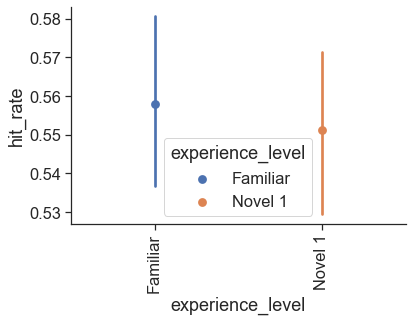

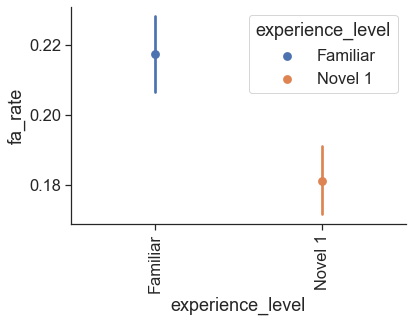

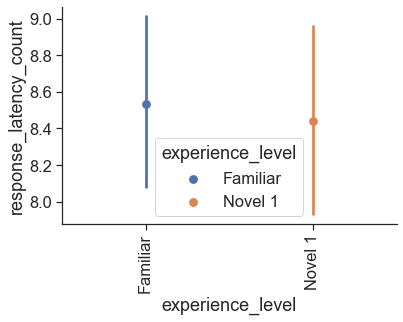

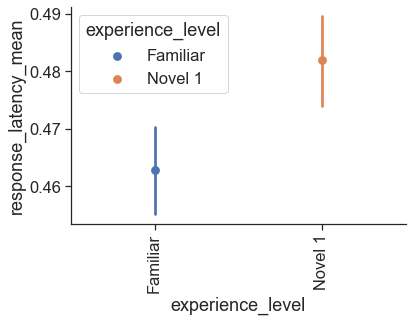

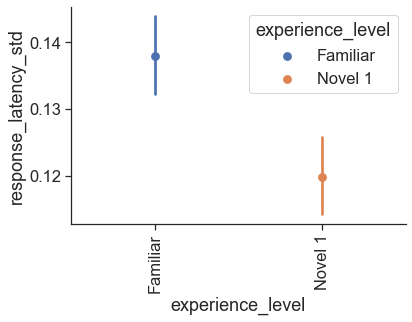

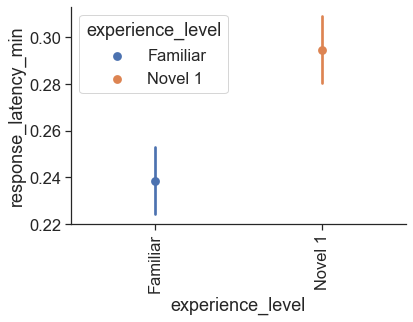

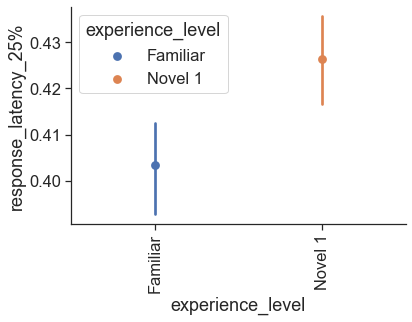

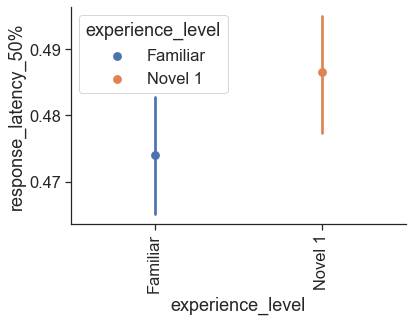

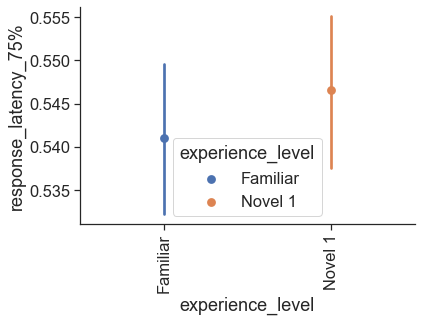

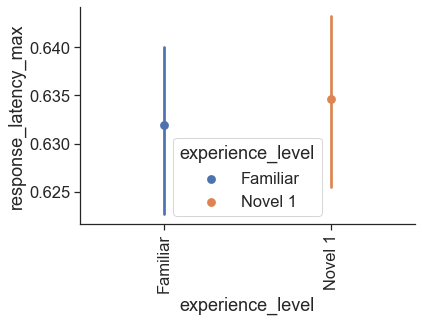

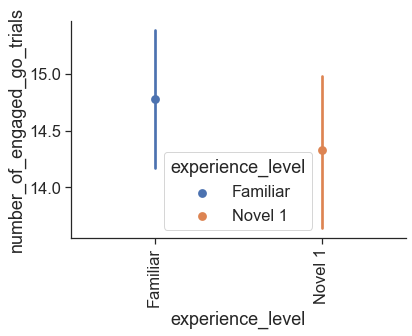

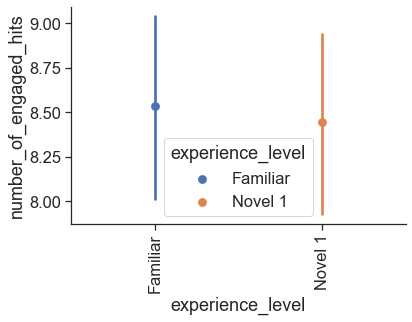

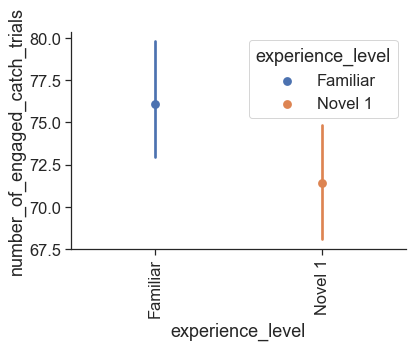

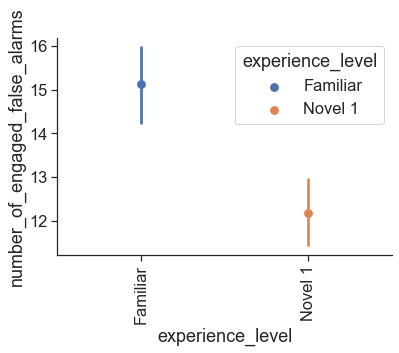

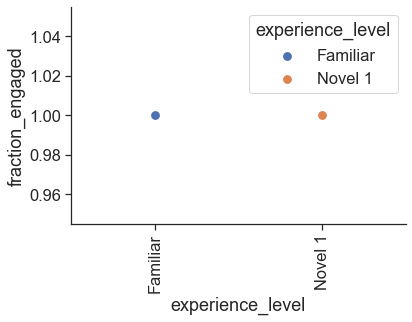

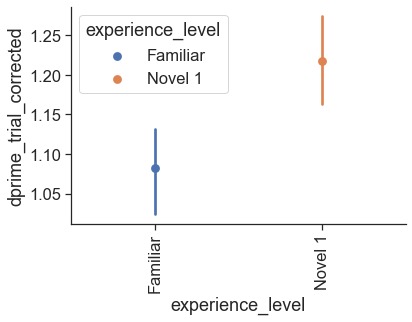

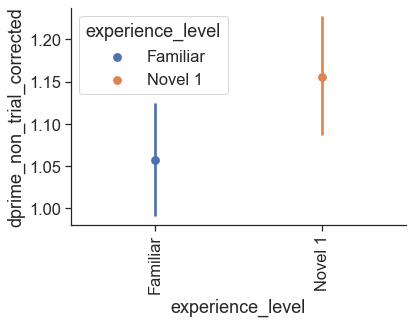

In [30]:
data = stats.copy()

for metric in metrics:
    figsize=(6,4)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.pointplot(data=data, x='experience_level', y=metric, order=order, 
                       hue='experience_level', hue_order=order, colors=colors, join=False, ax=ax)
    ax.set_xticklabels(order, rotation=90);
#     ax.set_ylim(0, 1)
    
    utils.save_figure(fig, figsize, save_dir, folder, metric+'_pointplot_by_experience_level')

### plot behavior metrics for each image for familiar & novel image sets

In [31]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)]

In [32]:
def plot_metric_data_per_image(data, metric='dprime_trial_corrected', title='', ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    image_order = data.groupby(['image_name']).mean()[[metric]].sort_values(by=[metric]).index.values
    ax = sns.pointplot(data=data, x='image_name', y=metric, order=image_order, join=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(image_order, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
#     ax.set_ylim(0,1)
    return ax

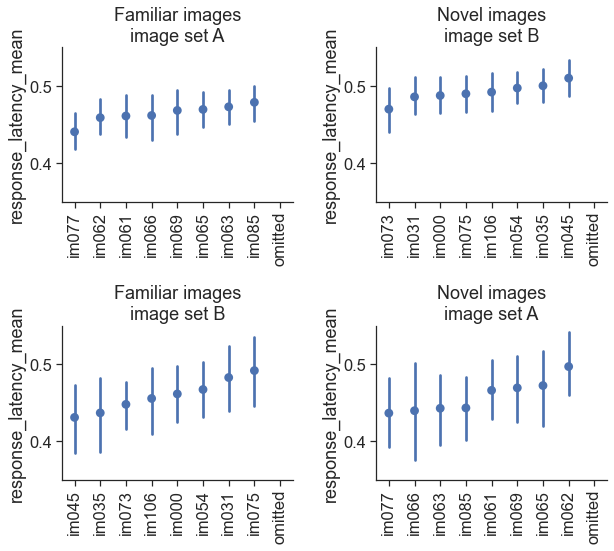

In [33]:
metric = 'response_latency_mean'

fig, ax = plt.subplots(2,2, figsize=(9,8))
ax = ax.ravel()

# A-B mice
data = stats[stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[0] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set A', ax=ax[0])
# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[1] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set B', ax=ax[1])


# B-A mice
data = stats[stats.project_code.isin(['VisualBehaviorTask1B'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[2] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set B', ax=ax[2])

# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[3] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set A', ax=ax[3])

for i in range(4):
    ax[i].set_ylim(0.35,0.55)
fig.tight_layout()

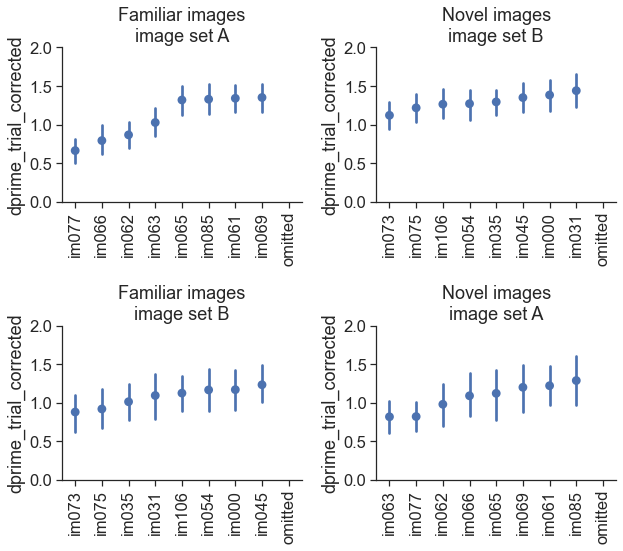

In [34]:
metric = 'dprime_trial_corrected'

fig, ax = plt.subplots(2,2, figsize=(9,8))
ax = ax.ravel()

# A-B mice
data = stats[stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[0] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set A', ax=ax[0])
# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[1] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set B', ax=ax[1])


# B-A mice
data = stats[stats.project_code.isin(['VisualBehaviorTask1B'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[2] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set B', ax=ax[2])

# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[3] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set A', ax=ax[3])

for i in range(4):
    ax[i].set_ylim(0,2)
fig.tight_layout()

#### hit and FA rates per image

In [35]:
def plot_hit_fa_rates(data, title='', ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    image_order = data.groupby(['image_name']).mean()[['hit_rate']].sort_values(by=['hit_rate']).index.values
    # hits
    ax = sns.pointplot(data=data, x='image_name', y='hit_rate', order=image_order, color='g', join=False, ax=ax)
    # FA
    ax = sns.pointplot(data=data, x='image_name', y='fa_rate', order=image_order, color='r', join=False, ax=ax)
    ax.set_title(title)
#     ax.set_xticklabels([image[2:] if image!='omitted' else image for image in image_order], rotation=90)
    ax.set_xticklabels(image_order, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('response probability')
    ax.set_ylim(0,1)
    return ax

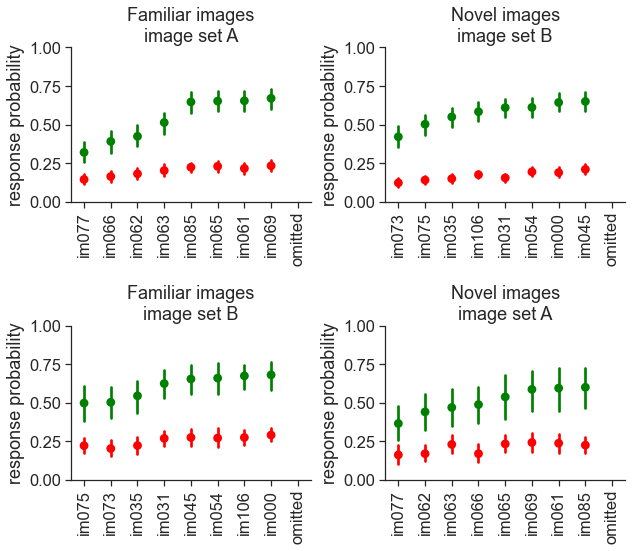

In [36]:
fig, ax = plt.subplots(2,2, figsize=(9,8))
ax = ax.ravel()

# A-B mice
data = stats[stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[0] = plot_hit_fa_rates(familiar_data, title='Familiar images\nimage set A', ax=ax[0])
# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[1] = plot_hit_fa_rates(novel_data, title='Novel images\nimage set B', ax=ax[1])


# B-A mice
data = stats[stats.project_code.isin(['VisualBehaviorTask1B'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[2] = plot_hit_fa_rates(familiar_data, title='Familiar images\nimage set B', ax=ax[2])

# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[3] = plot_hit_fa_rates(novel_data, title='Novel images\nimage set A', ax=ax[3])

fig.tight_layout()

### plot response probability heatmaps for all image transitions in last familiar and first novel sessions

### full session

In [37]:
import visual_behavior.visualization.behavior as behavior

In [38]:
method = 'response_probability'
engaged_only = False
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

In [39]:
familiar_sessions = behavior_sessions[behavior_sessions.last_familiar_active==True].index.values
novel_sessions = behavior_sessions[behavior_sessions.first_novel==True].index.values
print(len(familiar_sessions), len(novel_sessions))

78 78


In [40]:
# get response probability dataframe
familiar_response_probability = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_response_probability = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

# add metadata
familiar_response_probability = familiar_response_probability.merge(behavior_sessions, on='behavior_session_id')
novel_response_probability = novel_response_probability.merge(behavior_sessions, on='behavior_session_id')

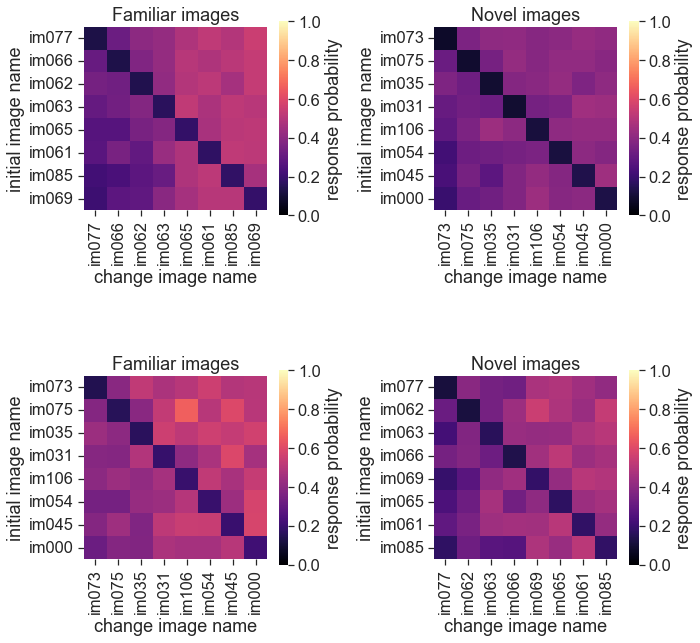

In [41]:
figsize = (10,10)
fig, ax = plt.subplots(2,2, figsize=figsize)
ax = ax.ravel()

# A-B mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[0] = sns.heatmap(familiar_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[0])
ax[0].set_xlabel('change image name')
ax[0].set_ylabel('initial image name')
ax[0].set_title('Familiar images')

ax[1] = sns.heatmap(novel_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[1])
ax[1].set_xlabel('change image name')
ax[1].set_ylabel('initial image name')
ax[1].set_title('Novel images')


# B-A mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[2] = sns.heatmap(familiar_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[2])
ax[2].set_xlabel('change image name')
ax[2].set_ylabel('initial image name')
ax[2].set_title('Familiar images')

ax[3] = sns.heatmap(novel_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[3])
ax[3].set_xlabel('change image name')
ax[3].set_ylabel('initial image name')
ax[3].set_title('Novel images')

fig.tight_layout()
utils.save_figure(fig, figsize, save_dir, folder, 'response_probability_familiar_novel')

### engaged portions of sessions only

In [42]:
method = 'response_probability'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

In [43]:
familiar_sessions = behavior_sessions[behavior_sessions.last_familiar_active==True].index.values
novel_sessions = behavior_sessions[behavior_sessions.first_novel==True].index.values
print(len(familiar_sessions), len(novel_sessions))

78 78


In [44]:
# get response probability dataframe
familiar_response_probability = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_response_probability = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

# add metadata
familiar_response_probability = familiar_response_probability.merge(behavior_sessions, on='behavior_session_id')
novel_response_probability = novel_response_probability.merge(behavior_sessions, on='behavior_session_id')

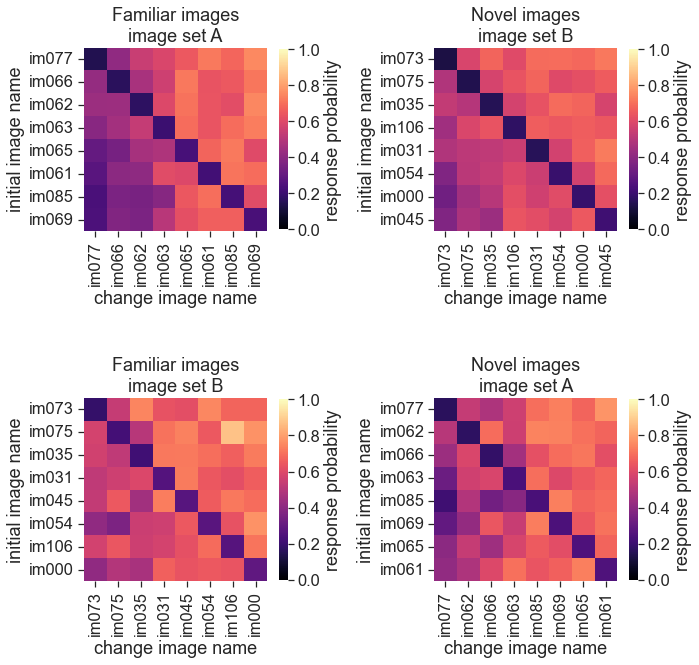

In [45]:
figsize = (10,10)
fig, ax = plt.subplots(2,2, figsize=figsize)
ax = ax.ravel()

# A-B mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[0] = sns.heatmap(familiar_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[0])
ax[0].set_xlabel('change image name')
ax[0].set_ylabel('initial image name')
ax[0].set_title('Familiar images\nimage set A')

ax[1] = sns.heatmap(novel_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[1])
ax[1].set_xlabel('change image name')
ax[1].set_ylabel('initial image name')
ax[1].set_title('Novel images\nimage set B')


# B-A mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[2] = sns.heatmap(familiar_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[2])
ax[2].set_xlabel('change image name')
ax[2].set_ylabel('initial image name')
ax[2].set_title('Familiar images\nimage set B')

ax[3] = sns.heatmap(novel_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[3])
ax[3].set_xlabel('change image name')
ax[3].set_ylabel('initial image name')
ax[3].set_title('Novel images\nimage set A')

fig.tight_layout()
utils.save_figure(fig, figsize, save_dir, folder, 'response_probability_familiar_novel_engaged_only')

### sort and plot performance across all image transitions for A-B mice

In [46]:
familiar_sessions = behavior_sessions[(behavior_sessions.last_familiar_active==True) &
                                     (behavior_sessions.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope']))].index.values
novel_sessions = behavior_sessions[(behavior_sessions.first_novel==True) & 
                                  (behavior_sessions.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope']))].index.values
print(len(familiar_sessions), len(novel_sessions))

52 52


In [47]:
familiar_data = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_data = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

In [48]:
len(familiar_data.image_name.unique())

8

In [49]:
def add_image_pair_column(data):
    data = data.reset_index(drop=True)
    data['image_pair'] = [data.iloc[row]['previous_image_name'][2:]+'_'+data.iloc[row]['image_name'][2:] for row in range(len(data))]
    return data

In [50]:
familiar_data = add_image_pair_column(familiar_data)
novel_data = add_image_pair_column(novel_data)

In [51]:
familiar_pair_order = familiar_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values
novel_pair_order = novel_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values

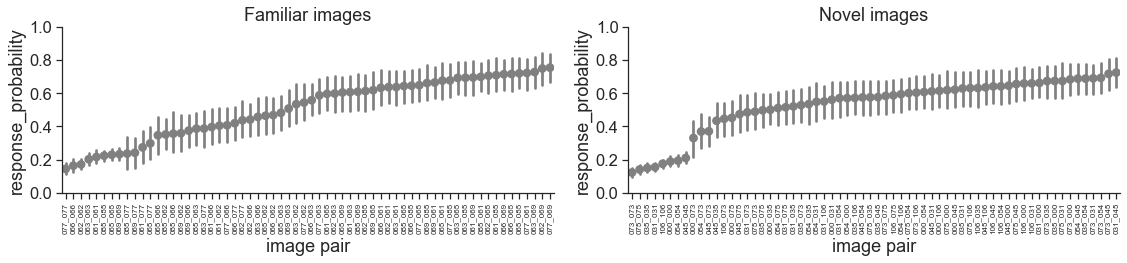

In [52]:
figsize = (16,4)
fig, ax = plt.subplots(1, 2, figsize=figsize)

ax[0] = sns.pointplot(data=familiar_data, x='image_pair', y='response_probability', order=familiar_pair_order, 
                      color='gray', join=False, ax=ax[0])
ax[0].set_xticklabels(familiar_pair_order, rotation=90, fontsize=8)
ax[0].set_xlabel('image pair')
ax[0].set_ylim(0, 1)
ax[0].set_title('Familiar images')


ax[1] = sns.pointplot(data=novel_data, x='image_pair', y='response_probability', order=novel_pair_order, 
                      color='gray', join=False, ax=ax[1])
ax[1].set_xticklabels(novel_pair_order, rotation=90, fontsize=8)
ax[1].set_xlabel('image pair')
ax[1].set_ylim(0, 1)
ax[1].set_title('Novel images')

fig.tight_layout()

In [53]:
def add_image_pair_index(data, pair_order):
    data['image_pair_index'] = None
    for row in range(len(data)):
        image_pair = data.iloc[row].image_pair
        pairs = list(pair_order)
        index = pairs.index(image_pair)
        data.at[row, 'image_pair_index'] = index
    return data

In [54]:
familiar_data = add_image_pair_index(familiar_data, familiar_pair_order)
novel_data = add_image_pair_index(novel_data, novel_pair_order)

In [55]:
order = np.sort(stats.experience_level.unique())

colors = utils.get_colors_for_session_numbers()
colors = [colors[0], colors[3]]

Text(0, 0.5, 'response probability')

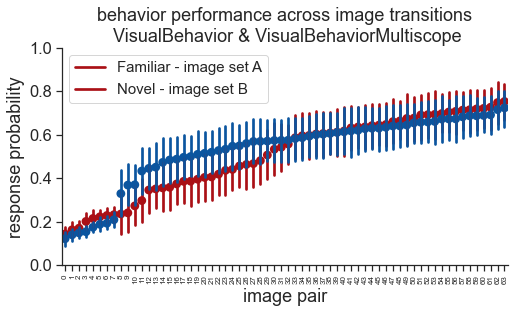

In [56]:
order = np.sort(familiar_data.image_pair_index.unique())

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

ax = sns.pointplot(data=familiar_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[0], label='Familiar', join=False, ax=ax)
ax = sns.pointplot(data=novel_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[1], label='Novel', join=False, ax=ax)
ax.set_xticklabels(order, rotation=90, fontsize=8)
ax.set_xlabel('image pair (sorted)')
ax.set_ylim(0, 1)
ax.legend(['Familiar - image set A', 'Novel - image set B'], loc='upper left', fontsize='small')
ax.set_title('behavior performance across image transitions\n VisualBehavior & VisualBehaviorMultiscope')
ax.set_ylabel('response probability')

Note: Novel is actually blue

#### whats up with the images in the range where familiar is lower than novel? 

In [57]:
low_perf_images = familiar_data[familiar_data.image_pair_index.isin(np.arange(8,32))].image_name.unique()

In [58]:
familiar_experiment_id = experiments_table[experiments_table.behavior_session_id==familiar_data.behavior_session_id.values[0]].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


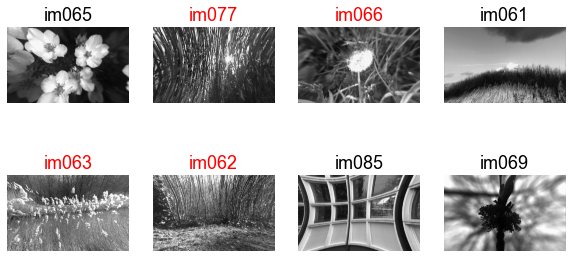

In [59]:
stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    ax[i].imshow(stimulus_templates.loc[image_name]['warped'], cmap='gray')
    if image_name in low_perf_images:
        color='r'
    else:
        color='k'
    ax[i].set_title(image_name, color=color)
    ax[i].axis('off')

These are generally the high spatial frequency images...

### which novel images are in the same range in the ordered set?

In [60]:
novel_low_perf_images = novel_data[novel_data.image_pair_index.isin(np.arange(8,32))].image_name.unique()

In [61]:
novel_experiment_id = experiments_table[experiments_table.behavior_session_id==novel_data.behavior_session_id.values[0]].index.values[0]
dataset = loading.get_ophys_dataset(novel_experiment_id)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '795953296' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '795953296' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "


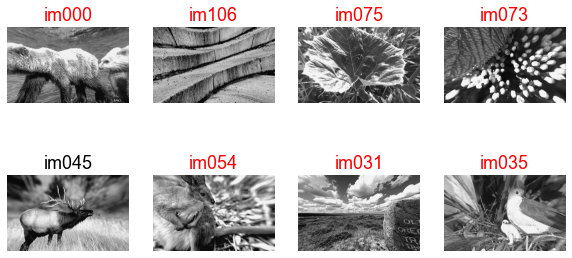

In [62]:
stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    ax[i].imshow(stimulus_templates.loc[image_name]['warped'], cmap='gray')
    if image_name in novel_low_perf_images:
        color='r'
    else:
        color='k'
    ax[i].set_title(image_name, color=color)
    ax[i].axis('off')

In [63]:
novel_low_perf_images

array(['im073', 'im106', 'im075', 'im031', 'im035', 'im000', 'im054'],
      dtype=object)

In [64]:
# does it matter what image it changed from?
novel_data[novel_data.image_pair_index.isin(np.arange(8,32))].previous_image_name.unique()

array(['im106', 'im075', 'im031', 'im035', 'im000', 'im054', 'im045'],
      dtype=object)

In [65]:
np.sort(novel_data[novel_data.image_pair_index.isin(np.arange(8,32))].image_pair.unique())

array(['000_031', '000_035', '000_073', '000_075', '031_035', '031_054',
       '031_073', '031_075', '031_106', '035_073', '035_075', '035_106',
       '045_035', '045_054', '045_073', '045_075', '054_000', '054_031',
       '054_035', '054_073', '054_075', '075_035', '075_073', '106_073'],
      dtype=object)

### repeat for B-A mice

In [66]:
familiar_sessions = behavior_sessions[(behavior_sessions.last_familiar_active==True) &
                                     (behavior_sessions.project_code.isin(['VisualBehaviorTask1B']))].index.values
novel_sessions = behavior_sessions[(behavior_sessions.first_novel==True) & 
                                  (behavior_sessions.project_code.isin(['VisualBehaviorTask1B']))].index.values
print(len(familiar_sessions), len(novel_sessions))

familiar_data = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_data = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

familiar_data = add_image_pair_column(familiar_data)
novel_data = add_image_pair_column(novel_data)

familiar_pair_order = familiar_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values
novel_pair_order = novel_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values

familiar_data = add_image_pair_index(familiar_data, familiar_pair_order)
novel_data = add_image_pair_index(novel_data, novel_pair_order)

26 26


Text(0, 0.5, 'response probability')

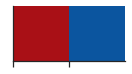

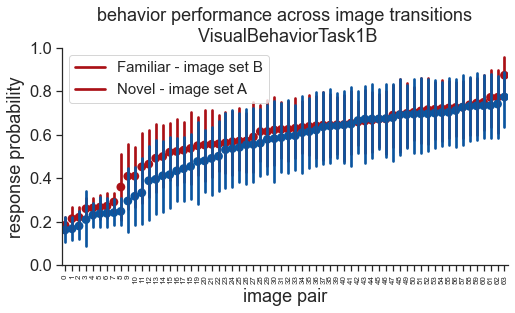

In [67]:
colors = utils.get_colors_for_session_numbers()
colors = [colors[0], colors[3]]
sns.palplot(colors)

order = np.sort(familiar_data.image_pair_index.unique())

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

ax = sns.pointplot(data=familiar_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[0], label='Familiar - image set B', join=False, ax=ax)
ax = sns.pointplot(data=novel_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[1], label='Novel - image set A', join=False, ax=ax)
ax.set_xticklabels(order, rotation=90, fontsize=8)
ax.set_xlabel('image pair')
ax.set_ylim(0, 1)
ax.legend(['Familiar - image set B', 'Novel - image set A'], loc='upper left', fontsize='small')
ax.set_title('behavior performance across image transitions\n VisualBehaviorTask1B')
ax.set_ylabel('response probability')

Note: Novel is actually blue

Difference isnt as bad, but it does indicate that image set A (which is Novel here, i.e. blue) does have images that are simply harder to detect

#### is it the same set of images that are harder to detect for image set A (Novel set in this case)?

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


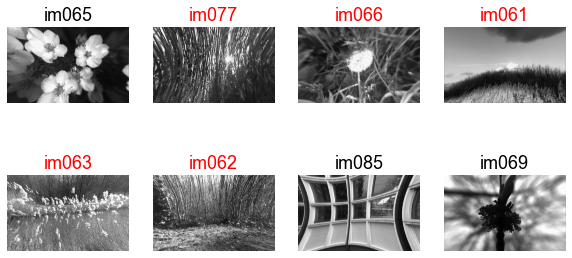

In [68]:
low_perf_images = novel_data[novel_data.image_pair_index.isin(np.arange(8,22))].image_name.unique()

novel_experiment_id = experiments_table[experiments_table.behavior_session_id==novel_data.behavior_session_id.values[0]].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    ax[i].imshow(stimulus_templates.loc[image_name]['warped'], cmap='gray')
    if image_name in low_perf_images:
        color='r'
    else:
        color='k'
    ax[i].set_title(image_name, color=color)
    ax[i].axis('off')

### plot lick raster for first and last stage of each session type for one mouse

In [69]:
mouse_id = behavior_sessions.mouse_id.unique()[0]
mouse_data = behavior_sessions[behavior_sessions.mouse_id==mouse_id]

In [70]:
training_stages = np.sort(mouse_data[mouse_data.training_stage.str.contains('TRAINING')].training_stage.unique())

In [71]:
behavior_session_id = mouse_data[(mouse_data.training_stage==training_stages[0])&(mouse_data.first_day_of_stage)].index.values[0]
dataset = cache.get_behavior_session(behavior_session_id, skip_eye_tracking=True)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


In [72]:
import visual_behavior.visualization.ophys.experiment_summary_figures as ep

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))


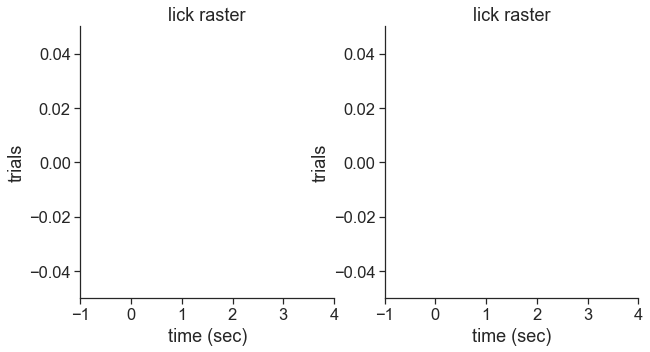

In [73]:
figsize = (10,5)
fig, ax = plt.subplots(1,2, figsize=figsize)
trials = dataset.trials.copy()
trials = trials.reset_index()
trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]
go_trials = trials[trials.go==True]
catch_trials = trials[trials.catch==True]

ax[0] = ep.plot_lick_raster(go_trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[0], save_dir=None)
ax[1] = ep.plot_lick_raster(catch_trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[1], save_dir=None)

### get behavior session object for sessions of interest

In [74]:
behavior_session_ids = []
for i, training_stage in enumerate(training_stages):
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.first_day_of_stage)].index.values[0]
    behavior_session_ids.append(behavior_session_id)
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.last_day_of_stage)].index.values[0]
    behavior_session_ids.append(behavior_session_id)
    
data_dict = {}
for behavior_session_id in behavior_session_ids:
    dataset = cache.get_behavior_session(behavior_session_id)
    data_dict[behavior_session_id] = dataset

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '742008131' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '742008131' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:5

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))


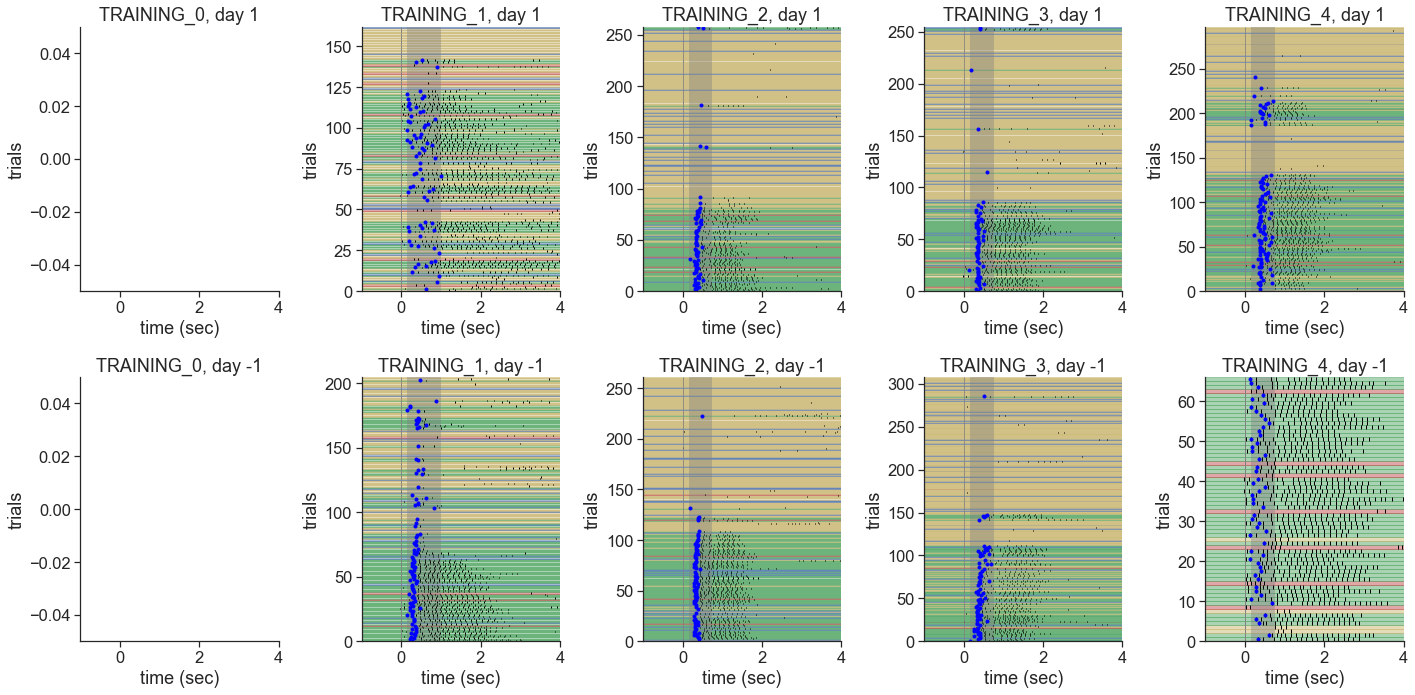

In [75]:
n_stages = len(training_stages)

figsize = (20,10)
fig, ax = plt.subplots(2, n_stages, figsize=figsize)
ax = ax.ravel()

for i, training_stage in enumerate(training_stages):
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.first_day_of_stage)].index.values[0]
    dataset = data_dict[behavior_session_id]
    trials = dataset.trials.copy()
    trials = trials.reset_index()
    trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]

    ax[i] = ep.plot_lick_raster(trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[i], save_dir=None)
    ax[i].set_title(training_stage+', day 1')
    
    
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.last_day_of_stage)].index.values[0]
    dataset = data_dict[behavior_session_id]
    trials = dataset.trials.copy()
    trials = trials.reset_index()
    trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]

    ax[i+n_stages] = ep.plot_lick_raster(trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[i+n_stages], save_dir=None)
    ax[i+n_stages].set_title(training_stage+', day -1')
fig.tight_layout()

### Plot metrics distributions (averaged across images within each session)

In [76]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


original_behavior_stats = behavior_stats.copy()

  0%|                                                                                 | 5/3667 [00:00<01:13, 49.93it/s]

loading for 742008131
loading for 742797917
loading for 743041166
loading for 743660302
loading for 744374168
loading for 745054849
loading for 745355000
loading for 745636848
loading for 746222622
loading for 746928360
loading for 750415261


  0%|▎                                                                               | 16/3667 [00:00<01:16, 47.54it/s]

loading for 750781358
loading for 752002559
loading for 753011296
loading for 753936007
loading for 754509820
loading for 754896244
loading for 755551879
loading for 756106020
loading for 756632727


  1%|▌                                                                               | 27/3667 [00:00<01:21, 44.89it/s]

loading for 757431083
loading for 758162988
loading for 758942142
loading for 759251920
loading for 759756829
loading for 760007428
loading for 760409951
loading for 760698062
loading for 761499069
loading for 761831761
loading for 762178061


  1%|▊                                                                               | 37/3667 [00:00<01:20, 45.16it/s]

loading for 762722108
loading for 763291103
loading for 763980798
loading for 764495320
loading for 764897570
loading for 765396393
loading for 766110635
loading for 766753111
loading for 767275980
loading for 768042187


  1%|█                                                                               | 47/3667 [00:01<01:22, 43.96it/s]

loading for 768815421
loading for 769452637
loading for 769902997
loading for 770244427
loading for 771245588
loading for 772125590
loading for 772658979
loading for 773585522
loading for 774106776


  2%|█▏                                                                              | 57/3667 [00:01<01:22, 43.67it/s]

loading for 774373300
loading for 774422914
loading for 774937388
loading for 775378326
loading for 775870895
loading for 777082591
loading for 778166125
loading for 778980920
loading for 779818630
loading for 780758836


  2%|█▍                                                                              | 67/3667 [00:01<01:22, 43.86it/s]

loading for 782380778
loading for 784156661
loading for 785426306
loading for 785944233
loading for 786920476
loading for 788017709
loading for 791257562
loading for 791749028
loading for 792499741
loading for 793129579


  2%|█▋                                                                              | 77/3667 [00:01<01:18, 45.92it/s]

loading for 796032489
loading for 760808911
loading for 761294708
loading for 761730617
loading for 762067130
loading for 762418364
loading for 763012686
loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332


  2%|█▉                                                                              | 87/3667 [00:01<01:16, 46.93it/s]

loading for 765793356
loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504
loading for 769145833
loading for 769731277
loading for 770215042
loading for 771040969
loading for 771902184


  3%|██                                                                              | 97/3667 [00:02<01:15, 47.37it/s]

loading for 772475707
loading for 773391809
loading for 774120511
loading for 774679623
loading for 775291372
loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859
loading for 780479408
loading for 781938213


  3%|██▎                                                                            | 108/3667 [00:02<01:13, 48.61it/s]

loading for 783217873
loading for 783959068
loading for 785382040
loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329
loading for 791248943
loading for 791904071
loading for 792680306


  3%|██▌                                                                            | 119/3667 [00:02<01:14, 47.59it/s]

loading for 793485674
loading for 794968300
loading for 795742990
loading for 796052844
loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999
loading for 774208555
loading for 774767072
loading for 775344511


  4%|██▊                                                                            | 129/3667 [00:02<01:12, 48.72it/s]

loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423
loading for 780351711
loading for 781727422
loading for 783059206
loading for 783971649
loading for 785376297


  4%|██▉                                                                            | 139/3667 [00:03<01:19, 44.65it/s]

loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700
loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128
loading for 794673280


  4%|███▏                                                                           | 149/3667 [00:03<01:21, 43.38it/s]

loading for 795431009
loading for 796031509
loading for 797170547
loading for 776156839
loading for 777417642
loading for 778884020
loading for 779111633
loading for 780002890
loading for 780766304
loading for 783413166


  4%|███▍                                                                           | 159/3667 [00:03<01:25, 41.12it/s]

loading for 784173223
loading for 785539951
loading for 786305627
loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254
loading for 792661903


  5%|███▋                                                                           | 169/3667 [00:03<01:26, 40.54it/s]

loading for 793323654
loading for 794275479
loading for 794953909
loading for 795838927
loading for 796046197
loading for 796233602
loading for 796607829
loading for 798145975


  5%|███▋                                                                           | 174/3667 [00:03<01:23, 41.94it/s]

loading for 798679618
loading for 799661667
loading for 800202171
loading for 802406837
loading for 802922968
loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108
loading for 807198458


  5%|███▉                                                                           | 184/3667 [00:04<01:26, 40.44it/s]

loading for 808107647
loading for 809321253
loading for 791877093
loading for 792689261
loading for 793414389
loading for 794295959
loading for 794977379
loading for 795854559


  5%|████▏                                                                          | 195/3667 [00:04<01:18, 44.31it/s]

loading for 799051310
loading for 799922316
loading for 800299366
loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931
loading for 806792366


  6%|████▍                                                                          | 205/3667 [00:04<01:16, 45.01it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256
loading for 816417578
loading for 817139151


  6%|████▋                                                                          | 216/3667 [00:04<01:14, 46.10it/s]

loading for 818485496
loading for 819094295
loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383
loading for 795854555
loading for 799049628


  6%|████▊                                                                          | 222/3667 [00:04<01:10, 48.62it/s]

loading for 799919887
loading for 800299362
loading for 800919728
loading for 802364085
loading for 802988119
loading for 803347004
loading for 805639780
loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167


  6%|█████                                                                          | 233/3667 [00:05<01:11, 47.86it/s]

loading for 809027309
loading for 809427293
loading for 811355443
loading for 810584641
loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  7%|█████▎                                                                         | 244/3667 [00:05<01:10, 48.68it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380
loading for 822409353
loading for 823241007


  7%|█████▍                                                                         | 255/3667 [00:05<01:11, 47.86it/s]

loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541
loading for 826697158
loading for 827374757
loading for 828646658
loading for 829138845
loading for 829578829
loading for 830255592


  7%|█████▋                                                                         | 266/3667 [00:05<01:09, 48.66it/s]

loading for 830832988
loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024
loading for 807533658
loading for 808488955
loading for 809095689


  7%|█████▊                                                                         | 271/3667 [00:05<01:11, 47.81it/s]

loading for 809427297
loading for 809815041
loading for 810598880
loading for 811354008
loading for 811830102
loading for 812559803
loading for 813041953
loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256


  8%|██████▏                                                                        | 286/3667 [00:06<01:00, 56.19it/s]

loading for 817165094
loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655
loading for 822439453
loading for 823254723
loading for 824894721
loading for 807062523
loading for 808103937
loading for 809588395


  8%|██████▍                                                                        | 298/3667 [00:06<01:04, 51.83it/s]

loading for 810266014
loading for 811140660
loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983
loading for 814749891
loading for 815865807
loading for 817053045


  8%|██████▌                                                                        | 304/3667 [00:06<01:06, 50.63it/s]

loading for 818539436
loading for 819065377
loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346
loading for 822874578
loading for 823496226
loading for 824566587
loading for 825269006


  9%|██████▊                                                                        | 315/3667 [00:06<01:10, 47.63it/s]

loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593
loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  9%|███████                                                                        | 326/3667 [00:07<01:12, 46.11it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110
loading for 837512169
loading for 823922942
loading for 824972176
loading for 825527066
loading for 826338809


  9%|███████▎                                                                       | 337/3667 [00:07<01:09, 47.73it/s]

loading for 826841473
loading for 827977069
loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963
loading for 832009551
loading for 832522789
loading for 833252272


  9%|███████▍                                                                       | 343/3667 [00:07<01:09, 47.83it/s]

loading for 834059775
loading for 834886139
loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869
loading for 838486964
loading for 839220840
loading for 839566028


 10%|███████▋                                                                       | 355/3667 [00:07<01:06, 49.61it/s]

loading for 839918083
loading for 840583412
loading for 841431760
loading for 841830077
loading for 842387217
loading for 842821314
loading for 843397714
loading for 844197868
loading for 844880686
loading for 845564445
loading for 846272622


 10%|███████▉                                                                       | 366/3667 [00:07<01:05, 50.34it/s]

loading for 847022155
loading for 847829598
loading for 848519645
loading for 849073265
loading for 849635376
loading for 850977753
loading for 851779746
loading for 852468381
loading for 853168204
loading for 853875502
loading for 854563857


 10%|████████▏                                                                      | 378/3667 [00:08<01:05, 50.51it/s]

loading for 855421865
loading for 855973498
loading for 856717282
loading for 857612105
loading for 859065627
loading for 859735311
loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911


 11%|████████▍                                                                      | 390/3667 [00:08<01:04, 51.17it/s]

loading for 864824449
loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114
loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535


 11%|████████▌                                                                      | 396/3667 [00:08<01:07, 48.23it/s]

loading for 874681118
loading for 875414332
loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000


 11%|████████▋                                                                      | 406/3667 [00:08<01:09, 47.05it/s]

loading for 882256127
loading for 882748184
loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012
loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786


 11%|████████▉                                                                      | 417/3667 [00:08<01:07, 48.03it/s]

loading for 823248638
loading for 823922950
loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014
loading for 828838236
loading for 829282785


 12%|█████████▏                                                                     | 427/3667 [00:09<01:17, 41.91it/s]

loading for 829877552
loading for 830620126
loading for 832019583
loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885
loading for 836777468


 12%|█████████▍                                                                     | 437/3667 [00:09<01:13, 43.97it/s]

loading for 837196627
loading for 837647722
loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485
loading for 840594518
loading for 841429687
loading for 841842210


 12%|█████████▋                                                                     | 447/3667 [00:09<01:13, 43.61it/s]

loading for 842399625
loading for 842844413
loading for 843400443
loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338
loading for 847871771
loading for 848599542
loading for 849136474


 12%|█████████▊                                                                     | 457/3667 [00:09<01:13, 43.53it/s]

loading for 849648618
loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851
loading for 828646634
loading for 829128279
loading for 829591790
loading for 830201482


 13%|██████████                                                                     | 468/3667 [00:10<01:08, 46.99it/s]

loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071
loading for 833780803
loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225


 13%|██████████▎                                                                    | 479/3667 [00:10<01:05, 48.39it/s]

loading for 838236165
loading for 839014738
loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100
loading for 843166865


 13%|██████████▌                                                                    | 489/3667 [00:10<01:06, 47.66it/s]

loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029
loading for 848575992
loading for 849098851
loading for 850976604
loading for 853266283


 14%|██████████▊                                                                    | 500/3667 [00:10<01:03, 50.10it/s]

loading for 831129394
loading for 832021447
loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296
loading for 836166694
loading for 836761653
loading for 837192567


 14%|██████████▉                                                                    | 506/3667 [00:10<01:04, 49.26it/s]

loading for 837638916
loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986
loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895


 14%|███████████                                                                    | 516/3667 [00:11<01:04, 48.69it/s]

loading for 843203333
loading for 844164376
loading for 844849972
loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804
loading for 853526948
loading for 834587823
loading for 835451471
loading for 835867850


 14%|███████████▎                                                                   | 526/3667 [00:11<01:05, 48.23it/s]

loading for 836522245
loading for 837083657
loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826
loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868


 15%|███████████▌                                                                   | 536/3667 [00:11<01:15, 41.22it/s]

loading for 842139310
loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277
loading for 845409652
loading for 846051276
loading for 846791195


 15%|███████████▊                                                                   | 547/3667 [00:11<01:10, 44.18it/s]

loading for 847613846
loading for 848272657
loading for 848938321
loading for 849525884
loading for 850817466
loading for 851563931
loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407


 15%|███████████▉                                                                   | 552/3667 [00:11<01:12, 42.91it/s]

loading for 855826937
loading for 857230827
loading for 837658854
loading for 838515247
loading for 839219841
loading for 839565422
loading for 839912316


 15%|████████████▏                                                                  | 563/3667 [00:12<01:14, 41.63it/s]

loading for 840581827
loading for 841426832
loading for 841827774
loading for 842385277
loading for 842819933
loading for 843400453
loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423


 16%|████████████▎                                                                  | 573/3667 [00:12<01:16, 40.34it/s]

loading for 847036328
loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928


 16%|████████████▍                                                                  | 578/3667 [00:12<01:13, 41.80it/s]

loading for 852451567
loading for 855200229
loading for 837654533
loading for 838483140
loading for 839219845
loading for 839565426
loading for 839914270
loading for 840581823
loading for 841426857
loading for 841830096


 16%|████████████▋                                                                  | 590/3667 [00:12<01:05, 46.78it/s]

loading for 842385266
loading for 842819929
loading for 843401580
loading for 844199766
loading for 844891885
loading for 845572039
loading for 846016059
loading for 846750050
loading for 847660741
loading for 848348215
loading for 848943191


 16%|████████████▉                                                                  | 601/3667 [00:12<01:02, 48.89it/s]

loading for 849494762
loading for 850807174
loading for 851542477
loading for 852229360
loading for 853025613
loading for 855446545
loading for 855866701
loading for 856467236
loading for 857367017
loading for 858029487
loading for 858967789


 17%|█████████████▏                                                                 | 612/3667 [00:13<01:02, 49.18it/s]

loading for 859793880
loading for 860533862
loading for 864068649
loading for 840598877
loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895
loading for 844945060


 17%|█████████████▍                                                                 | 622/3667 [00:13<01:01, 49.51it/s]

loading for 845594684
loading for 846284880
loading for 847048490
loading for 847838131
loading for 848526511
loading for 848910243
loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248


 17%|█████████████▋                                                                 | 633/3667 [00:13<00:59, 50.61it/s]

loading for 853875514
loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666
loading for 858974731
loading for 859775117
loading for 863610582
loading for 868070216
loading for 868658294
loading for 869559097


 18%|█████████████▉                                                                 | 645/3667 [00:13<01:01, 49.19it/s]

loading for 850978904
loading for 851802107
loading for 852457995
loading for 853257103
loading for 853793068
loading for 854602288
loading for 855476794
loading for 856010720
loading for 856732195
loading for 857547928


 18%|██████████████▏                                                                | 656/3667 [00:14<01:04, 46.75it/s]

loading for 858273959
loading for 859054070
loading for 859802280
loading for 860894659
loading for 861794694
loading for 862716894
loading for 863559318
loading for 864280264


 18%|██████████████▏                                                                | 661/3667 [00:14<01:04, 46.55it/s]

loading for 865544821
loading for 866336764
loading for 867098393
loading for 867945660
loading for 868819048
loading for 869621595
loading for 870960908
loading for 872107505
loading for 873813922
loading for 874808131


 18%|██████████████▍                                                                | 671/3667 [00:14<01:07, 44.33it/s]

loading for 876821717
loading for 854533487
loading for 855504136
loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891
loading for 859032026
loading for 859791558


 19%|██████████████▋                                                                | 681/3667 [00:14<01:09, 42.94it/s]

loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054
loading for 864137547
loading for 864839176
loading for 865581941
loading for 866287088


 19%|██████████████▉                                                                | 691/3667 [00:14<01:12, 40.79it/s]

loading for 866950070
loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378
loading for 872646068
loading for 873517635


 19%|███████████████                                                                | 697/3667 [00:15<01:09, 43.00it/s]

loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550
loading for 852507945
loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937


 19%|███████████████▏                                                               | 707/3667 [00:15<01:06, 44.73it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868
loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836
loading for 864260028
loading for 864813130


 20%|███████████████▍                                                               | 717/3667 [00:15<01:05, 45.12it/s]

loading for 865460179
loading for 866296478
loading for 866999677
loading for 867615541
loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394
loading for 872626160
loading for 873695653


 20%|███████████████▋                                                               | 728/3667 [00:15<01:02, 47.27it/s]

loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747
loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794
loading for 882256117
loading for 854528256


 20%|███████████████▉                                                               | 740/3667 [00:15<00:58, 49.63it/s]

loading for 855503335
loading for 856002613
loading for 856732213
loading for 857555461
loading for 858240896
loading for 859032044
loading for 859791563
loading for 860752819
loading for 861794704
loading for 862701503


 20%|████████████████▏                                                              | 751/3667 [00:16<00:59, 49.24it/s]

loading for 863559327
loading for 864125430
loading for 864839160
loading for 865580429
loading for 866287143
loading for 867082086
loading for 868004770
loading for 868747797
loading for 872158938


 21%|████████████████▎                                                              | 756/3667 [00:16<00:58, 49.44it/s]

loading for 873015934
loading for 873824951
loading for 874747892
loading for 875444395
loading for 876857698
loading for 878159171
loading for 879037253
loading for 880201859
loading for 880776648
loading for 881413102


 21%|████████████████▌                                                              | 767/3667 [00:16<01:00, 48.12it/s]

loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160
loading for 885644181
loading for 886440437
loading for 887165432
loading for 888282547
loading for 858104885
loading for 858900546


 21%|████████████████▊                                                              | 779/3667 [00:16<01:00, 48.05it/s]

loading for 859601488
loading for 860247669
loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979
loading for 864665192
loading for 865114696
loading for 865887829
loading for 866906696


 21%|████████████████▉                                                              | 785/3667 [00:16<00:59, 48.07it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699
loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527
loading for 875020211


 22%|█████████████████▏                                                             | 795/3667 [00:17<01:02, 45.69it/s]

loading for 876448536
loading for 877855866
loading for 878615859
loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453
loading for 884598044
loading for 885404075


 22%|█████████████████▎                                                             | 805/3667 [00:17<01:02, 45.68it/s]

loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386
loading for 896561264
loading for 898432373


 22%|█████████████████▌                                                             | 815/3667 [00:17<01:05, 43.38it/s]

loading for 898874650
loading for 899390684
loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625
loading for 907053876
loading for 907900077
loading for 908533370
loading for 910207192


 23%|█████████████████▊                                                             | 826/3667 [00:17<01:05, 43.22it/s]

loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263
loading for 914705301
loading for 915418411
loading for 916403851
loading for 918103715
loading for 923410363
loading for 924472023


 23%|██████████████████                                                             | 836/3667 [00:18<01:03, 44.42it/s]

loading for 925084998
loading for 858098100
loading for 858891746
loading for 859601496
loading for 860247677
loading for 861715805
loading for 862326321
loading for 863361852
loading for 863966966
loading for 864656758


 23%|██████████████████▏                                                            | 847/3667 [00:18<00:59, 47.10it/s]

loading for 865114705
loading for 865883182
loading for 866912923
loading for 867553178
loading for 868521085
loading for 869223965
loading for 870473396
loading for 871723073
loading for 872607297
loading for 873440438
loading for 874324523


 23%|██████████████████▍                                                            | 857/3667 [00:18<00:58, 48.27it/s]

loading for 875020169
loading for 877447964
loading for 878282369
loading for 880231156
loading for 880780889
loading for 881427978
loading for 882434675
loading for 882827577
loading for 884888379
loading for 885739915


 24%|██████████████████▋                                                            | 869/3667 [00:18<00:55, 50.25it/s]

loading for 886446971
loading for 887236947
loading for 888301437
loading for 889559462
loading for 890374401
loading for 891792255
loading for 892663103
loading for 893600606
loading for 858098096
loading for 859064345


 24%|██████████████████▊                                                            | 875/3667 [00:18<00:56, 49.50it/s]

loading for 859735301
loading for 860650174
loading for 861785387
loading for 862752139
loading for 863571063
loading for 864137543
loading for 864820740
loading for 865463877
loading for 866319121
loading for 867036286
loading for 867961842


 24%|███████████████████                                                            | 887/3667 [00:19<00:55, 49.92it/s]

loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204
loading for 872979404
loading for 873733206
loading for 874654275
loading for 875385898
loading for 876737438
loading for 877558819
loading for 878233751
loading for 879003588


 25%|███████████████████▎                                                           | 899/3667 [00:19<00:53, 51.41it/s]

loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175
loading for 883857874
loading for 884800923
loading for 885589846
loading for 886437461
loading for 887183674
loading for 888263147


 25%|███████████████████▌                                                           | 910/3667 [00:19<01:00, 45.86it/s]

loading for 889436433
loading for 890459182
loading for 891759060
loading for 892589687
loading for 893433252
loading for 894215832
loading for 896543695
loading for 898493295
loading for 898889632
loading for 899400259


 25%|███████████████████▊                                                           | 920/3667 [00:19<00:58, 47.18it/s]

loading for 900228074
loading for 901102440
loading for 902021938
loading for 902822517
loading for 904630713
loading for 907035941
loading for 907995409
loading for 908564883
loading for 909363995
loading for 910249989
loading for 911361470


 25%|████████████████████                                                           | 930/3667 [00:20<01:01, 44.82it/s]

loading for 911947271
loading for 912570316
loading for 913710476
loading for 914230230
loading for 914715937
loading for 915448786
loading for 916450856
loading for 917331220
loading for 918202290


 26%|████████████████████▎                                                          | 940/3667 [00:20<01:00, 45.28it/s]

loading for 918900907
loading for 919634924
loading for 920541932
loading for 921601457
loading for 922572837
loading for 923474474
loading for 924575646
loading for 925033179
loading for 926393722


 26%|████████████████████▍                                                          | 950/3667 [00:20<00:59, 45.46it/s]

loading for 927449068
loading for 928400507
loading for 929341697
loading for 929818797
loading for 931566300
loading for 932611698
loading for 933504759
loading for 934610593
loading for 935811563


 26%|████████████████████▌                                                          | 955/3667 [00:20<00:59, 45.60it/s]

loading for 937416292
loading for 938377224
loading for 939538572
loading for 862786889
loading for 863627986
loading for 864248647
loading for 865463863
loading for 866103829
loading for 867056914
loading for 868008761


 26%|████████████████████▉                                                          | 971/3667 [00:20<00:56, 47.60it/s]

loading for 868709715
loading for 871033938
loading for 872127292
loading for 873051801
loading for 873781580
loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747
loading for 878282360


 27%|█████████████████████                                                          | 976/3667 [00:21<00:57, 46.81it/s]

loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102
loading for 882388591
loading for 883704230
loading for 884677929
loading for 886239982
loading for 886873295
loading for 889155682


 27%|█████████████████████▏                                                         | 986/3667 [00:21<00:55, 48.14it/s]

loading for 890051221
loading for 891487953
loading for 892410834
loading for 893356870
loading for 894209378
loading for 894987969
loading for 896526348
loading for 898453640
loading for 898889612
loading for 899452222


 27%|█████████████████████▍                                                         | 997/3667 [00:21<00:56, 47.45it/s]

loading for 901380774
loading for 902270195
loading for 903070554
loading for 904011865
loading for 906695544
loading for 907356161
loading for 908908617
loading for 911021831
loading for 911522814


 28%|█████████████████████▍                                                        | 1009/3667 [00:21<00:53, 49.67it/s]

loading for 912242958
loading for 912918028
loading for 913898214
loading for 914405292
loading for 914868296
loading for 915690421
loading for 916623819
loading for 917581144
loading for 918454518
loading for 919073273


 28%|█████████████████████▋                                                        | 1019/3667 [00:21<00:55, 47.85it/s]

loading for 919973223
loading for 920836124
loading for 921879374
loading for 922942074
loading for 923786645
loading for 924729242
loading for 926769977
loading for 927745870
loading for 928717396


 28%|█████████████████████▊                                                        | 1025/3667 [00:22<00:53, 49.34it/s]

loading for 929524399
loading for 932078145
loading for 932975404
loading for 934075944
loading for 934900274
loading for 936033313
loading for 937825662
loading for 938991494
loading for 940243685
loading for 940796859
loading for 941946991


 28%|██████████████████████                                                        | 1035/3667 [00:22<00:55, 47.82it/s]

loading for 942448113
loading for 945277725
loading for 946172858
loading for 947503956
loading for 948341757
loading for 862479694
loading for 863414647
loading for 864000195
loading for 864729508
loading for 865288307


 28%|██████████████████████▏                                                       | 1045/3667 [00:22<00:57, 45.92it/s]

loading for 865953304
loading for 866971252
loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256
loading for 873530279
loading for 874295478


 29%|██████████████████████▍                                                       | 1056/3667 [00:22<00:55, 47.08it/s]

loading for 875020129
loading for 876521253
loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654
loading for 880647168
loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948


 29%|██████████████████████▋                                                       | 1067/3667 [00:22<00:53, 49.01it/s]

loading for 884560033
loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551
loading for 891504476
loading for 892413871
loading for 893359124


 29%|██████████████████████▉                                                       | 1077/3667 [00:23<01:02, 41.76it/s]

loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485
loading for 902028378


 30%|███████████████████████                                                       | 1082/3667 [00:23<01:01, 41.73it/s]

loading for 902822538
loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486
loading for 912159483
loading for 913921659
loading for 914411174


 30%|███████████████████████▎                                                      | 1094/3667 [00:23<00:55, 45.98it/s]

loading for 914871449
loading for 915739774
loading for 916704634
loading for 917595407
loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852


 30%|███████████████████████▍                                                      | 1104/3667 [00:23<00:54, 46.68it/s]

loading for 924759623
loading for 925603486
loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050
loading for 863657189
loading for 864236370
loading for 864809053
loading for 865443418


 30%|███████████████████████▋                                                      | 1114/3667 [00:23<00:55, 46.25it/s]

loading for 866300303
loading for 867045079
loading for 867977763
loading for 868704504
loading for 869615887
loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139


 31%|███████████████████████▉                                                      | 1124/3667 [00:24<00:53, 47.68it/s]

loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744
loading for 879003593
loading for 880088387
loading for 881416618
loading for 882373648
loading for 882785348
loading for 883984332
loading for 884750162


 31%|████████████████████████▏                                                     | 1135/3667 [00:24<00:51, 48.97it/s]

loading for 885540222
loading for 886440427
loading for 886931452
loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605
loading for 894466746


 31%|████████████████████████▍                                                     | 1146/3667 [00:24<00:50, 50.05it/s]

loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557
loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490


 31%|████████████████████████▌                                                     | 1152/3667 [00:24<00:52, 47.47it/s]

loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296
loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195


 32%|████████████████████████▋                                                     | 1163/3667 [00:25<00:57, 43.60it/s]

loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985
loading for 921873454
loading for 923757660


 32%|████████████████████████▉                                                     | 1173/3667 [00:25<01:00, 41.11it/s]

loading for 924739087
loading for 926621793
loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462
loading for 932960096
loading for 933939891


 32%|█████████████████████████                                                     | 1178/3667 [00:25<01:01, 40.74it/s]

loading for 935038748
loading for 936159430
loading for 937645038
loading for 938729036
loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533
loading for 945033994


 32%|█████████████████████████▎                                                    | 1188/3667 [00:25<00:59, 41.48it/s]

loading for 947336783
loading for 948225040
loading for 949348713
loading for 950188644
loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204
loading for 865131331


 33%|█████████████████████████▍                                                    | 1198/3667 [00:25<01:01, 40.26it/s]

loading for 865887821
loading for 866909432
loading for 867521015
loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185


 33%|█████████████████████████▌                                                    | 1203/3667 [00:26<01:05, 37.37it/s]

loading for 873449838
loading for 874333572
loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869


 33%|█████████████████████████▊                                                    | 1214/3667 [00:26<00:58, 42.03it/s]

loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883
loading for 884605735
loading for 885404024
loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687


 33%|██████████████████████████                                                    | 1224/3667 [00:26<00:54, 45.16it/s]

loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636
loading for 902211897
loading for 902995627


 34%|██████████████████████████▎                                                   | 1236/3667 [00:26<00:49, 48.70it/s]

loading for 903977177
loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306
loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 34%|██████████████████████████▌                                                   | 1247/3667 [00:26<00:50, 48.09it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442
loading for 877558833


 34%|██████████████████████████▋                                                   | 1252/3667 [00:27<00:50, 48.00it/s]

loading for 878245978
loading for 878993255
loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590
loading for 883756380
loading for 884552901
loading for 885410929
loading for 886257016
loading for 886838602


 34%|██████████████████████████▉                                                   | 1264/3667 [00:27<00:47, 50.36it/s]

loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789
loading for 892387261
loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566


 35%|███████████████████████████▏                                                  | 1276/3667 [00:27<00:49, 48.04it/s]

loading for 868531777
loading for 869311972
loading for 870579061
loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203
loading for 876651891
loading for 877487375


 35%|███████████████████████████▍                                                  | 1287/3667 [00:27<00:49, 48.29it/s]

loading for 878179382
loading for 878771403
loading for 879969002
loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813
loading for 883632956
loading for 884560064
loading for 885410934


 35%|███████████████████████████▌                                                  | 1297/3667 [00:28<00:50, 46.47it/s]

loading for 886250995
loading for 887006111
loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544
loading for 893488330
loading for 894368064
loading for 870987812


 36%|███████████████████████████▊                                                  | 1308/3667 [00:28<00:48, 48.40it/s]

loading for 872953842
loading for 873774125
loading for 874790261
loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989
loading for 879003606
loading for 880088400
loading for 881416637
loading for 882373653


 36%|████████████████████████████                                                  | 1318/3667 [00:28<00:52, 44.66it/s]

loading for 882781075
loading for 883986743
loading for 884776248
loading for 885540237
loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960


 36%|████████████████████████████▏                                                 | 1323/3667 [00:28<00:52, 44.40it/s]

loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304
loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343


 36%|████████████████████████████▎                                                 | 1333/3667 [00:28<00:51, 45.18it/s]

loading for 896995828
loading for 898667252
loading for 899700579
loading for 900231059
loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549
loading for 908104455


 37%|████████████████████████████▌                                                 | 1343/3667 [00:29<00:51, 45.10it/s]

loading for 910393217
loading for 911016285
loading for 911541950
loading for 912223787
loading for 912902619
loading for 913850450
loading for 914339617
loading for 914831000
loading for 915609216
loading for 916617096


 37%|████████████████████████████▊                                                 | 1354/3667 [00:29<00:49, 46.31it/s]

loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263
loading for 921979060
loading for 923757653
loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491


 37%|████████████████████████████▉                                                 | 1360/3667 [00:29<00:49, 46.83it/s]

loading for 929524423
loading for 930344469
loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038
loading for 938794488
loading for 939985541
loading for 940755050


 37%|█████████████████████████████▏                                                | 1372/3667 [00:29<00:48, 47.48it/s]

loading for 941734036
loading for 942767530
loading for 944125005
loading for 945075740
loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960


 38%|█████████████████████████████▍                                                | 1384/3667 [00:29<00:46, 49.45it/s]

loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585


 38%|█████████████████████████████▌                                                | 1389/3667 [00:30<00:48, 46.53it/s]

loading for 880174939
loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412
loading for 886446962
loading for 886953901


 38%|█████████████████████████████▊                                                | 1401/3667 [00:30<00:47, 47.82it/s]

loading for 888298590
loading for 889478291
loading for 890408635
loading for 891635663
loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003
loading for 895896368
loading for 896995823


 38%|██████████████████████████████                                                | 1411/3667 [00:30<00:47, 47.82it/s]

loading for 898682070
loading for 899742869
loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720
loading for 908165653
loading for 910448027


 39%|██████████████████████████████▏                                               | 1421/3667 [00:30<00:49, 45.38it/s]

loading for 911061160
loading for 911581364
loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413
loading for 916673577


 39%|██████████████████████████████▎                                               | 1426/3667 [00:30<00:49, 45.50it/s]

loading for 917600513
loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087
loading for 924740575


 39%|██████████████████████████████▌                                               | 1436/3667 [00:31<00:53, 41.42it/s]

loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554
loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243


 39%|██████████████████████████████▊                                               | 1446/3667 [00:31<00:52, 42.30it/s]

loading for 934812249
loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402
loading for 941425961
loading for 942350598
loading for 875155219


 40%|██████████████████████████████▉                                               | 1456/3667 [00:31<00:51, 42.72it/s]

loading for 876829777
loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164
loading for 881450232
loading for 882426670
loading for 882844402


 40%|███████████████████████████████                                               | 1461/3667 [00:31<00:51, 42.87it/s]

loading for 884070037
loading for 884846935
loading for 885609778
loading for 886472241
loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311
loading for 893564091


 40%|███████████████████████████████▎                                              | 1472/3667 [00:31<00:47, 46.05it/s]

loading for 894481299
loading for 895256170
loading for 895902286
loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148
loading for 902975514


 40%|███████████████████████████████▌                                              | 1483/3667 [00:32<00:46, 47.12it/s]

loading for 904922795
loading for 906668545
loading for 908109320
loading for 910393226
loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659
loading for 913854181


 41%|███████████████████████████████▊                                              | 1494/3667 [00:32<00:45, 48.14it/s]

loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112
loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990
loading for 921879360
loading for 923877874


 41%|███████████████████████████████▉                                              | 1504/3667 [00:32<00:45, 47.97it/s]

loading for 924757055
loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550
loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975
loading for 935601725


 41%|████████████████████████████████▏                                             | 1515/3667 [00:32<00:43, 49.33it/s]

loading for 937442661
loading for 938425882
loading for 939537734
loading for 940553228
loading for 941457567
loading for 942329079
loading for 943479988
loading for 944823947
loading for 882765152
loading for 883908190
loading for 884881862


 42%|████████████████████████████████▍                                             | 1526/3667 [00:32<00:42, 49.91it/s]

loading for 885609760
loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468
loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950
loading for 895248904


 42%|████████████████████████████████▋                                             | 1536/3667 [00:33<00:45, 46.40it/s]

loading for 895947603
loading for 896945902
loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 42%|████████████████████████████████▉                                             | 1546/3667 [00:33<00:47, 44.82it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286
loading for 892645353
loading for 893600610
loading for 894481279


 42%|█████████████████████████████████                                             | 1556/3667 [00:33<00:45, 46.25it/s]

loading for 895270564
loading for 896024686
loading for 896931325
loading for 898658079
loading for 899685565
loading for 900226853
loading for 901358520
loading for 902255179
loading for 902975500
loading for 904917894


 43%|█████████████████████████████████▏                                            | 1561/3667 [00:33<00:50, 41.79it/s]

loading for 906658076
loading for 907195053
loading for 908930196
loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536


 43%|█████████████████████████████████▍                                            | 1571/3667 [00:34<00:53, 39.17it/s]

loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254
loading for 918296132
loading for 921923865
loading for 922869624


 43%|█████████████████████████████████▌                                            | 1576/3667 [00:34<00:50, 41.13it/s]

loading for 896582130
loading for 898476716
loading for 898886781
loading for 899377948
loading for 900226240
loading for 901076133
loading for 902099849
loading for 902803430
loading for 904592832
loading for 907020008


 43%|█████████████████████████████████▊                                            | 1587/3667 [00:34<00:44, 46.71it/s]

loading for 907995393
loading for 908564916
loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735
loading for 913878014
loading for 914741760
loading for 917547537


 44%|█████████████████████████████████▉                                            | 1597/3667 [00:34<00:45, 45.20it/s]

loading for 918436840
loading for 918953326
loading for 919731225
loading for 920798071
loading for 922656861
loading for 923639002
loading for 924750401
loading for 925508961
loading for 926651381
loading for 927716204


 44%|██████████████████████████████████▏                                           | 1608/3667 [00:34<00:44, 46.22it/s]

loading for 928809619
loading for 929503445
loading for 930335519
loading for 892283069
loading for 893354175
loading for 894078803
loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915


 44%|██████████████████████████████████▍                                           | 1619/3667 [00:35<00:42, 47.84it/s]

loading for 898877946
loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389
loading for 902810506
loading for 903693439
loading for 907035950
loading for 907912571


 44%|██████████████████████████████████▌                                           | 1625/3667 [00:35<00:42, 47.88it/s]

loading for 908489409
loading for 909341448
loading for 910182303
loading for 910812913
loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684
loading for 914219174
loading for 914691372


 45%|██████████████████████████████████▊                                           | 1637/3667 [00:35<00:41, 49.31it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812
loading for 918860187
loading for 919485101
loading for 921759097
loading for 921503547
loading for 922467930
loading for 923417336


 45%|███████████████████████████████████                                           | 1648/3667 [00:35<00:40, 50.20it/s]

loading for 924550325
loading for 925067625
loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660
loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 45%|███████████████████████████████████▏                                          | 1654/3667 [00:35<00:40, 49.47it/s]

loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564
loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020
loading for 919082124
loading for 919989570


 45%|███████████████████████████████████▍                                          | 1665/3667 [00:36<00:43, 46.36it/s]

loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598
loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 46%|███████████████████████████████████▋                                          | 1675/3667 [00:36<00:43, 46.05it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429
loading for 936083459
loading for 937706048
loading for 938767948
loading for 939977527
loading for 940755054
loading for 941734023


 46%|███████████████████████████████████▊                                          | 1685/3667 [00:36<00:44, 44.05it/s]

loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540
loading for 949182428
loading for 951453828
loading for 952657468
loading for 953952253
loading for 955962226


 46%|████████████████████████████████████                                          | 1695/3667 [00:36<00:47, 41.95it/s]

loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127
loading for 960834330
loading for 961246494
loading for 962346335


 46%|████████████████████████████████████▏                                         | 1701/3667 [00:36<00:44, 43.81it/s]

loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499
loading for 966765494
loading for 900251755
loading for 901064316
loading for 902014154
loading for 902875760
loading for 906441548
loading for 907164993


 47%|████████████████████████████████████▍                                         | 1711/3667 [00:37<00:43, 44.72it/s]

loading for 907977016
loading for 908558828
loading for 909513754
loading for 910298657
loading for 910859648
loading for 911479876
loading for 911960088
loading for 912570334
loading for 913684329
loading for 914221457


 47%|████████████████████████████████████▋                                         | 1722/3667 [00:37<00:42, 45.74it/s]

loading for 914691381
loading for 915343343
loading for 916403841
loading for 917261905
loading for 918098776
loading for 918828535
loading for 919444416
loading for 920487809
loading for 921423123


 47%|████████████████████████████████████▊                                         | 1732/3667 [00:37<00:42, 45.94it/s]

loading for 922494701
loading for 923399568
loading for 924515483
loading for 925085028
loading for 926401857
loading for 927430067
loading for 928571063
loading for 929467503
loading for 929888639
loading for 931955527


 48%|█████████████████████████████████████                                         | 1743/3667 [00:37<00:40, 47.69it/s]

loading for 932884713
loading for 933830753
loading for 935018722
loading for 936026370
loading for 937663417
loading for 938745166
loading for 939936627
loading for 901399302
loading for 902323283
loading for 903101960
loading for 904950235


 48%|█████████████████████████████████████▎                                        | 1754/3667 [00:37<00:39, 48.60it/s]

loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828
loading for 913001481
loading for 913908289
loading for 914402478
loading for 914855672


 48%|█████████████████████████████████████▌                                        | 1764/3667 [00:38<00:42, 44.68it/s]

loading for 915675595
loading for 916667039
loading for 917588247
loading for 918486608
loading for 919082134
loading for 919985026
loading for 920888197
loading for 921959207


 48%|█████████████████████████████████████▋                                        | 1774/3667 [00:38<00:40, 47.18it/s]

loading for 923845421
loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222
loading for 929539392
loading for 930443737
loading for 933034558
loading for 934070063
loading for 935150167


 49%|█████████████████████████████████████▊                                        | 1779/3667 [00:38<00:39, 47.98it/s]

loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161
loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976
loading for 944971315
loading for 946284988


 49%|██████████████████████████████████████                                        | 1789/3667 [00:38<00:40, 46.00it/s]

loading for 947372441
loading for 948320743
loading for 949402246
loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085


 49%|██████████████████████████████████████▎                                       | 1800/3667 [00:38<00:40, 46.59it/s]

loading for 957435664
loading for 958532504
loading for 959051998
loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838


 49%|██████████████████████████████████████▍                                       | 1805/3667 [00:39<00:46, 39.75it/s]

loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308
loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909


 49%|██████████████████████████████████████▌                                       | 1815/3667 [00:39<00:44, 41.33it/s]

loading for 909256602
loading for 910258982
loading for 911346410
loading for 911927191
loading for 912570302
loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425


 50%|██████████████████████████████████████▊                                       | 1825/3667 [00:39<00:43, 42.13it/s]

loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163
loading for 923445943
loading for 924544064


 50%|███████████████████████████████████████                                       | 1835/3667 [00:39<00:41, 43.87it/s]

loading for 924985099
loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539
loading for 934707744


 50%|███████████████████████████████████████▏                                      | 1845/3667 [00:40<00:40, 45.50it/s]

loading for 937457770
loading for 939536227
loading for 939765508
loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608
loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249


 51%|███████████████████████████████████████▍                                      | 1855/3667 [00:40<00:38, 46.54it/s]

loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573
loading for 953991886
loading for 954603651
loading for 956171927
loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885


 51%|███████████████████████████████████████▋                                      | 1865/3667 [00:40<00:38, 46.82it/s]

loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505
loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901
loading for 898876989


 51%|███████████████████████████████████████▉                                      | 1875/3667 [00:40<00:37, 48.37it/s]

loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495
loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218


 51%|████████████████████████████████████████                                      | 1885/3667 [00:40<00:36, 48.18it/s]

loading for 910182310
loading for 910799740
loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146
loading for 914265106
loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206


 52%|████████████████████████████████████████▎                                     | 1897/3667 [00:41<00:35, 50.23it/s]

loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147
loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863
loading for 926393711
loading for 927419411
loading for 928279918


 52%|████████████████████████████████████████▌                                     | 1908/3667 [00:41<00:35, 49.01it/s]

loading for 929354243
loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957
loading for 935129110
loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140


 52%|████████████████████████████████████████▊                                     | 1919/3667 [00:41<00:36, 47.71it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919
loading for 949337508
loading for 950157787
loading for 952746230
loading for 954120560
loading for 909257371


 53%|█████████████████████████████████████████                                     | 1929/3667 [00:41<00:37, 46.11it/s]

loading for 910242110
loading for 911352320
loading for 911933262
loading for 912570338
loading for 913694953
loading for 914221468
loading for 914708607
loading for 915429431
loading for 916437737


 53%|█████████████████████████████████████████▏                                    | 1939/3667 [00:42<00:39, 44.01it/s]

loading for 917317419
loading for 918172085
loading for 918885657
loading for 919586824
loading for 920528706
loading for 921574218
loading for 922540172
loading for 923445937


 53%|█████████████████████████████████████████▎                                    | 1944/3667 [00:42<00:40, 42.78it/s]

loading for 924544060
loading for 924985107
loading for 926434134
loading for 927423777
loading for 928263232
loading for 929309896
loading for 929767347
loading for 931526080


 53%|█████████████████████████████████████████▌                                    | 1954/3667 [00:42<00:40, 42.80it/s]

loading for 932547917
loading for 933456511
loading for 934725358
loading for 937356503
loading for 939538579
loading for 940566201
loading for 941836985
loading for 942598032
loading for 943948998


 54%|█████████████████████████████████████████▊                                    | 1964/3667 [00:42<00:38, 44.28it/s]

loading for 945063207
loading for 946207506
loading for 947306051
loading for 948238859
loading for 949362058
loading for 950164260
loading for 951689917
loading for 952888820
loading for 954166538


 54%|█████████████████████████████████████████▉                                    | 1969/3667 [00:42<00:38, 44.67it/s]

loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218
loading for 958434406
loading for 958994511
loading for 959893902
loading for 960697332
loading for 936116165


 54%|██████████████████████████████████████████                                    | 1979/3667 [00:42<00:38, 43.92it/s]

loading for 937854150
loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916
loading for 944216879
loading for 945204293
loading for 946281668


 54%|██████████████████████████████████████████▎                                   | 1989/3667 [00:43<00:37, 44.79it/s]

loading for 947385424
loading for 948148817
loading for 949182414
loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348
loading for 958888268
loading for 959675291


 55%|██████████████████████████████████████████▌                                   | 2000/3667 [00:43<00:35, 46.53it/s]

loading for 960488162
loading for 962191834
loading for 962984229
loading for 963694974
loading for 964894591
loading for 937363104
loading for 939772185
loading for 940635435
loading for 941700201
loading for 942412338


 55%|██████████████████████████████████████████▊                                   | 2011/3667 [00:43<00:34, 47.73it/s]

loading for 943559700
loading for 944845647
loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814
loading for 951565921
loading for 952752558
loading for 953978412
loading for 954603672


 55%|██████████████████████████████████████████▉                                   | 2021/3667 [00:43<00:34, 47.91it/s]

loading for 956010816
loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077
loading for 960697328
loading for 962191827
loading for 963114728
loading for 963923531
loading for 965016824
loading for 966717522


 55%|███████████████████████████████████████████▏                                  | 2033/3667 [00:44<00:32, 49.61it/s]

loading for 967460086
loading for 968359999
loading for 969310457
loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980
loading for 936140741
loading for 937854140
loading for 938903319


 56%|███████████████████████████████████████████▍                                  | 2044/3667 [00:44<00:33, 48.93it/s]

loading for 939977516
loading for 940658765
loading for 941776657
loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037
loading for 950183210
loading for 952973407


 56%|███████████████████████████████████████████▋                                  | 2054/3667 [00:44<00:36, 43.89it/s]

loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370
loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124


 56%|███████████████████████████████████████████▊                                  | 2059/3667 [00:44<00:35, 45.03it/s]

loading for 961226066
loading for 962154268
loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365
loading for 969423725
loading for 970035226


 56%|████████████████████████████████████████████                                  | 2069/3667 [00:44<00:34, 45.86it/s]

loading for 970869084
loading for 971661805
loading for 972034557
loading for 972527218
loading for 973798798
loading for 974328452
loading for 974899766
loading for 975455944
loading for 976199854
loading for 976952429


 57%|████████████████████████████████████████████▏                                 | 2079/3667 [00:45<00:36, 43.14it/s]

loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313
loading for 980154562
loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025


 57%|████████████████████████████████████████████▍                                 | 2089/3667 [00:45<00:36, 42.75it/s]

loading for 988137738
loading for 989139686
loading for 989523730
loading for 990319706
loading for 990619461
loading for 990871215
loading for 991763993
loading for 991997544
loading for 992251964
loading for 992417143


 57%|████████████████████████████████████████████▋                                 | 2099/3667 [00:45<00:36, 42.53it/s]

loading for 992816969
loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659
loading for 994743822
loading for 994894518


 58%|████████████████████████████████████████████▊                                 | 2109/3667 [00:45<00:35, 44.07it/s]

loading for 995142529
loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986
loading for 933049320
loading for 934082432
loading for 935199639
loading for 936163556


 58%|████████████████████████████████████████████▉                                 | 2114/3667 [00:45<00:34, 44.57it/s]

loading for 937854186
loading for 938889840
loading for 940145401
loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063
loading for 947355907


 58%|█████████████████████████████████████████████▏                                | 2125/3667 [00:46<00:33, 45.68it/s]

loading for 948309156
loading for 949394856
loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305
loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158


 58%|█████████████████████████████████████████████▍                                | 2137/3667 [00:46<00:31, 48.85it/s]

loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926
loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099


 59%|█████████████████████████████████████████████▋                                | 2148/3667 [00:46<00:31, 48.52it/s]

loading for 968526430
loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977
loading for 972775265
loading for 973461310


 59%|█████████████████████████████████████████████▉                                | 2158/3667 [00:46<00:32, 47.14it/s]

loading for 973777176
loading for 974330793
loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176
loading for 978108456


 59%|██████████████████████████████████████████████                                | 2164/3667 [00:46<00:31, 47.38it/s]

loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849
loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076


 59%|██████████████████████████████████████████████▏                               | 2174/3667 [00:47<00:33, 45.23it/s]

loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986
loading for 951537035
loading for 952752540
loading for 954055841


 60%|██████████████████████████████████████████████▍                               | 2185/3667 [00:47<00:32, 46.21it/s]

loading for 957033598
loading for 958535615
loading for 959067523
loading for 959883227
loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994


 60%|██████████████████████████████████████████████▌                               | 2190/3667 [00:47<00:34, 42.62it/s]

loading for 965760531
loading for 966835517
loading for 967660435
loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377
loading for 955110055


 60%|██████████████████████████████████████████████▊                               | 2200/3667 [00:47<00:33, 44.10it/s]

loading for 956509652
loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932
loading for 963299398
loading for 964154152
loading for 965069208


 60%|███████████████████████████████████████████████                               | 2211/3667 [00:48<00:32, 44.40it/s]

loading for 966886347
loading for 967713029
loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052
loading for 971687725
loading for 972119106
loading for 972543146


 61%|███████████████████████████████████████████████▏                              | 2221/3667 [00:48<00:33, 43.30it/s]

loading for 973772504
loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524
loading for 977010114
loading for 977827851
loading for 978216155
loading for 978729163


 61%|███████████████████████████████████████████████▎                              | 2226/3667 [00:48<00:36, 39.24it/s]

loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749
loading for 985778420
loading for 988866696


 61%|███████████████████████████████████████████████▌                              | 2237/3667 [00:48<00:33, 43.07it/s]

loading for 989340717
loading for 990193421
loading for 990520288
loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673
loading for 943546129


 61%|███████████████████████████████████████████████▋                              | 2242/3667 [00:48<00:32, 43.80it/s]

loading for 944913801
loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124
loading for 951520315
loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751


 61%|███████████████████████████████████████████████▉                              | 2252/3667 [00:48<00:31, 44.75it/s]

loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565
loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110
loading for 966396577
loading for 967216790


 62%|████████████████████████████████████████████████▏                             | 2263/3667 [00:49<00:29, 47.11it/s]

loading for 968109978
loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671
loading for 972754358
loading for 973339148
loading for 973683270


 62%|████████████████████████████████████████████████▎                             | 2274/3667 [00:49<00:28, 49.12it/s]

loading for 974107015
loading for 975212229
loading for 976033535
loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576
loading for 982558306


 62%|████████████████████████████████████████████████▌                             | 2284/3667 [00:49<00:30, 46.06it/s]

loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904
loading for 988854432
loading for 989362600
loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286


 63%|████████████████████████████████████████████████▊                             | 2295/3667 [00:49<00:27, 49.63it/s]

loading for 955079055
loading for 956433359
loading for 957418694
loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988
loading for 961226056
loading for 962248458
loading for 963215897


 63%|█████████████████████████████████████████████████                             | 2305/3667 [00:50<00:28, 47.66it/s]

loading for 964147630
loading for 965061641
loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946
loading for 969441715
loading for 970078265
loading for 970895165


 63%|█████████████████████████████████████████████████▏                            | 2310/3667 [00:50<00:29, 45.57it/s]

loading for 971678657
loading for 972058706
loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112
loading for 974902041
loading for 975498864
loading for 976215999


 63%|█████████████████████████████████████████████████▎                            | 2320/3667 [00:50<00:30, 44.64it/s]

loading for 976558967
loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859
loading for 982741950
loading for 984071678
loading for 986234827


 64%|█████████████████████████████████████████████████▌                            | 2330/3667 [00:50<00:29, 45.46it/s]

loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889
loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517
loading for 964148917
loading for 965061650


 64%|█████████████████████████████████████████████████▊                            | 2340/3667 [00:50<00:29, 45.20it/s]

loading for 965760520
loading for 966814266
loading for 967428691
loading for 968198017
loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813
loading for 973744975


 64%|█████████████████████████████████████████████████▉                            | 2350/3667 [00:51<00:31, 41.26it/s]

loading for 974282914
loading for 974634733
loading for 965556136
loading for 966522771
loading for 967216813
loading for 968124567
loading for 969033475


 64%|██████████████████████████████████████████████████                            | 2355/3667 [00:51<00:32, 40.88it/s]

loading for 970703223
loading for 971496608
loading for 971885037
loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649
loading for 975171107


 65%|██████████████████████████████████████████████████▎                           | 2367/3667 [00:51<00:28, 46.31it/s]

loading for 976006543
loading for 976517773
loading for 977412267
loading for 978087229
loading for 978554436
loading for 979231641
loading for 981675150
loading for 982534912
loading for 983295418
loading for 985723363


 65%|██████████████████████████████████████████████████▌                           | 2377/3667 [00:51<00:28, 46.01it/s]

loading for 986634457
loading for 987422117
loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457
loading for 990857358
loading for 991717990
loading for 991992557
loading for 992245892


 65%|██████████████████████████████████████████████████▊                           | 2388/3667 [00:51<00:26, 47.73it/s]

loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035
loading for 969120337
loading for 970793477
loading for 971575381


 65%|██████████████████████████████████████████████████▉                           | 2393/3667 [00:52<00:29, 43.48it/s]

loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052


 66%|███████████████████████████████████████████████████▏                          | 2404/3667 [00:52<00:26, 47.20it/s]

loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658
loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380
loading for 986652189
loading for 987422139


 66%|███████████████████████████████████████████████████▎                          | 2415/3667 [00:52<00:25, 48.25it/s]

loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137
loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106
loading for 993275724


 66%|███████████████████████████████████████████████████▌                          | 2426/3667 [00:52<00:25, 48.65it/s]

loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784
loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455


 66%|███████████████████████████████████████████████████▋                          | 2431/3667 [00:52<00:26, 46.74it/s]

loading for 974882499
loading for 975445705
loading for 976193737
loading for 976937657
loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924
loading for 980005956
loading for 982728089


 67%|███████████████████████████████████████████████████▉                          | 2441/3667 [00:53<00:28, 43.31it/s]

loading for 983927983
loading for 986082828
loading for 986941318
loading for 987963201
loading for 989118889
loading for 989493098
loading for 990290937
loading for 990596974


 67%|████████████████████████████████████████████████████▏                         | 2451/3667 [00:53<00:29, 41.43it/s]

loading for 990818124
loading for 991737442
loading for 991992564
loading for 992234604
loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972
loading for 994733817


 67%|████████████████████████████████████████████████████▎                         | 2461/3667 [00:53<00:28, 42.43it/s]

loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740
loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563


 67%|████████████████████████████████████████████████████▍                         | 2466/3667 [00:53<00:27, 44.43it/s]

loading for 999252484
loading for 999757515
loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574
loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751


 68%|████████████████████████████████████████████████████▋                         | 2479/3667 [00:53<00:22, 51.80it/s]

loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306
loading for 972509817
loading for 973792330
loading for 974325735
loading for 974897906


 68%|████████████████████████████████████████████████████▉                         | 2490/3667 [00:54<00:24, 47.65it/s]

loading for 975497145
loading for 976141571
loading for 976998742
loading for 977813681
loading for 978214308
loading for 978725365
loading for 979435570
loading for 980128957
loading for 982739234


 68%|█████████████████████████████████████████████████████▏                        | 2500/3667 [00:54<00:24, 47.71it/s]

loading for 984049638
loading for 986176263
loading for 987024259
loading for 988137751
loading for 989139059
loading for 989522242
loading for 990319701
loading for 990619459
loading for 990871198
loading for 991762676
loading for 992008722


 68%|█████████████████████████████████████████████████████▍                        | 2511/3667 [00:54<00:23, 49.03it/s]

loading for 992258886
loading for 992431467
loading for 993278657
loading for 993553179
loading for 994011817
loading for 994746498
loading for 995184516
loading for 995380960
loading for 997367081
loading for 997538351
loading for 997960041


 69%|█████████████████████████████████████████████████████▋                        | 2522/3667 [00:54<00:23, 48.65it/s]

loading for 998351955
loading for 998699562
loading for 998999543
loading for 999215832
loading for 999741641
loading for 1000062519
loading for 1000406754
loading for 1000600602
loading for 1000749577
loading for 1001417592


 69%|█████████████████████████████████████████████████████▊                        | 2528/3667 [00:54<00:22, 50.50it/s]

loading for 1001803131
loading for 1002219417
loading for 1003005394
loading for 1003302686
loading for 1003630158
loading for 974888891
loading for 976173608
loading for 976919511
loading for 977820098


 69%|██████████████████████████████████████████████████████                        | 2540/3667 [00:55<00:23, 47.80it/s]

loading for 978207239
loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852
loading for 984049651
loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015


 70%|██████████████████████████████████████████████████████▎                       | 2551/3667 [00:55<00:22, 48.83it/s]

loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995
loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558
loading for 993245074
loading for 993537991


 70%|██████████████████████████████████████████████████████▌                       | 2563/3667 [00:55<00:22, 48.37it/s]

loading for 993691759
loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957
loading for 981740006
loading for 982598237
loading for 983472077


 70%|██████████████████████████████████████████████████████▌                       | 2568/3667 [00:55<00:23, 47.65it/s]

loading for 985852751
loading for 986800462
loading for 987668706
loading for 988931814
loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056
loading for 991670595
loading for 991939819


 70%|██████████████████████████████████████████████████████▊                       | 2578/3667 [00:55<00:24, 45.19it/s]

loading for 992194363
loading for 992390858
loading for 992724757
loading for 993242859
loading for 993541036
loading for 993706715
loading for 993957378
loading for 994174745


 71%|███████████████████████████████████████████████████████                       | 2589/3667 [00:56<00:24, 43.76it/s]

loading for 994705194
loading for 994880774
loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979
loading for 996135125
loading for 997415908


 71%|███████████████████████████████████████████████████████▎                      | 2599/3667 [00:56<00:24, 44.43it/s]

loading for 997563039
loading for 998036093
loading for 998482428
loading for 999057997
loading for 999315186
loading for 999868853
loading for 1000158417
loading for 1000450788
loading for 1000742262
loading for 1000782696


 71%|███████████████████████████████████████████████████████▍                      | 2604/3667 [00:56<00:23, 45.08it/s]

loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316
loading for 1003340085
loading for 1003678703
loading for 1004058414
loading for 1004344898


 71%|███████████████████████████████████████████████████████▌                      | 2614/3667 [00:56<00:25, 41.26it/s]

loading for 1004844648
loading for 1005032062
loading for 1005261321
loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579


 72%|███████████████████████████████████████████████████████▊                      | 2624/3667 [00:57<00:25, 41.71it/s]

loading for 1001365018
loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222
loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295


 72%|████████████████████████████████████████████████████████                      | 2635/3667 [00:57<00:23, 44.47it/s]

loading for 1005215224
loading for 1005411542
loading for 1005623135
loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469
loading for 1007247990
loading for 1007744712
loading for 1008030870


 72%|████████████████████████████████████████████████████████▏                     | 2641/3667 [00:57<00:22, 45.53it/s]

loading for 1008535747
loading for 1008881178
loading for 1000808691
loading for 1001884140
loading for 1002274398
loading for 1002538652
loading for 1003055748
loading for 1003339102
loading for 1003689640
loading for 1004060798


 72%|████████████████████████████████████████████████████████▍                     | 2653/3667 [00:57<00:20, 48.67it/s]

loading for 1004369335
loading for 1004856955
loading for 1005043012
loading for 1005262287
loading for 1005478155
loading for 1005695663
loading for 1006226529
loading for 1006405139
loading for 1006705252
loading for 1006990770
loading for 1007843314


 73%|████████████████████████████████████████████████████████▋                     | 2664/3667 [00:57<00:21, 45.88it/s]

loading for 1008110076
loading for 1008616304
loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346
loading for 1010724655
loading for 1010972317
loading for 1011659817


 73%|████████████████████████████████████████████████████████▉                     | 2674/3667 [00:58<00:21, 45.82it/s]

loading for 1011921821
loading for 1012315207
loading for 1012670670
loading for 1012858926
loading for 1013012126
loading for 1013147133
loading for 1025577299
loading for 1026191301
loading for 1026342864


 73%|█████████████████████████████████████████████████████████                     | 2684/3667 [00:58<00:22, 44.31it/s]

loading for 1026532830
loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638
loading for 1027995983
loading for 1028187834
loading for 1028677246


 73%|█████████████████████████████████████████████████████████▏                    | 2689/3667 [00:58<00:22, 44.30it/s]

loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692
loading for 1030869292
loading for 1031486786
loading for 1031668974


 74%|█████████████████████████████████████████████████████████▍                    | 2700/3667 [00:58<00:22, 42.15it/s]

loading for 1031871144
loading for 1032086379
loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438
loading for 1033746851
loading for 1034472449


 74%|█████████████████████████████████████████████████████████▋                    | 2711/3667 [00:58<00:20, 45.64it/s]

loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295
loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986
loading for 1036833803


 74%|█████████████████████████████████████████████████████████▊                    | 2716/3667 [00:59<00:21, 43.83it/s]

loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169
loading for 1038309505
loading for 1038793248
loading for 1039062749
loading for 1039260737


 74%|█████████████████████████████████████████████████████████▉                    | 2721/3667 [00:59<00:23, 39.62it/s]

loading for 1039543061
loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914
loading for 1028010831
loading for 1028200018


 74%|██████████████████████████████████████████████████████████                    | 2730/3667 [00:59<00:24, 37.88it/s]

loading for 1028704387
loading for 1029041318
loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092
loading for 1030485754
loading for 1030651121


 75%|██████████████████████████████████████████████████████████▎                   | 2740/3667 [00:59<00:23, 40.01it/s]

loading for 1030878532
loading for 1031507761
loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027
loading for 1033088094
loading for 1033375004
loading for 1033590297
loading for 1033778045


 75%|██████████████████████████████████████████████████████████▍                   | 2750/3667 [00:59<00:21, 42.73it/s]

loading for 1034485176
loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688
loading for 1036234664
loading for 1036438407
loading for 1036855547
loading for 1037472889


 75%|██████████████████████████████████████████████████████████▋                   | 2762/3667 [01:00<00:19, 47.02it/s]

loading for 1037700426
loading for 1038097816
loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521
loading for 1039790959
loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041


 76%|██████████████████████████████████████████████████████████▉                   | 2773/3667 [01:00<00:18, 47.36it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574
loading for 1042816429
loading for 1043126612
loading for 1043774370
loading for 1044019452
loading for 1044393407
loading for 1028197734


 76%|███████████████████████████████████████████████████████████▏                  | 2783/3667 [01:00<00:18, 46.55it/s]

loading for 1028678561
loading for 1029018134
loading for 1029204296
loading for 1029409311
loading for 1030073495
loading for 1030264485
loading for 1030462119
loading for 1030638811
loading for 1030868748
loading for 1031477036


 76%|███████████████████████████████████████████████████████████▍                  | 2794/3667 [01:00<00:18, 47.99it/s]

loading for 1031664058
loading for 1031863400
loading for 1032054888
loading for 1032304790
loading for 1033051210
loading for 1033350246
loading for 1033557626
loading for 1033733133
loading for 1034469922


 76%|███████████████████████████████████████████████████████████▌                  | 2799/3667 [01:00<00:18, 47.34it/s]

loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288
loading for 1036630685
loading for 1036864690
loading for 1037467156


 77%|███████████████████████████████████████████████████████████▋                  | 2809/3667 [01:01<00:18, 45.70it/s]

loading for 1037729602
loading for 1037924494
loading for 1038110704
loading for 1038281635
loading for 1038770410
loading for 1039002881
loading for 1039252667
loading for 1039510315
loading for 1039802102


 77%|███████████████████████████████████████████████████████████▉                  | 2819/3667 [01:01<00:19, 43.15it/s]

loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848
loading for 1042526799


 77%|████████████████████████████████████████████████████████████                  | 2824/3667 [01:01<00:20, 42.14it/s]

loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483
loading for 1044944242
loading for 1045486063
loading for 1045818730


 77%|████████████████████████████████████████████████████████████▎                 | 2834/3667 [01:01<00:20, 39.94it/s]

loading for 1046099532
loading for 1046587936
loading for 1046881734
loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246
loading for 1048388846
loading for 1049260803


 78%|████████████████████████████████████████████████████████████▍                 | 2844/3667 [01:02<00:20, 41.06it/s]

loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953
loading for 1052162540
loading for 1030892197
loading for 1031524497


 78%|████████████████████████████████████████████████████████████▋                 | 2854/3667 [01:02<00:19, 42.07it/s]

loading for 1031700297
loading for 1031916699
loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617
loading for 1033612736
loading for 1033819818
loading for 1034505377


 78%|████████████████████████████████████████████████████████████▉                 | 2864/3667 [01:02<00:19, 42.26it/s]

loading for 1034732598
loading for 1034919712
loading for 1035130508
loading for 1035443096
loading for 1036058120
loading for 1036274842
loading for 1036462494
loading for 1036673983


 78%|█████████████████████████████████████████████████████████████                 | 2869/3667 [01:02<00:18, 43.29it/s]

loading for 1036931517
loading for 1037514102
loading for 1037760913
loading for 1037947233
loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871
loading for 1040459689


 79%|█████████████████████████████████████████████████████████████▎                | 2881/3667 [01:02<00:16, 47.64it/s]

loading for 1040855916
loading for 1041104150
loading for 1041295806
loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418
loading for 1043136542
loading for 1043763747


 79%|█████████████████████████████████████████████████████████████▌                | 2892/3667 [01:03<00:16, 47.73it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761
loading for 1045878841
loading for 1046205764
loading for 1046616557
loading for 1046909113
loading for 1047524276
loading for 1047754887
loading for 1047980854


 79%|█████████████████████████████████████████████████████████████▋                | 2903/3667 [01:03<00:15, 48.29it/s]

loading for 1048210543
loading for 1048418965
loading for 1049094566
loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394
loading for 1050653678
loading for 1050956701


 79%|█████████████████████████████████████████████████████████████▉                | 2909/3667 [01:03<00:15, 48.25it/s]

loading for 1051168473
loading for 1051371739
loading for 1051910181
loading for 1052129803
loading for 1052328261
loading for 1052517136
loading for 1052731154
loading for 1053566913
loading for 1053736358
loading for 1053932830
loading for 1054133730


 80%|██████████████████████████████████████████████████████████████▏               | 2921/3667 [01:03<00:15, 49.42it/s]

loading for 1054723429
loading for 1030893060
loading for 1031525015
loading for 1031700810
loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354
loading for 1033404608
loading for 1033615971


 80%|██████████████████████████████████████████████████████████████▎               | 2932/3667 [01:03<00:15, 48.26it/s]

loading for 1033824032
loading for 1034507837
loading for 1034738116
loading for 1034921596
loading for 1035133694
loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892


 80%|██████████████████████████████████████████████████████████████▍               | 2937/3667 [01:04<00:15, 47.15it/s]

loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279
loading for 1038796475
loading for 1039288837


 80%|██████████████████████████████████████████████████████████████▋               | 2947/3667 [01:04<00:16, 43.13it/s]

loading for 1039796583
loading for 1040373595
loading for 1040828451
loading for 1041292243
loading for 1042019870
loading for 1042294199
loading for 1042542860
loading for 1042784524
loading for 1043099283


 81%|██████████████████████████████████████████████████████████████▉               | 2957/3667 [01:04<00:16, 44.36it/s]

loading for 1043786075
loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1035486525
loading for 1036060386
loading for 1036290314
loading for 1036470570
loading for 1036687737
loading for 1037518193


 81%|███████████████████████████████████████████████████████████████               | 2967/3667 [01:04<00:16, 43.24it/s]

loading for 1037763303
loading for 1037965214
loading for 1038314217
loading for 1039097914
loading for 1039832954
loading for 1040862126
loading for 1041108300
loading for 1041300632


 81%|███████████████████████████████████████████████████████████████▏              | 2972/3667 [01:04<00:16, 42.20it/s]

loading for 1041522707
loading for 1042055409
loading for 1042352539
loading for 1042590919
loading for 1042849830
loading for 1043161916
loading for 1043774364
loading for 1044629195
loading for 1045015232


 81%|███████████████████████████████████████████████████████████████▍              | 2982/3667 [01:05<00:16, 42.17it/s]

loading for 1045526823
loading for 1045876530
loading for 1046217739
loading for 1046591048
loading for 1046902375
loading for 1047551355
loading for 1047776815
loading for 1048008822
loading for 1048220094


 82%|███████████████████████████████████████████████████████████████▋              | 2992/3667 [01:05<00:15, 43.11it/s]

loading for 1048418455
loading for 1049087724
loading for 1049285857
loading for 1049519525
loading for 1049769444
loading for 1050280064
loading for 1050641155
loading for 1051156371
loading for 1052162546
loading for 1052351763


 82%|███████████████████████████████████████████████████████████████▉              | 3003/3667 [01:05<00:14, 47.20it/s]

loading for 1052547134
loading for 1052821005
loading for 1053759571
loading for 1054088461
loading for 1054199973
loading for 1054761717
loading for 1055597186
loading for 1056084114
loading for 1056253022
loading for 1039788538
loading for 1040381676


 82%|████████████████████████████████████████████████████████████████              | 3014/3667 [01:05<00:13, 47.48it/s]

loading for 1040833472
loading for 1041072195
loading for 1041258867
loading for 1041473978
loading for 1041965245
loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589
loading for 1043683875


 82%|████████████████████████████████████████████████████████████████▎             | 3025/3667 [01:05<00:13, 49.31it/s]

loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625
loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125
loading for 1047754882
loading for 1047986643


 83%|████████████████████████████████████████████████████████████████▌             | 3035/3667 [01:06<00:13, 47.50it/s]

loading for 1048203946
loading for 1048405539
loading for 1049065405
loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298
loading for 1050635577
loading for 1041466724
loading for 1041963811


 83%|████████████████████████████████████████████████████████████████▊             | 3046/3667 [01:06<00:12, 47.98it/s]

loading for 1042268304
loading for 1042520015
loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124
loading for 1044363429
loading for 1044561145
loading for 1044936904
loading for 1045553930
loading for 1045902866


 83%|█████████████████████████████████████████████████████████████████             | 3056/3667 [01:06<00:12, 48.93it/s]

loading for 1046246236
loading for 1046575811
loading for 1046924994
loading for 1047547642
loading for 1047774591
loading for 1047958394
loading for 1048169876
loading for 1048384480
loading for 1049281468
loading for 1049505160


 84%|█████████████████████████████████████████████████████████████████▏            | 3066/3667 [01:06<00:12, 47.37it/s]

loading for 1049762901
loading for 1050283956
loading for 1050651840
loading for 1050968476
loading for 1051138449
loading for 1043043380
loading for 1043681398
loading for 1043976126
loading for 1044363431
loading for 1044561147


 84%|█████████████████████████████████████████████████████████████████▍            | 3077/3667 [01:07<00:11, 49.26it/s]

loading for 1044936906
loading for 1045549794
loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791
loading for 1047768135
loading for 1047999319
loading for 1048222321


 84%|█████████████████████████████████████████████████████████████████▋            | 3088/3667 [01:07<00:11, 50.19it/s]

loading for 1048430637
loading for 1049116553
loading for 1049256685
loading for 1049482816
loading for 1049739446
loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605


 84%|█████████████████████████████████████████████████████████████████▊            | 3094/3667 [01:07<00:12, 45.24it/s]

loading for 1051910175
loading for 1052130442
loading for 1052327057
loading for 1051373259
loading for 1051942361
loading for 1052145696
loading for 1052351767


 85%|██████████████████████████████████████████████████████████████████            | 3104/3667 [01:07<00:12, 43.39it/s]

loading for 1052545855
loading for 1052766805
loading for 1053318500
loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064
loading for 1054771240


 85%|██████████████████████████████████████████████████████████████████▏           | 3110/3667 [01:07<00:11, 46.54it/s]

loading for 1055031004
loading for 1055252448
loading for 1055420551
loading for 1055621341
loading for 1056114504
loading for 1056518420
loading for 1056729239
loading for 1057019710
loading for 1057591696
loading for 1057862162


 85%|██████████████████████████████████████████████████████████████████▎           | 3120/3667 [01:08<00:12, 44.91it/s]

loading for 1058142363
loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695
loading for 1059703416
loading for 1059934211
loading for 1060130122
loading for 1060705596


 85%|██████████████████████████████████████████████████████████████████▌           | 3130/3667 [01:08<00:11, 44.83it/s]

loading for 1061029698
loading for 1061287637
loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120
loading for 1063355775
loading for 1064153243


 86%|██████████████████████████████████████████████████████████████████▊           | 3141/3667 [01:08<00:11, 47.16it/s]

loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253
loading for 1066064565
loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571
loading for 1069251048


 86%|███████████████████████████████████████████████████████████████████           | 3152/3667 [01:08<00:10, 49.13it/s]

loading for 1051376185
loading for 1051943281
loading for 1052146246
loading for 1052351773
loading for 1052545850
loading for 1052768231
loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322


 86%|███████████████████████████████████████████████████████████████████▎          | 3163/3667 [01:08<00:10, 50.12it/s]

loading for 1054217735
loading for 1054725070
loading for 1054983961
loading for 1055217779
loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262


 86%|███████████████████████████████████████████████████████████████████▍          | 3169/3667 [01:09<00:09, 50.08it/s]

loading for 1056990700
loading for 1057533246
loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465
loading for 1051376736
loading for 1051943807
loading for 1052146248


 87%|███████████████████████████████████████████████████████████████████▋          | 3181/3667 [01:09<00:09, 50.50it/s]

loading for 1052352702
loading for 1052546457
loading for 1052768225
loading for 1053319991
loading for 1053568410
loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866
loading for 1055031013


 87%|███████████████████████████████████████████████████████████████████▊          | 3187/3667 [01:09<00:09, 49.74it/s]

loading for 1055252442
loading for 1055420553
loading for 1055621337
loading for 1056114501
loading for 1056518422
loading for 1056744654
loading for 1057032894
loading for 1057609386
loading for 1057889615


 87%|████████████████████████████████████████████████████████████████████          | 3197/3667 [01:09<00:09, 47.78it/s]

loading for 1058431377
loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558
loading for 1059890582
loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184


 87%|████████████████████████████████████████████████████████████████████▏         | 3207/3667 [01:09<00:09, 46.88it/s]

loading for 1061443328
loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041
loading for 1055422453
loading for 1055623250
loading for 1056124749
loading for 1056291073


 88%|████████████████████████████████████████████████████████████████████▍         | 3218/3667 [01:10<00:09, 48.27it/s]

loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495
loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032
loading for 1059252691
loading for 1059690458


 88%|████████████████████████████████████████████████████████████████████▋         | 3229/3667 [01:10<00:09, 47.71it/s]

loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774
loading for 1061262319
loading for 1061490560
loading for 1061733197
loading for 1062317360
loading for 1062568430
loading for 1062768872


 88%|████████████████████████████████████████████████████████████████████▉         | 3240/3667 [01:10<00:09, 43.63it/s]

loading for 1063015242
loading for 1063283100
loading for 1063929368
loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914


 88%|█████████████████████████████████████████████████████████████████████         | 3245/3667 [01:10<00:09, 44.18it/s]

loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323
loading for 1068728760
loading for 1069017514
loading for 1069262014
loading for 1069511470


 89%|█████████████████████████████████████████████████████████████████████▎        | 3256/3667 [01:10<00:09, 45.47it/s]

loading for 1069746279
loading for 1070393865
loading for 1070658032
loading for 1070993997
loading for 1071337032
loading for 1071677838
loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171


 89%|█████████████████████████████████████████████████████████████████████▌        | 3268/3667 [01:11<00:08, 45.58it/s]

loading for 1075090262
loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984
loading for 1076693596
loading for 1077495433
loading for 1077900668


 89%|█████████████████████████████████████████████████████████████████████▋        | 3274/3667 [01:11<00:08, 48.08it/s]

loading for 1078584437
loading for 1056960243
loading for 1057529025
loading for 1057797299
loading for 1058064223
loading for 1058421310
loading for 1058686591
loading for 1059220153
loading for 1059466571
loading for 1059640009
loading for 1059874140


 90%|█████████████████████████████████████████████████████████████████████▊        | 3285/3667 [01:11<00:07, 49.54it/s]

loading for 1060059210
loading for 1060633240
loading for 1061217624
loading for 1061428662
loading for 1061644453
loading for 1062268811
loading for 1062511447
loading for 1062725131
loading for 1062959248
loading for 1063228307


 90%|██████████████████████████████████████████████████████████████████████        | 3295/3667 [01:11<00:07, 47.63it/s]

loading for 1063897644
loading for 1064130389
loading for 1064352387
loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388
loading for 1066062571
loading for 1066971490
loading for 1067619789


 90%|██████████████████████████████████████████████████████████████████████▎       | 3306/3667 [01:11<00:07, 48.58it/s]

loading for 1067822101
loading for 1068072446
loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468
loading for 1057028912
loading for 1057630822
loading for 1057908449


 90%|██████████████████████████████████████████████████████████████████████▌       | 3317/3667 [01:12<00:07, 49.85it/s]

loading for 1058181544
loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205
loading for 1060125304
loading for 1060704502
loading for 1061032882
loading for 1061290108


 91%|██████████████████████████████████████████████████████████████████████▊       | 3327/3667 [01:12<00:07, 48.00it/s]

loading for 1061525063
loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132
loading for 1063355779
loading for 1063929366
loading for 1064164189


 91%|██████████████████████████████████████████████████████████████████████▊       | 3332/3667 [01:12<00:07, 41.90it/s]

loading for 1064440245
loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051
loading for 1067067462


 91%|███████████████████████████████████████████████████████████████████████       | 3342/3667 [01:12<00:07, 43.75it/s]

loading for 1067377445
loading for 1067615220
loading for 1067821368
loading for 1068106327
loading for 1068728758
loading for 1069005061
loading for 1069250397
loading for 1069509957
loading for 1069746276
loading for 1070393869


 91%|███████████████████████████████████████████████████████████████████████▎      | 3352/3667 [01:12<00:07, 44.26it/s]

loading for 1070658030
loading for 1070993995
loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353
loading for 1074936417
loading for 1075109405
loading for 1075285114
loading for 1075856802


 92%|███████████████████████████████████████████████████████████████████████▍      | 3357/3667 [01:13<00:07, 43.96it/s]

loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596
loading for 1077877836
loading for 1078628356


 92%|███████████████████████████████████████████████████████████████████████▌      | 3367/3667 [01:13<00:07, 39.97it/s]

loading for 1078805166
loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646
loading for 1062980757
loading for 1063239147
loading for 1063904547


 92%|███████████████████████████████████████████████████████████████████████▋      | 3372/3667 [01:13<00:07, 37.19it/s]

loading for 1064145429
loading for 1064377973
loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282
loading for 1066085795


 92%|███████████████████████████████████████████████████████████████████████▉      | 3381/3667 [01:13<00:07, 37.65it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656
loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423
loading for 1070311241
loading for 1070602632


 93%|████████████████████████████████████████████████████████████████████████▏     | 3392/3667 [01:13<00:06, 42.85it/s]

loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084
loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809
loading for 1075086741
loading for 1075266422
loading for 1075833159


 93%|████████████████████████████████████████████████████████████████████████▍     | 3404/3667 [01:14<00:05, 47.34it/s]

loading for 1076042640
loading for 1076257815
loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583
loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449


 93%|████████████████████████████████████████████████████████████████████████▌     | 3414/3667 [01:14<00:05, 46.53it/s]

loading for 1078997566
loading for 1079260469
loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098
loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098


 93%|████████████████████████████████████████████████████████████████████████▊     | 3425/3667 [01:14<00:05, 48.01it/s]

loading for 1063913503
loading for 1064153241
loading for 1064408736
loading for 1064644660
loading for 1064843476
loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907
loading for 1067366183


 94%|█████████████████████████████████████████████████████████████████████████     | 3437/3667 [01:14<00:04, 49.38it/s]

loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528
loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272
loading for 1070653593
loading for 1070986864
loading for 1071321824


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3442/3667 [01:15<00:05, 41.46it/s]

loading for 1071673155
loading for 1072161757
loading for 1072354280
loading for 1072576337
loading for 1074493985
loading for 1074702528


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3453/3667 [01:15<00:04, 45.88it/s]

loading for 1074948691
loading for 1075125494
loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3464/3667 [01:15<00:04, 46.32it/s]

loading for 1077905502
loading for 1078088267
loading for 1078624488
loading for 1078807113
loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3470/3667 [01:15<00:04, 46.87it/s]

loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563
loading for 1082762804
loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357


 95%|██████████████████████████████████████████████████████████████████████████    | 3481/3667 [01:15<00:03, 48.46it/s]

loading for 1065386013
loading for 1065876964
loading for 1066061586
loading for 1066949797
loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976
loading for 1069190513


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3491/3667 [01:16<00:03, 46.07it/s]

loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449
loading for 1072337754
loading for 1074470443
loading for 1074654032
loading for 1074895738
loading for 1075091904


 96%|██████████████████████████████████████████████████████████████████████████▍   | 3502/3667 [01:16<00:03, 48.59it/s]

loading for 1075271138
loading for 1075831089
loading for 1076041191
loading for 1076243474
loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3512/3667 [01:16<00:03, 47.11it/s]

loading for 1078567940
loading for 1078770132
loading for 1078999151
loading for 1079199943
loading for 1079449670
loading for 1080305797
loading for 1080660256
loading for 1081106448
loading for 1081475917


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3517/3667 [01:16<00:03, 46.73it/s]

loading for 1081729515
loading for 1083188324
loading for 1083463510
loading for 1084221839
loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579
loading for 1065876971


 96%|███████████████████████████████████████████████████████████████████████████   | 3528/3667 [01:16<00:02, 48.10it/s]

loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497
loading for 1067739018
loading for 1067991167
loading for 1068639970
loading for 1068941482
loading for 1069166626
loading for 1069656433


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3540/3667 [01:17<00:02, 48.15it/s]

loading for 1070594750
loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300
loading for 1075092386


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3551/3667 [01:17<00:02, 48.33it/s]

loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747
loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3556/3667 [01:17<00:02, 45.65it/s]

loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315
loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3567/3667 [01:17<00:02, 46.31it/s]

loading for 1081391004
loading for 1081657729
loading for 1082276379
loading for 1082708006
loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148
loading for 1084919119


 98%|████████████████████████████████████████████████████████████████████████████  | 3578/3667 [01:17<00:01, 45.88it/s]

loading for 1085119686
loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199
loading for 1087316574
loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3588/3667 [01:18<00:01, 44.78it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705
loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3598/3667 [01:18<00:01, 43.79it/s]

loading for 1068943811
loading for 1069168668
loading for 1069657522
loading for 1070599166
loading for 1070937097
loading for 1071272663
loading for 1071650006
loading for 1072130981


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3603/3667 [01:18<00:01, 43.63it/s]

loading for 1072332148
loading for 1072550203
loading for 1074471407
loading for 1074654036
loading for 1074927035
loading for 1075099722
loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3613/3667 [01:18<00:01, 45.05it/s]

loading for 1076470023
loading for 1076635241
loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549
loading for 1065898414


 99%|█████████████████████████████████████████████████████████████████████████████ | 3623/3667 [01:18<00:01, 43.18it/s]

loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729
loading for 1067759312
loading for 1068002533
loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3633/3667 [01:19<00:00, 45.87it/s]

loading for 1070617639
loading for 1070957232
loading for 1071656320
loading for 1072142452
loading for 1072338224
loading for 1074477978
loading for 1074671914
loading for 1074920492
loading for 1075105081
loading for 1075281972


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3644/3667 [01:19<00:00, 47.42it/s]

loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216
loading for 1076641697
loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247
loading for 1078579811


100%|█████████████████████████████████████████████████████████████████████████████▋| 3655/3667 [01:19<00:00, 47.84it/s]

loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325
loading for 1080554424
loading for 1081061907
loading for 1081393031
loading for 1081658758
loading for 1082325110


100%|█████████████████████████████████████████████████████████████████████████████▊| 3661/3667 [01:19<00:00, 48.79it/s]

loading for 1082748024
loading for 1083005826
loading for 1083217187
loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230
loading for 1085106649
loading for 1085690095
loading for 1085981495


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [01:19<00:00, 45.91it/s]

Wall time: 1min 19s


In [77]:
order = np.sort(behavior_stats.training_stage.unique())
training_stages = np.hstack((order[-6:], order[:6]))
training_stages

array(['TRAINING_0', 'TRAINING_1', 'TRAINING_2', 'TRAINING_3',
       'TRAINING_4', 'TRAINING_5', 'OPHYS_0', 'OPHYS_1', 'OPHYS_2',
       'OPHYS_3', 'OPHYS_4', 'OPHYS_5'], dtype=object)

In [78]:
# useful info
# "novel training" is the first day of images after gratings
experience_levels = ['Gratings', 'Novel Training', 'Familiar Training', 'Familiar', 'Novel 1', 'Novel >1']
print(experience_levels)
cell_types = np.sort(behavior_sessions.cell_type.unique())

['Gratings', 'Novel Training', 'Familiar Training', 'Familiar', 'Novel 1', 'Novel >1']


### plot stuff by cre line

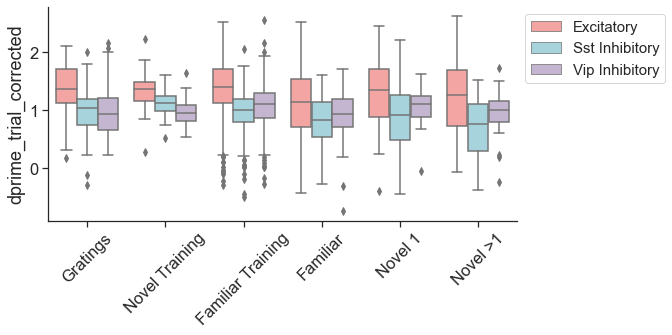

In [79]:
metric = 'dprime_trial_corrected'
# colors = utils.get_experience_level_colors()
colors = utils.get_cre_line_colors()

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=behavior_stats, x='experience_level', y=metric, order=experience_levels, 
                  hue='cell_type', hue_order=cell_types, palette=colors)
ax.legend(fontsize='small', title='', bbox_to_anchor=(1,1))
ax.set_xticklabels(experience_levels, rotation=45)
ax.set_xlabel('')

fig.tight_layout()

### color by exp level per cre line

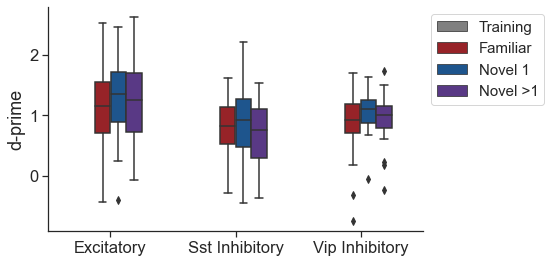

In [80]:
metric = 'dprime_trial_corrected'
colors = utils.get_experience_level_colors()
colors = [(0.5, 0.5, 0.5)]+colors

exp_levels = ['Training', 'Familiar', 'Novel 1', 'Novel >1']
data = behavior_stats[behavior_stats.experience_level.isin(exp_levels)]

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(data=data, x='cell_type', y=metric, order=cell_types, 
                  hue='experience_level', hue_order=exp_levels, palette=colors, width=0.5, dodge=True)
ax.legend(fontsize='small', title='', bbox_to_anchor=(1,1))
ax.set_xlabel('')
ax.set_ylabel('d-prime')
fig.tight_layout()

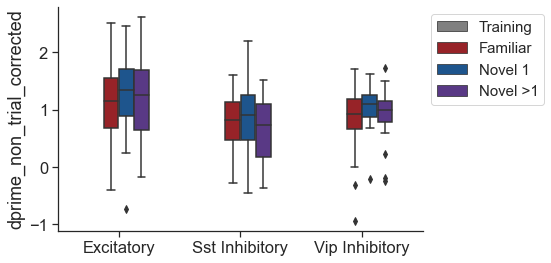

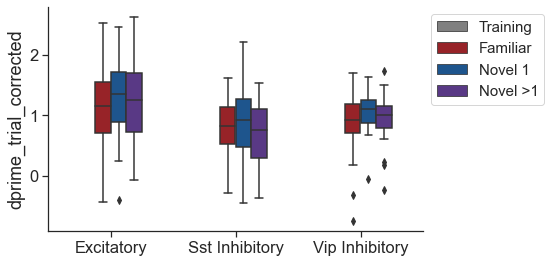

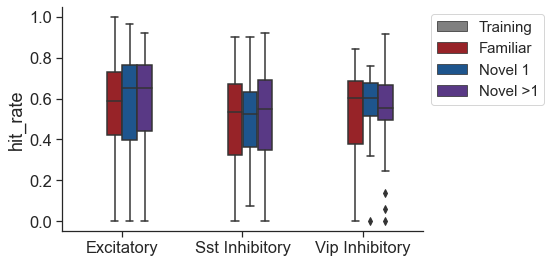

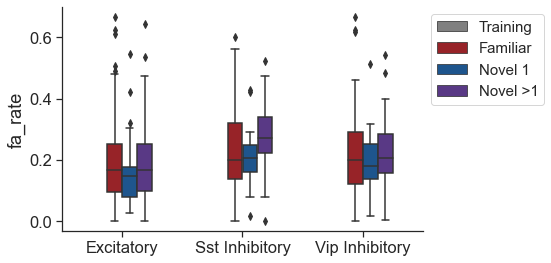

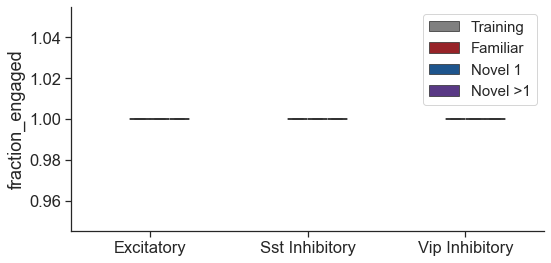

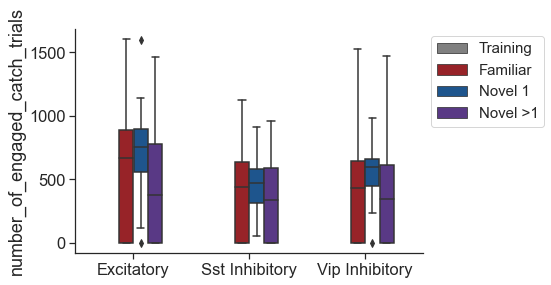

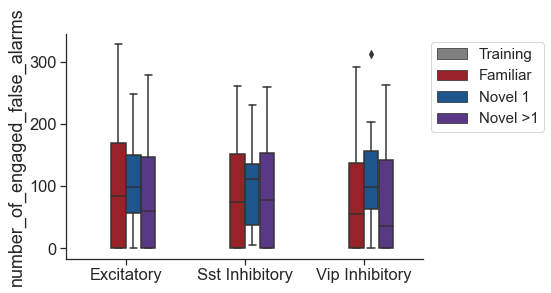

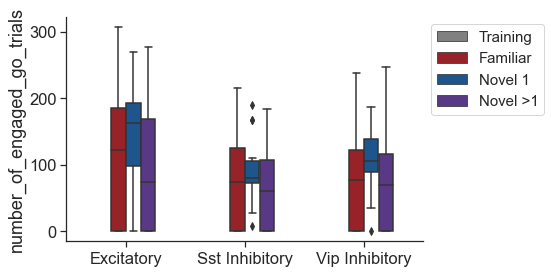

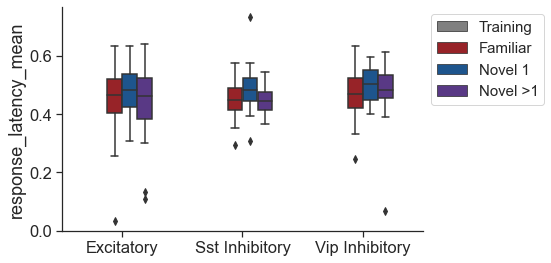

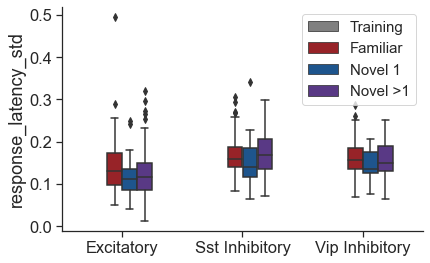

In [81]:
metric = 'dprime_trial_corrected'
colors = utils.get_experience_level_colors()
colors = [(0.5, 0.5, 0.5)]+colors

metrics = ['dprime_non_trial_corrected',
       'dprime_trial_corrected', 'hit_rate', 'fa_rate', 'fraction_engaged',
       'number_of_engaged_catch_trials',
       'number_of_engaged_false_alarms', 'number_of_engaged_go_trials',
       'response_latency_mean', 'response_latency_std',]

exp_levels = ['Training', 'Familiar', 'Novel 1', 'Novel >1']
data = behavior_stats[behavior_stats.experience_level.isin(exp_levels)]

for metric in metrics: 
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.boxplot(data=data, x='cell_type', y=metric, order=cell_types, 
                      hue='experience_level', hue_order=exp_levels, palette=colors, width=0.5, dodge=True)
    ax.legend(fontsize='small', title='', bbox_to_anchor=(1,1))
    ax.set_xlabel('')
    fig.tight_layout()